# Illustration of Mr.ASH and Mr.ASHPen on some special cases

- toc: true
- badges: true
- comments: true
- categories: [trend-filtering, mr-ash, regression-methods, mr-ash-pen]
- slug: mrash-penalized-vs-mrash-special-cases

## About

In this demo, I illustrate the convergence of three different algorithms for using Mr.ASH in sparse multiple linear regression and trendfiltering. Given response variables $\mathbf{y}$ for $N$ samples and explanatory variables $\mathbf{X}$ for $P$ variables (generally $N \lt P$). We will perform a sparse multiple regression using the adaptive shrinkage prior (Mr.ASH),

$\mathbf{y} = \mathbf{X}\mathbf{b} + \mathbf{e}$,

$\mathbf{e} \sim \mathcal{N}\left(\mathbf{0} \mid \sigma^2 I_n \right)$,

$\mathbf{b} \sim p\left(\mathbf{b} \mid \boldsymbol{\theta}_1\right)$.

$p\left(b_i \mid \boldsymbol{\theta}_1\right) = \sum_{k=1}^{K} w_k \mathcal{N}\left(b_i \mid \mu_k, \sigma_k^2\right)$ with constraints $w_k \ge 0$, $\sum_{k=1}^{K} w_k = 1$

We assume $\sigma_k$ is known and will estimate ($\mathbf{b}, \mathbf{w}, \sigma^2)$ from the data.


Here, I will compare four methods:
 - **mr.ash.alpha.** Co-ordinate ascent algorithm for maximizing ELBO (as implemented in `mr.ash.alpha`; [Github](https://github.com/stephenslab/mr.ash.alpha))
 - **mr.ash.pen.** Penalized linear regression using gradient descent (L-BFGS-B) algorithm (as implemented in `mr.ash.pen`; [Github](https://github.com/banskt/mr-ash-pen)).
 - **mr.ash.pen (EM).** Hybrid algorithm which iterates between (i) estimating $\mathbf{b}$ by minimizing PLR objective (approzimate E-Step), and (ii) estimating $\mathbf{w}$ and $\sigma^2$ by maximizing ELBO (approximate M-step).
 - **mr.ash.alpha (init).** Same as `mr.ash.alpha`, but initialized with the results from `mr.ash.pen`.
 
I will illustrate four examples, where `mr.ash.alpha` is known to perform poorly.

**Note:** I will use the ELBO at each iteration for comparing the methods, although it is to be noted that the objective function for `mr.ash.pen` and the objective function for the E-step of `mr.ash.pen (EM`) are different from the ELBO. Hence, the ELBO will not be monotonically increasing for these two methods. Also, the `varobj` obtained from `mr.ash.alpha` is an approximation to the *true* ELBO and matches with the *true* ELBO close to the optimum.

In [35]:
#collapse-hide

import numpy as np
import pandas as pd

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.inference                      import elbo as elbo_py
from mrashpen.inference                      import coordinate_descent_step as cd_step
from mrashpen.models                         import mixture_gaussian as mix_gauss

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, 
                         intercept = 0, title = None):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    
def plot_convergence(objs, methods, nwarm, eps = 1e-8):
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(111)

    objmin  = np.min([np.min(x) for x in objs])

    for obj, method, iteq in zip(objs, methods, nwarm):
        m_obj = obj[iteq:] - objmin
        m_obj = m_obj[m_obj > 0]
        ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method)
    ax1.legend()

    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("log( max(ELBO) - ELBO )")

    plt.show()
    return

def plot_trendfilter_mrashpen(X, y, beta, ytest, bhat,
                              intercept = 0, title = None):
    n = y.shape[0]
    p = X.shape[1]

    ypred = np.dot(X, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white')
    ax1.plot(np.arange(n), ypred)
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("Y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white')
    ax2.scatter(np.arange(p), bhat, s = 40, color = 'firebrick')
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")
    
    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()
    
def linreg_summary_df(sigma2, objs, methods):
    data     = [[strue * strue,  '-', '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.elbo_path[-1], obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'ELBO', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

## 1. Semi-dense, high-dimensional setting

In high-dimensional data ($N = 200$ and $P = 2000$), Mr.ASH is known perform worse than LASSO in a dense setting with large number of non-causal variables and high PVE ([1](https://banskt.github.io/iridge-notes/2021/03/24/compare-prediction-accuracy-linear-regression-methods-dsc.html), [2](https://stephens999.github.io/misc/mr_ash_vs_lasso.html)). Here, I used $P_{\textrm{causal}} = 500$ and PVE $= 0.95$. Here, mr.ash.pen and mr.ash.pen (EM) converges to a better solution, the first one with a significantly higher ELBO and the second one with a slightly higher ELBO (!).  

**Note:** I found that `mr.ash.pen (EM)` converges to the correct solution for a wider range of $P_{\textrm{causal}}$. (To do: Run simulation with DSC to explore the full range)

In [2]:
#collapse-hide

n = 200
p = 2000
p_causal = 50
pve = 0.95
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.0, seed = 100)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

Here, I run the three methods.

In [3]:
#collapse-show

'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)
winit  = mix_gauss.emfit(lasso_b, sk)
print ("Lasso initialization")

'''
mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True, 
                maxiter = 2000, tol = 1e-8)
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)
# plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = s2init)
# plr_lbfgs = lbfgsfit(X, y, sk, wk, binit = lasso_b, s2init = s2init, calculate_elbo = True)

'''
mr.ash.pen (EM)
'''
# plr_eb = ebfit(X, y, sk, wk, binit = None, s2init = 1, maxiter = 200, qb_maxiter = 100)
plr_eb = ebfit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init, 
               maxiter = 200, qb_maxiter = 50, calculate_elbo = True)

'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)

'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

R[write to console]: Loading required package: Matrix



Lasso initialization
mr.ash.pen terminated at iteration 426.
mr.ash.pen (EM) terminated at iteration 200.
Mr.ASH terminated at iteration 287.
Mr.ASH terminated at iteration 14.


On the left panel I compare the predicted $\mathbf{y}_{\mathrm{test}}$ by the different methods (y-axis) with the true $\mathbf{y}_{\mathrm{test}}$ (x-axis). On the right panel, I compare the predicted coefficients (y-axis) with their true values (x-axis). The plot at the bottom shows the convergence of the different methods against the number of iteration.

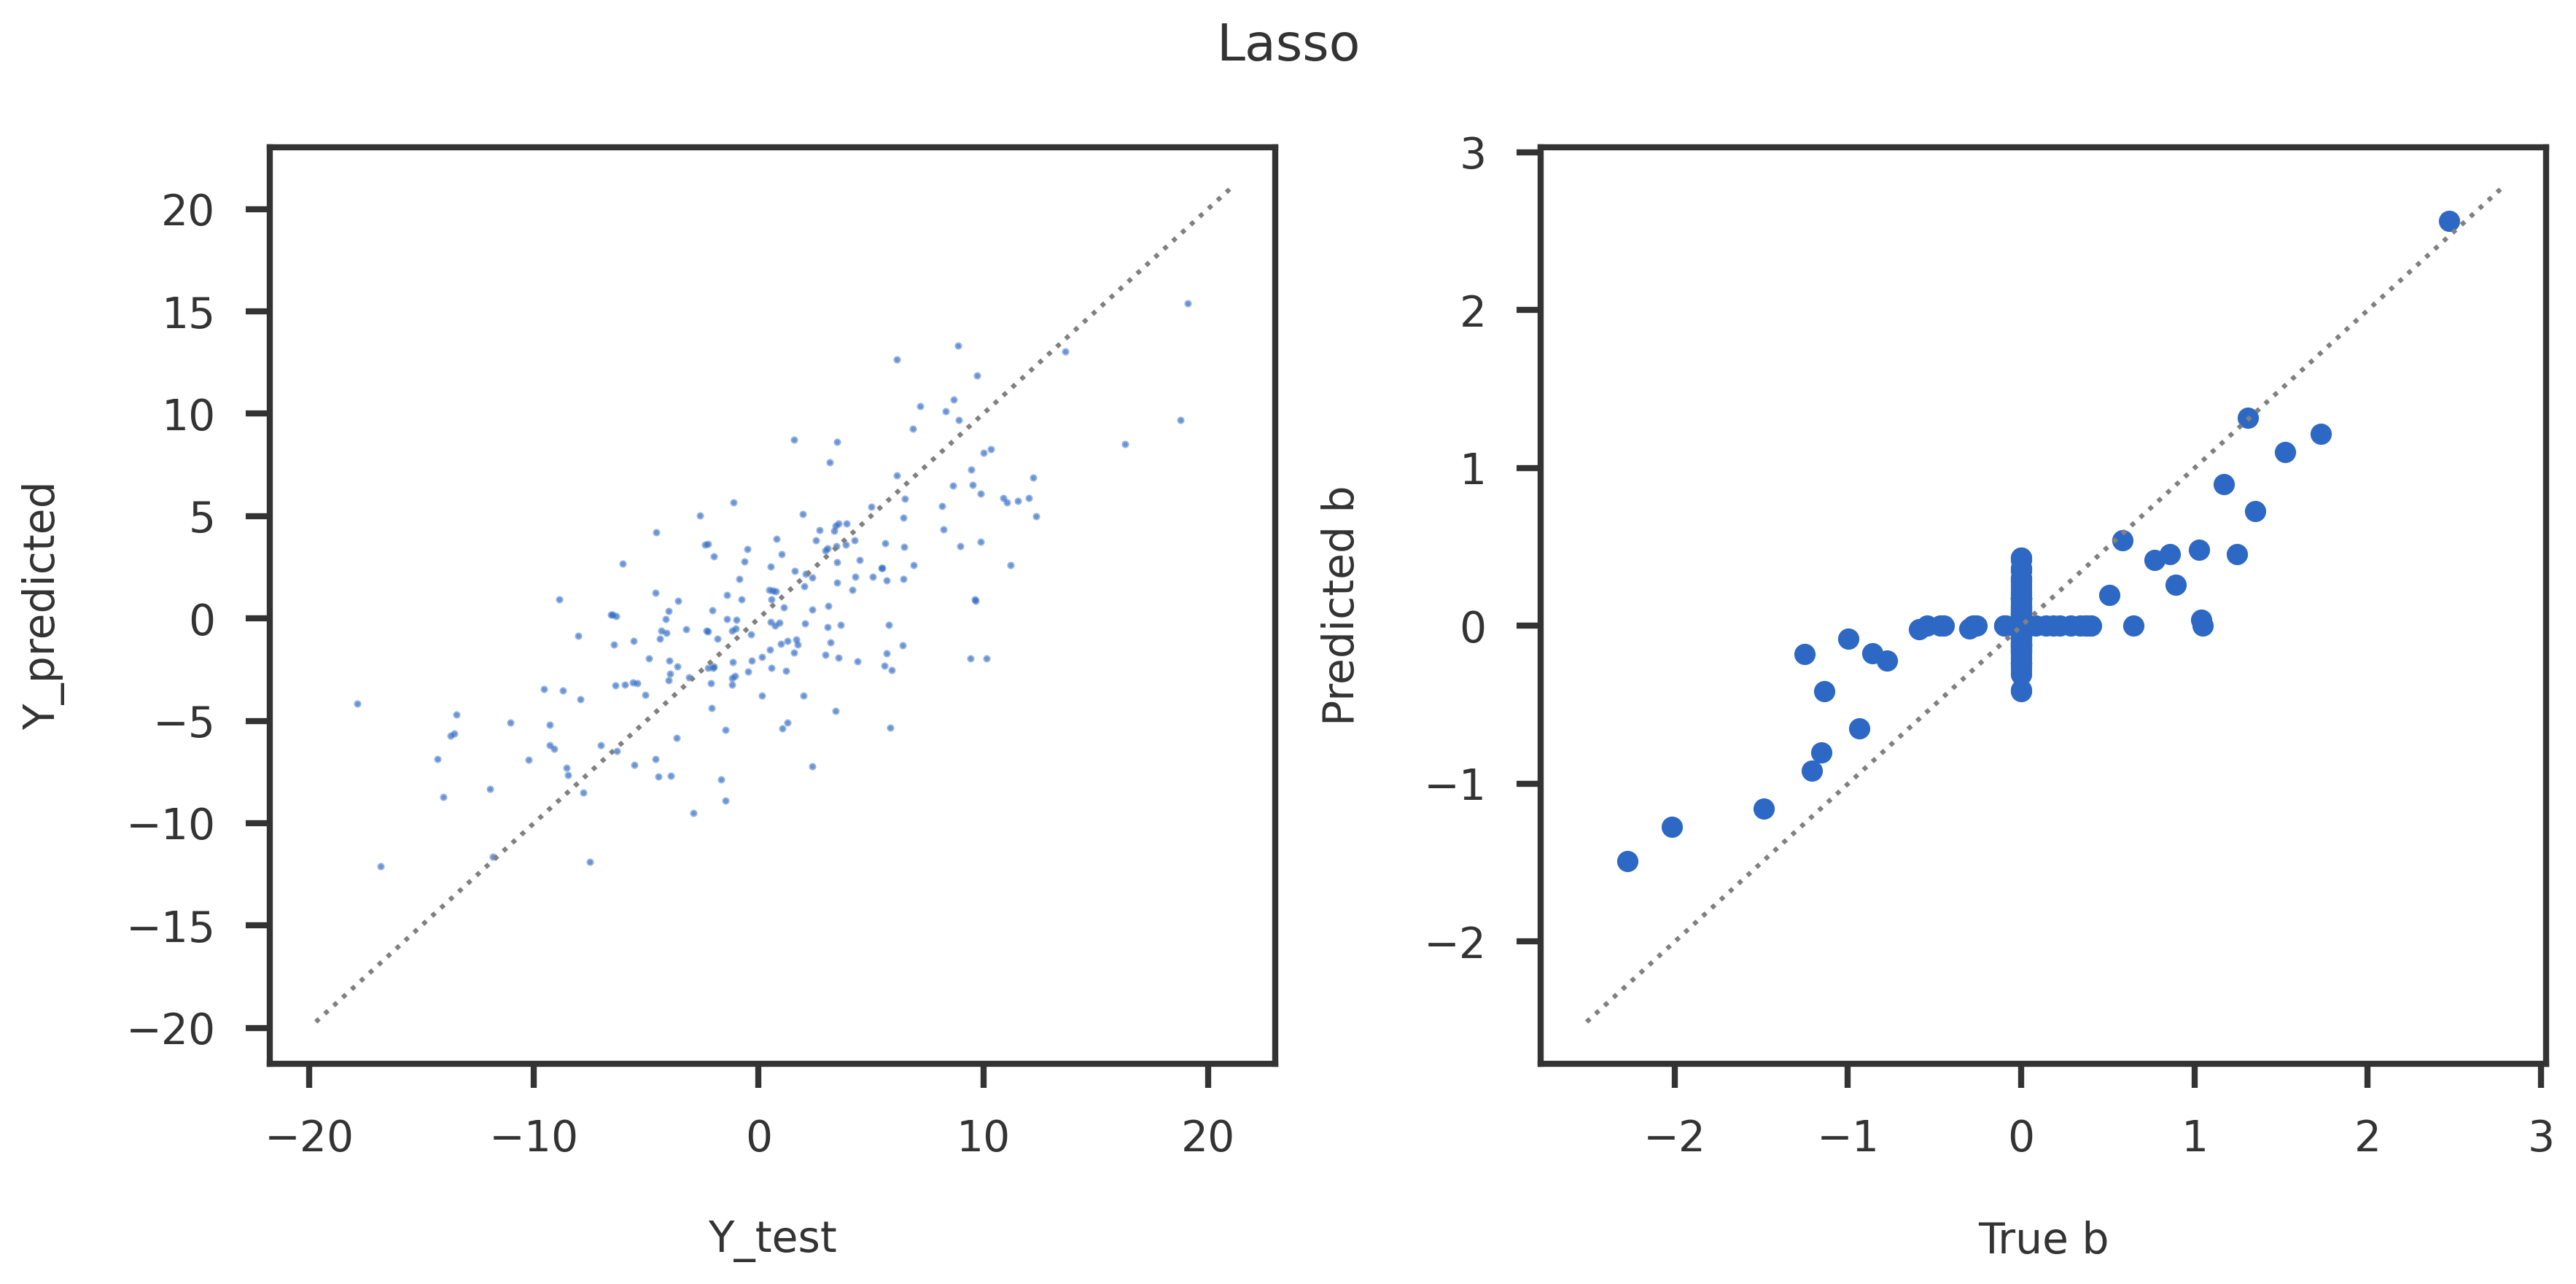

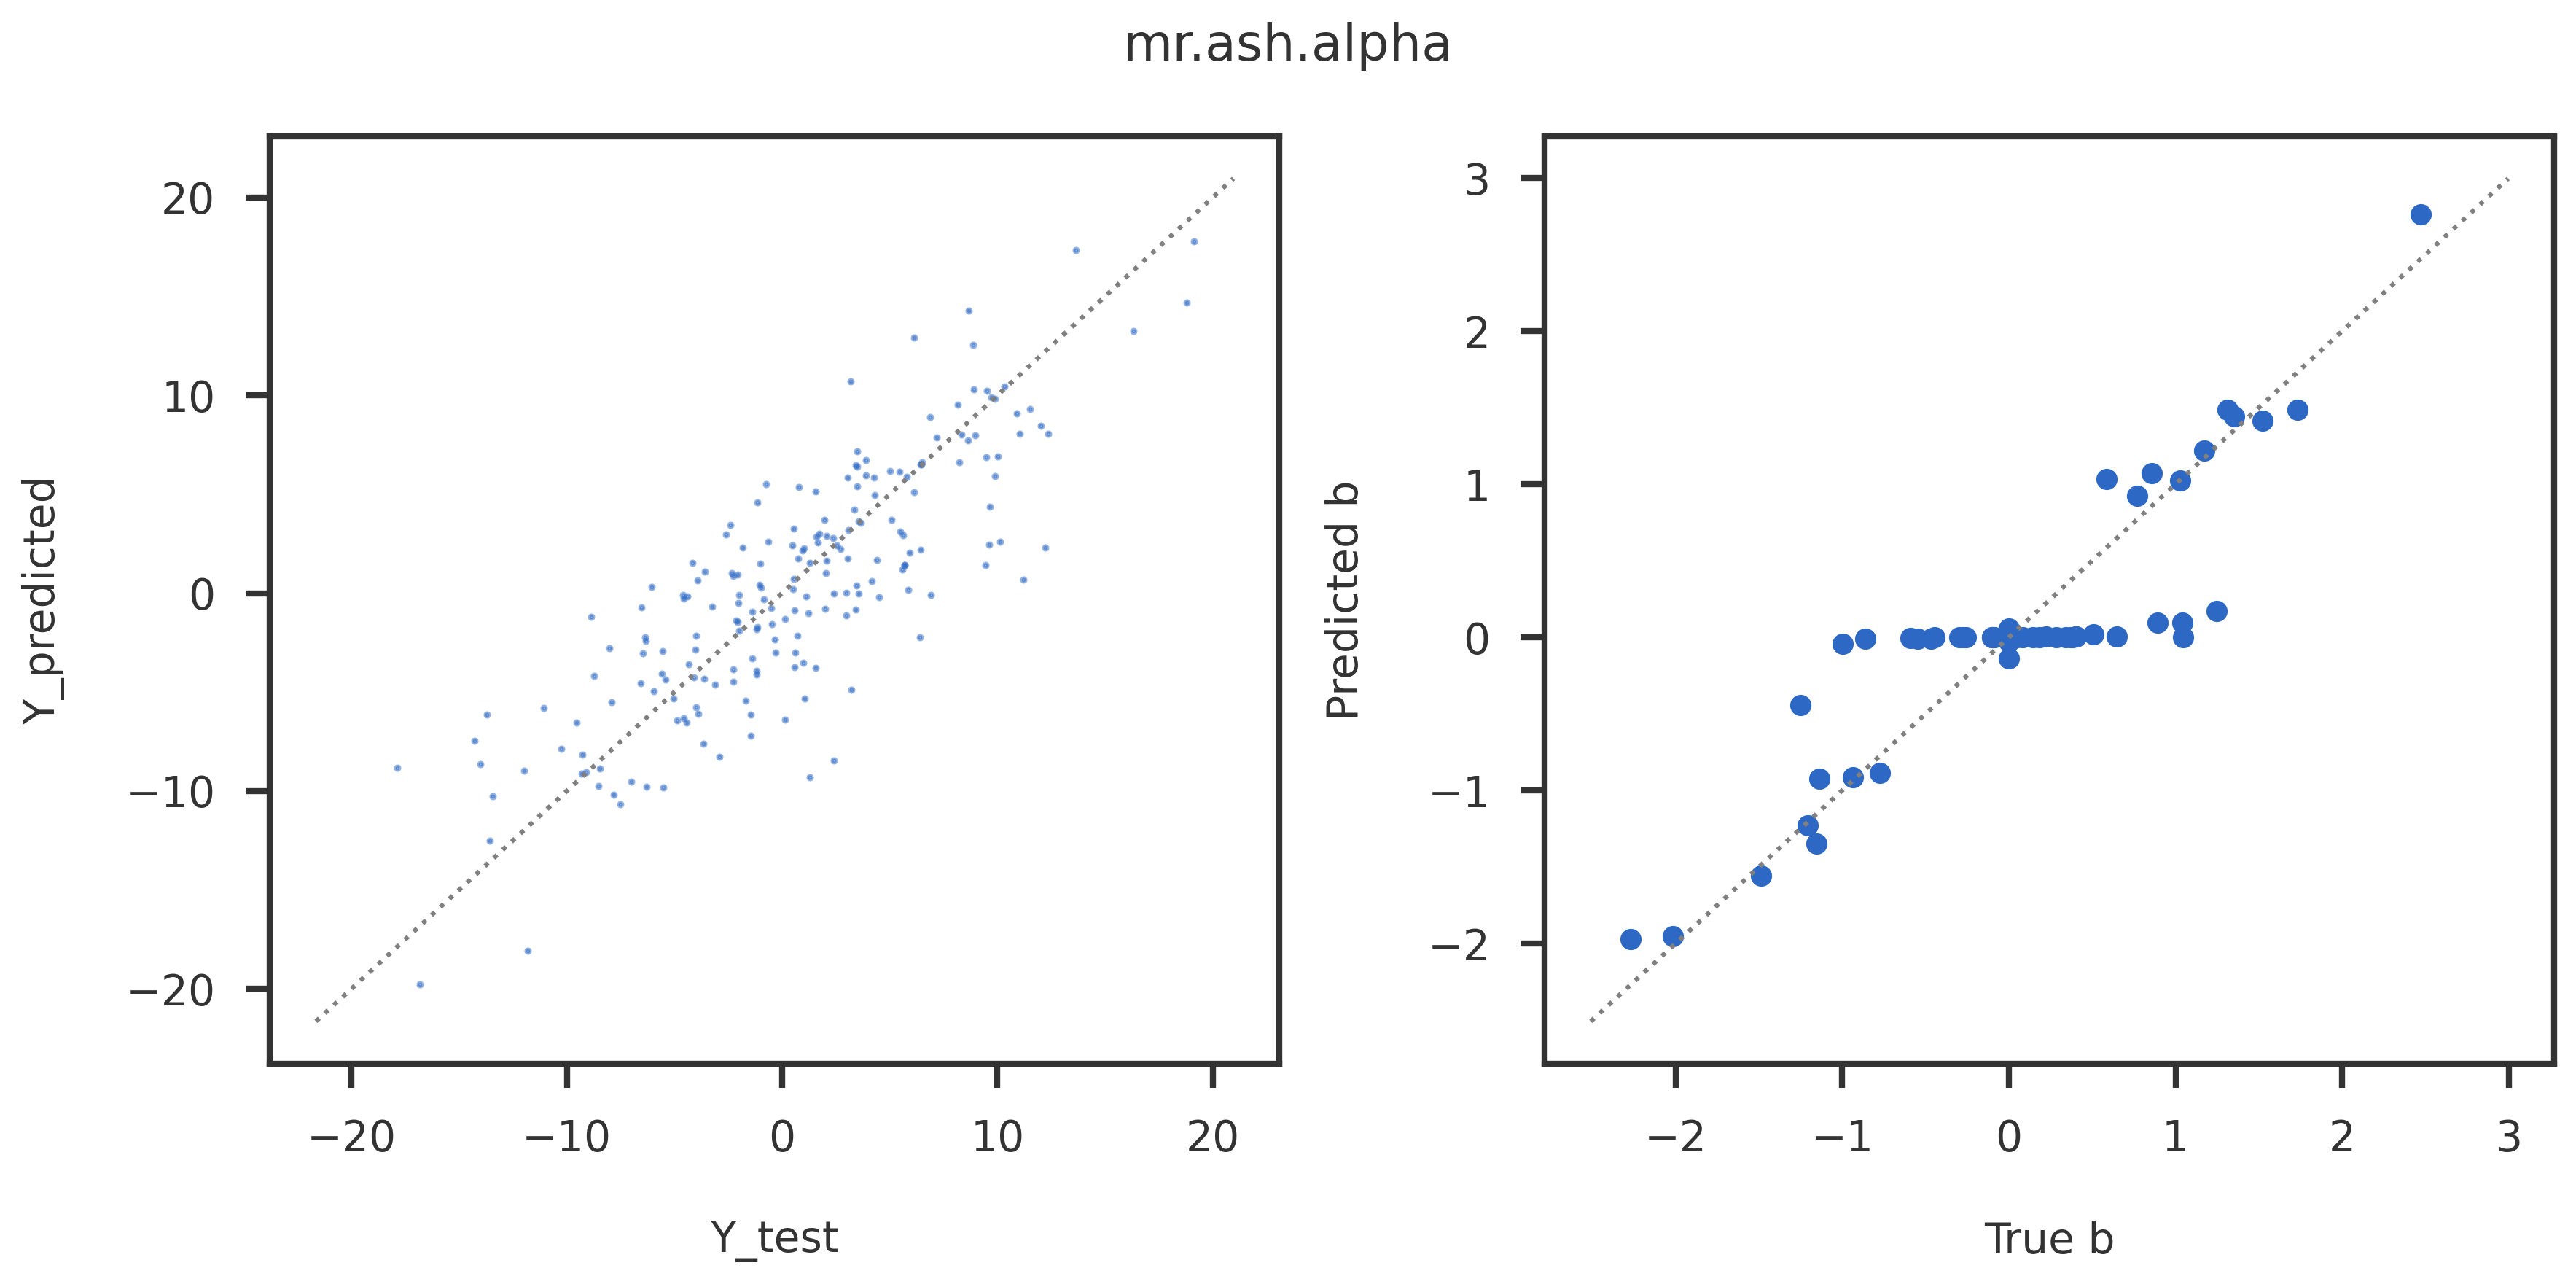

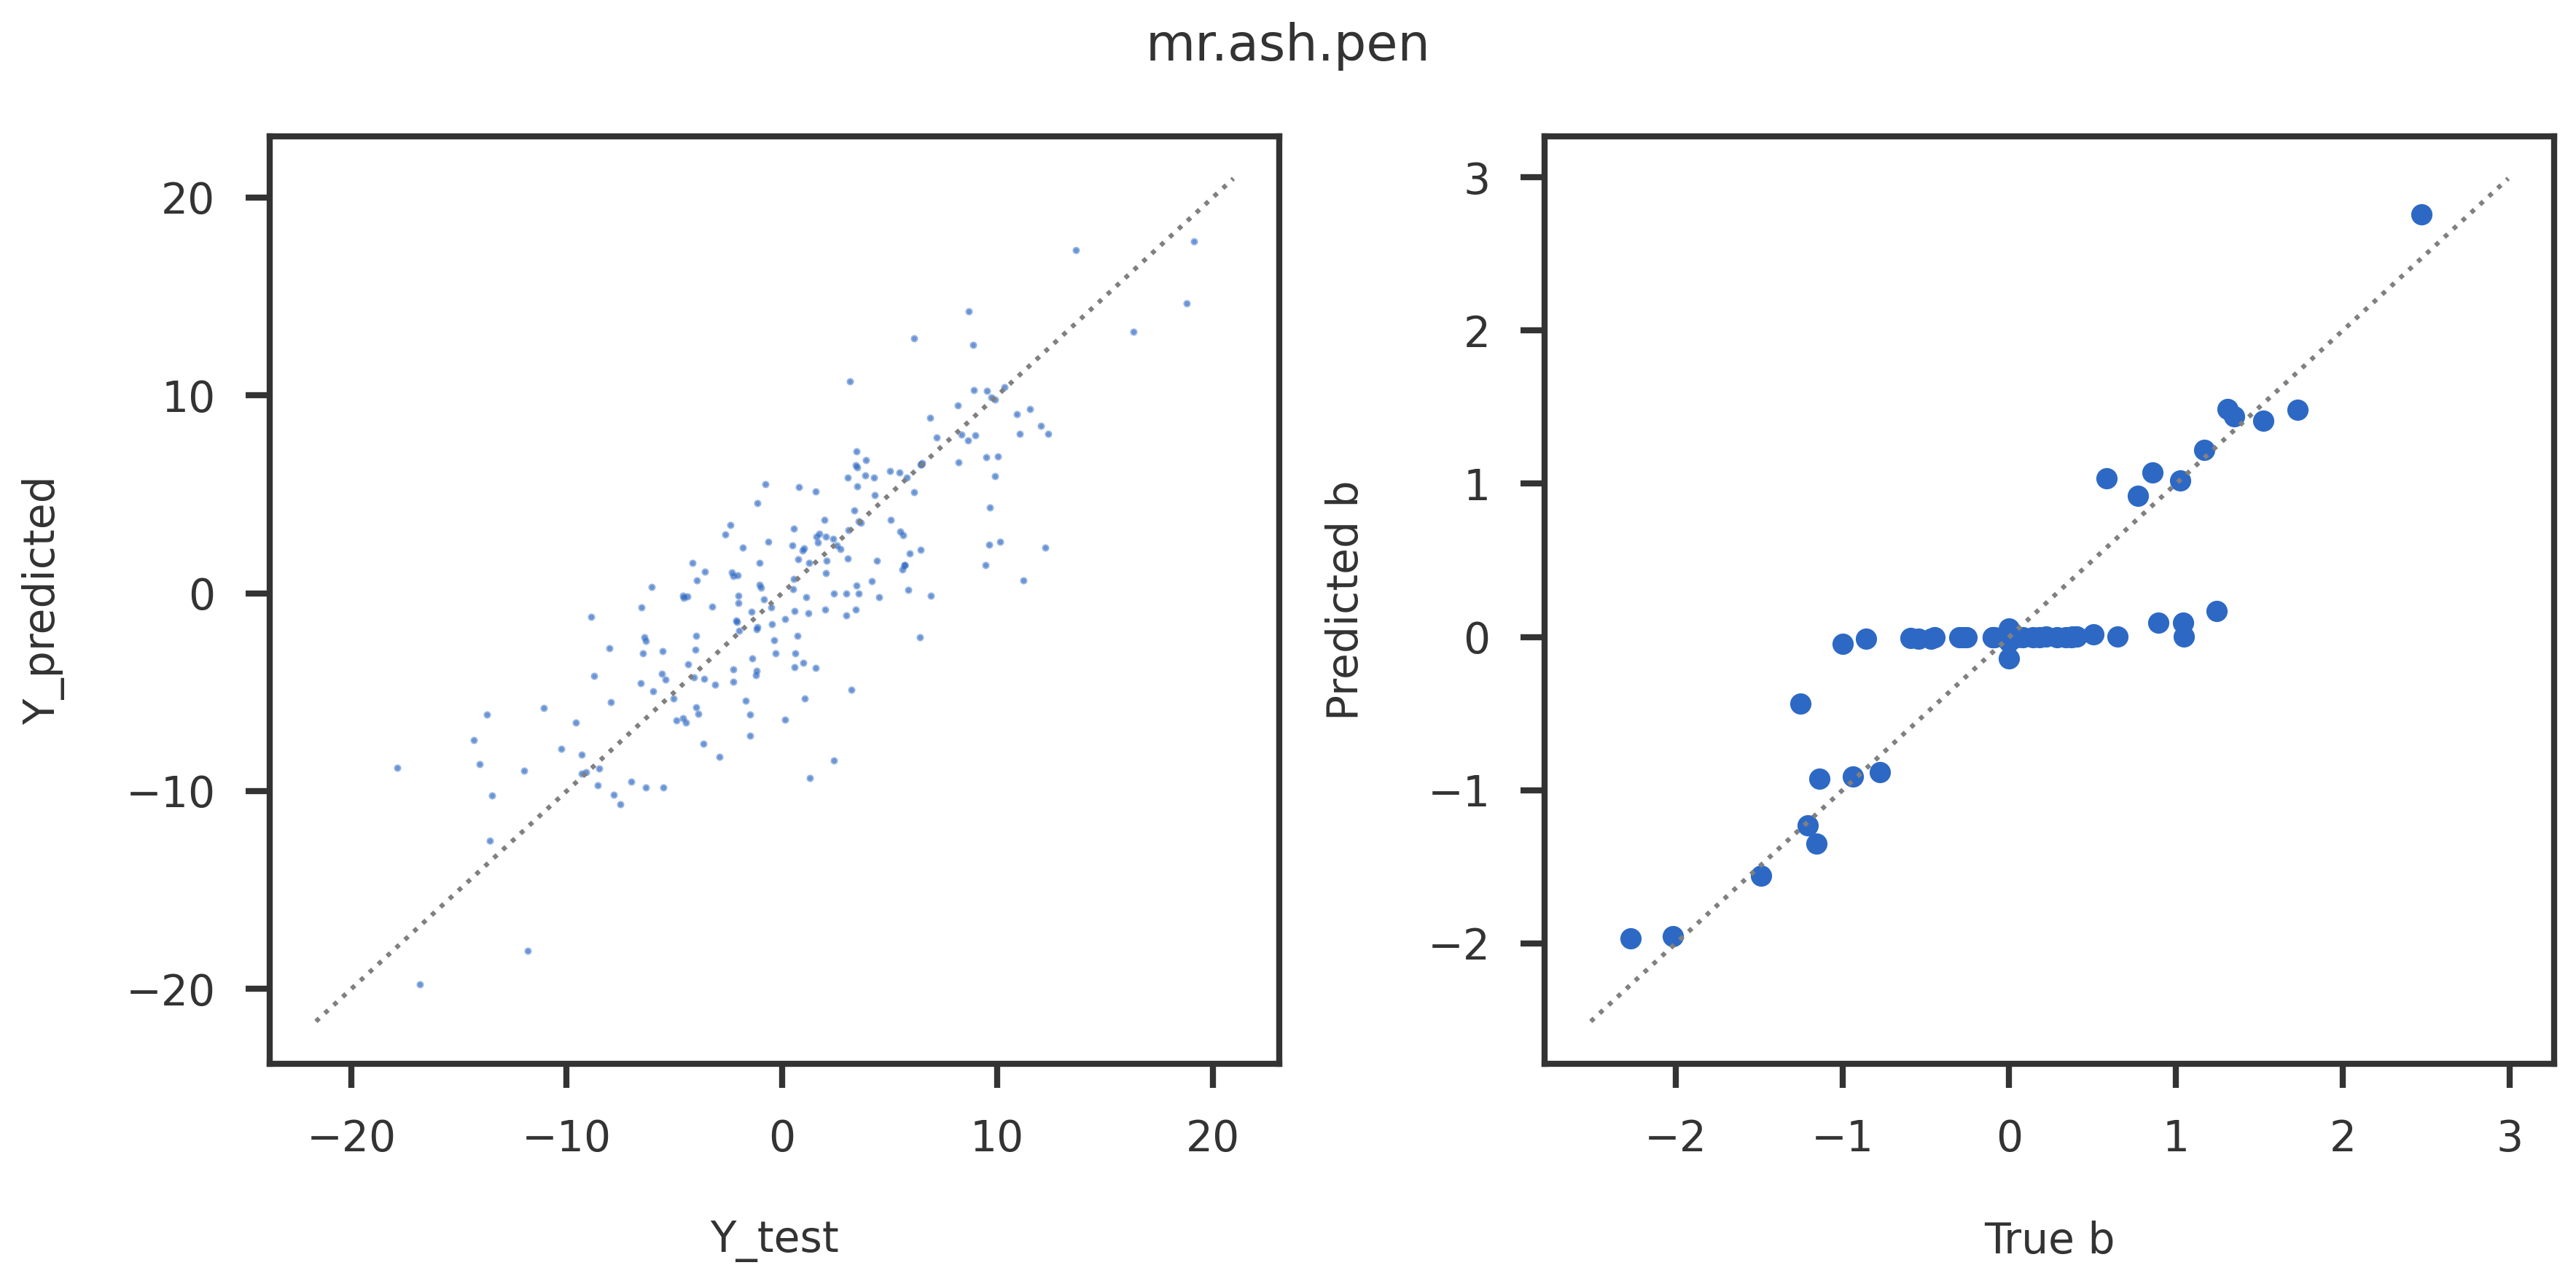

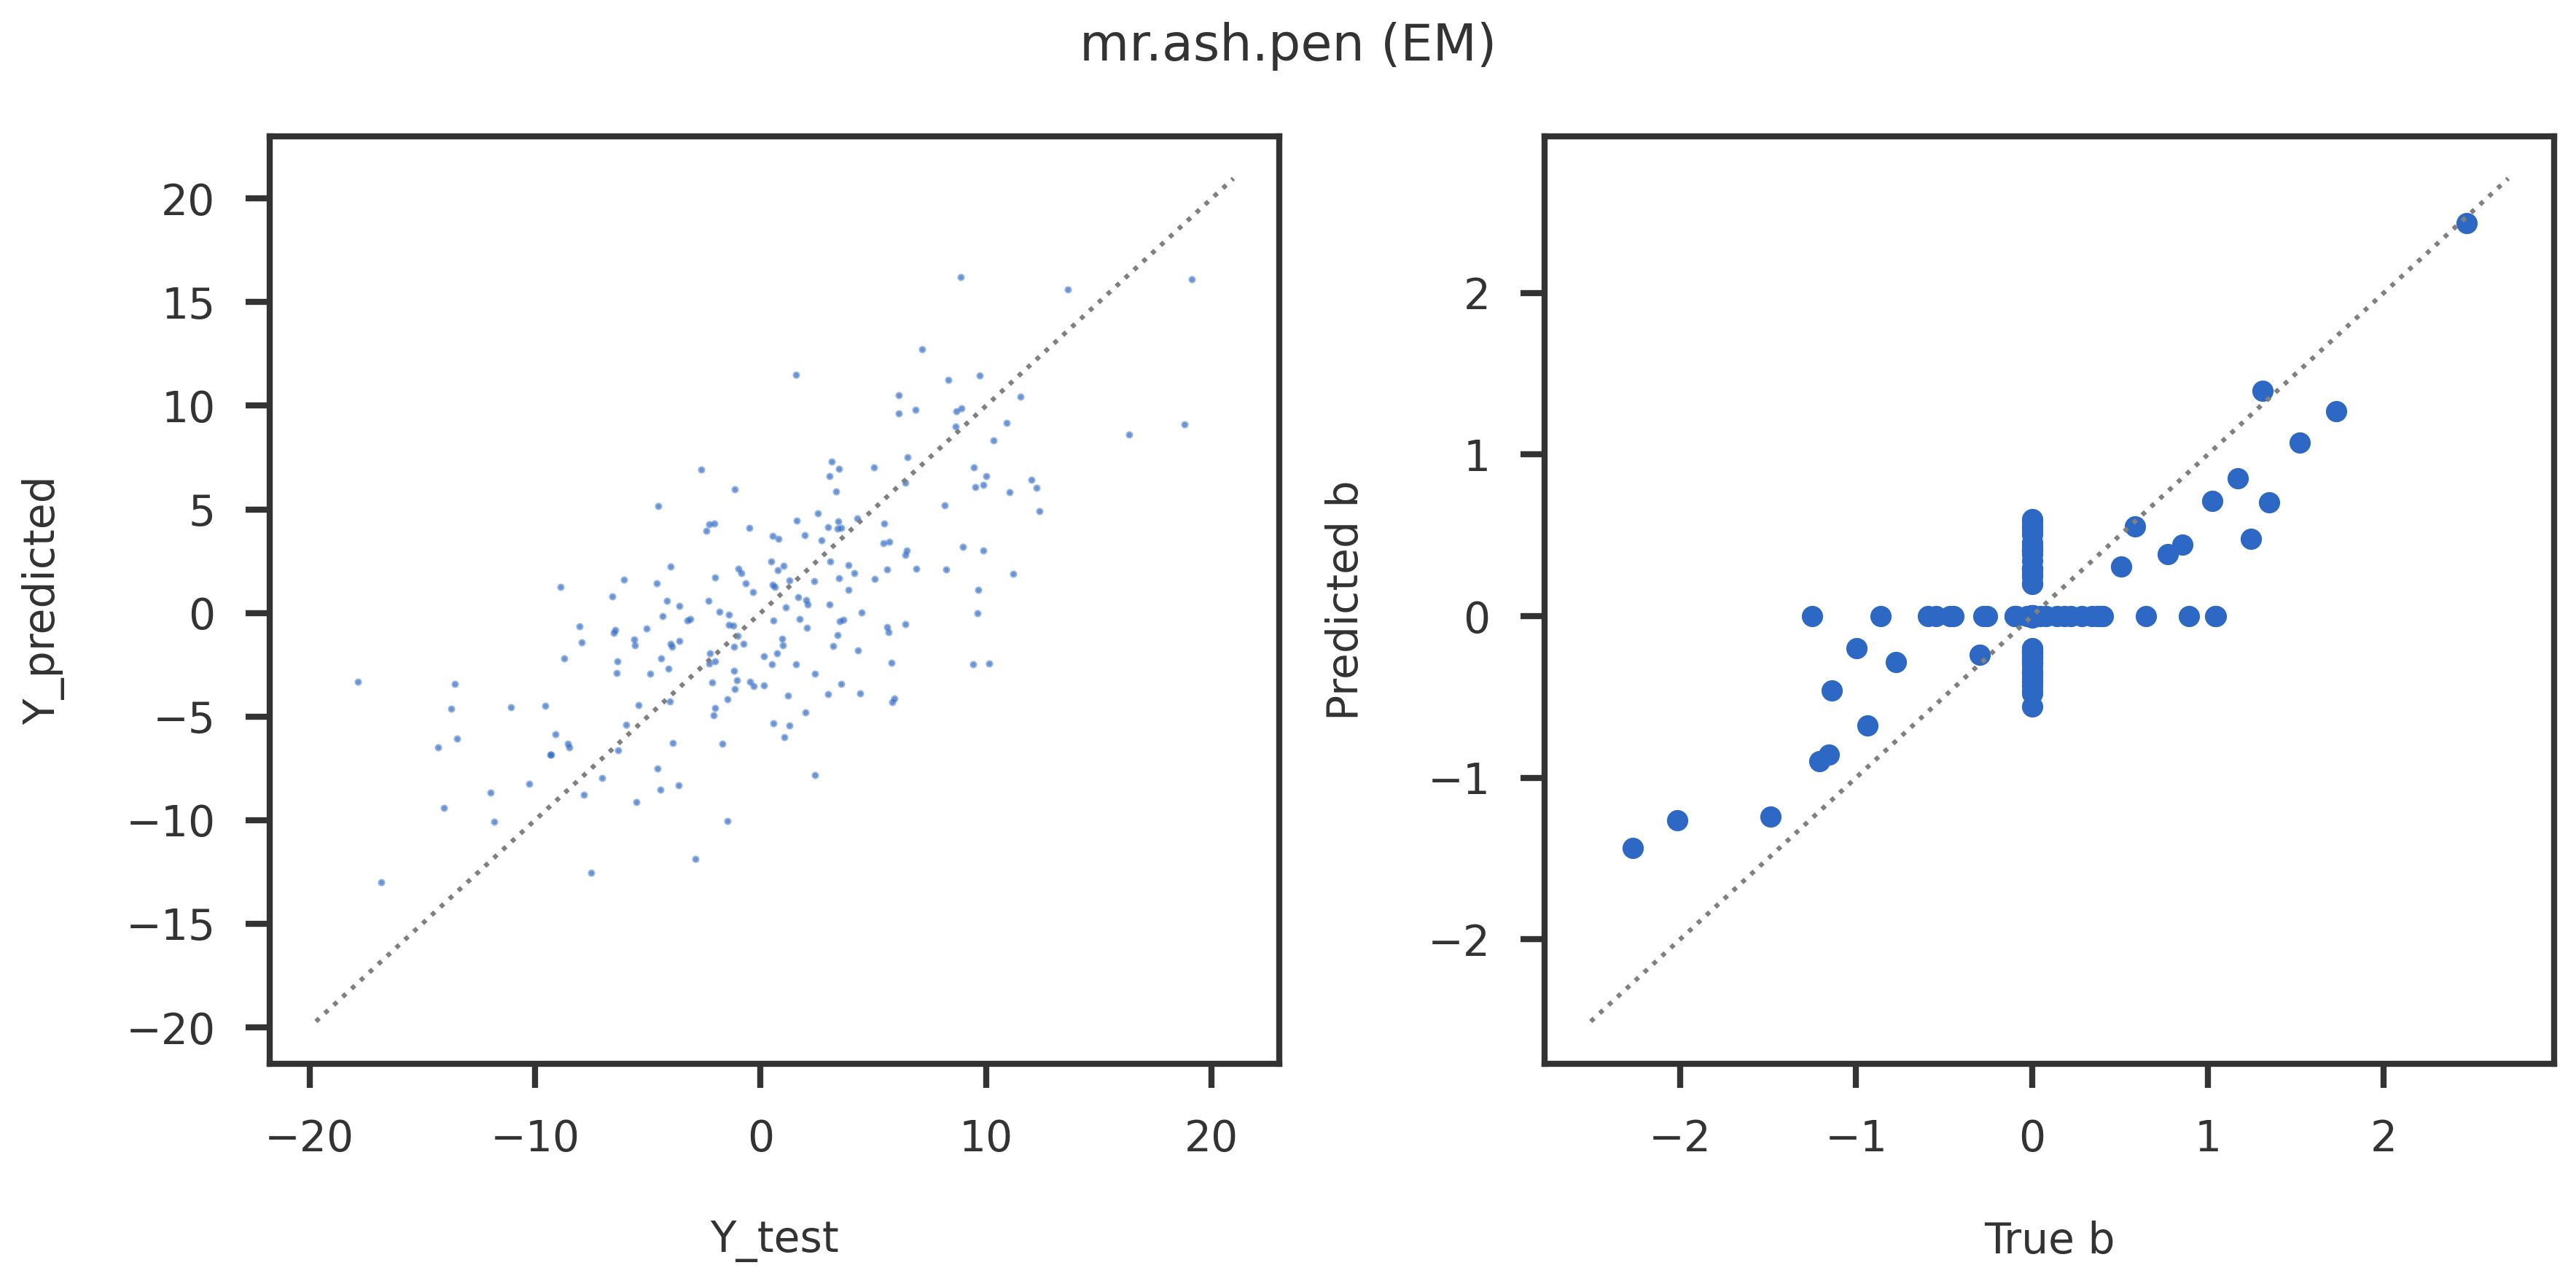

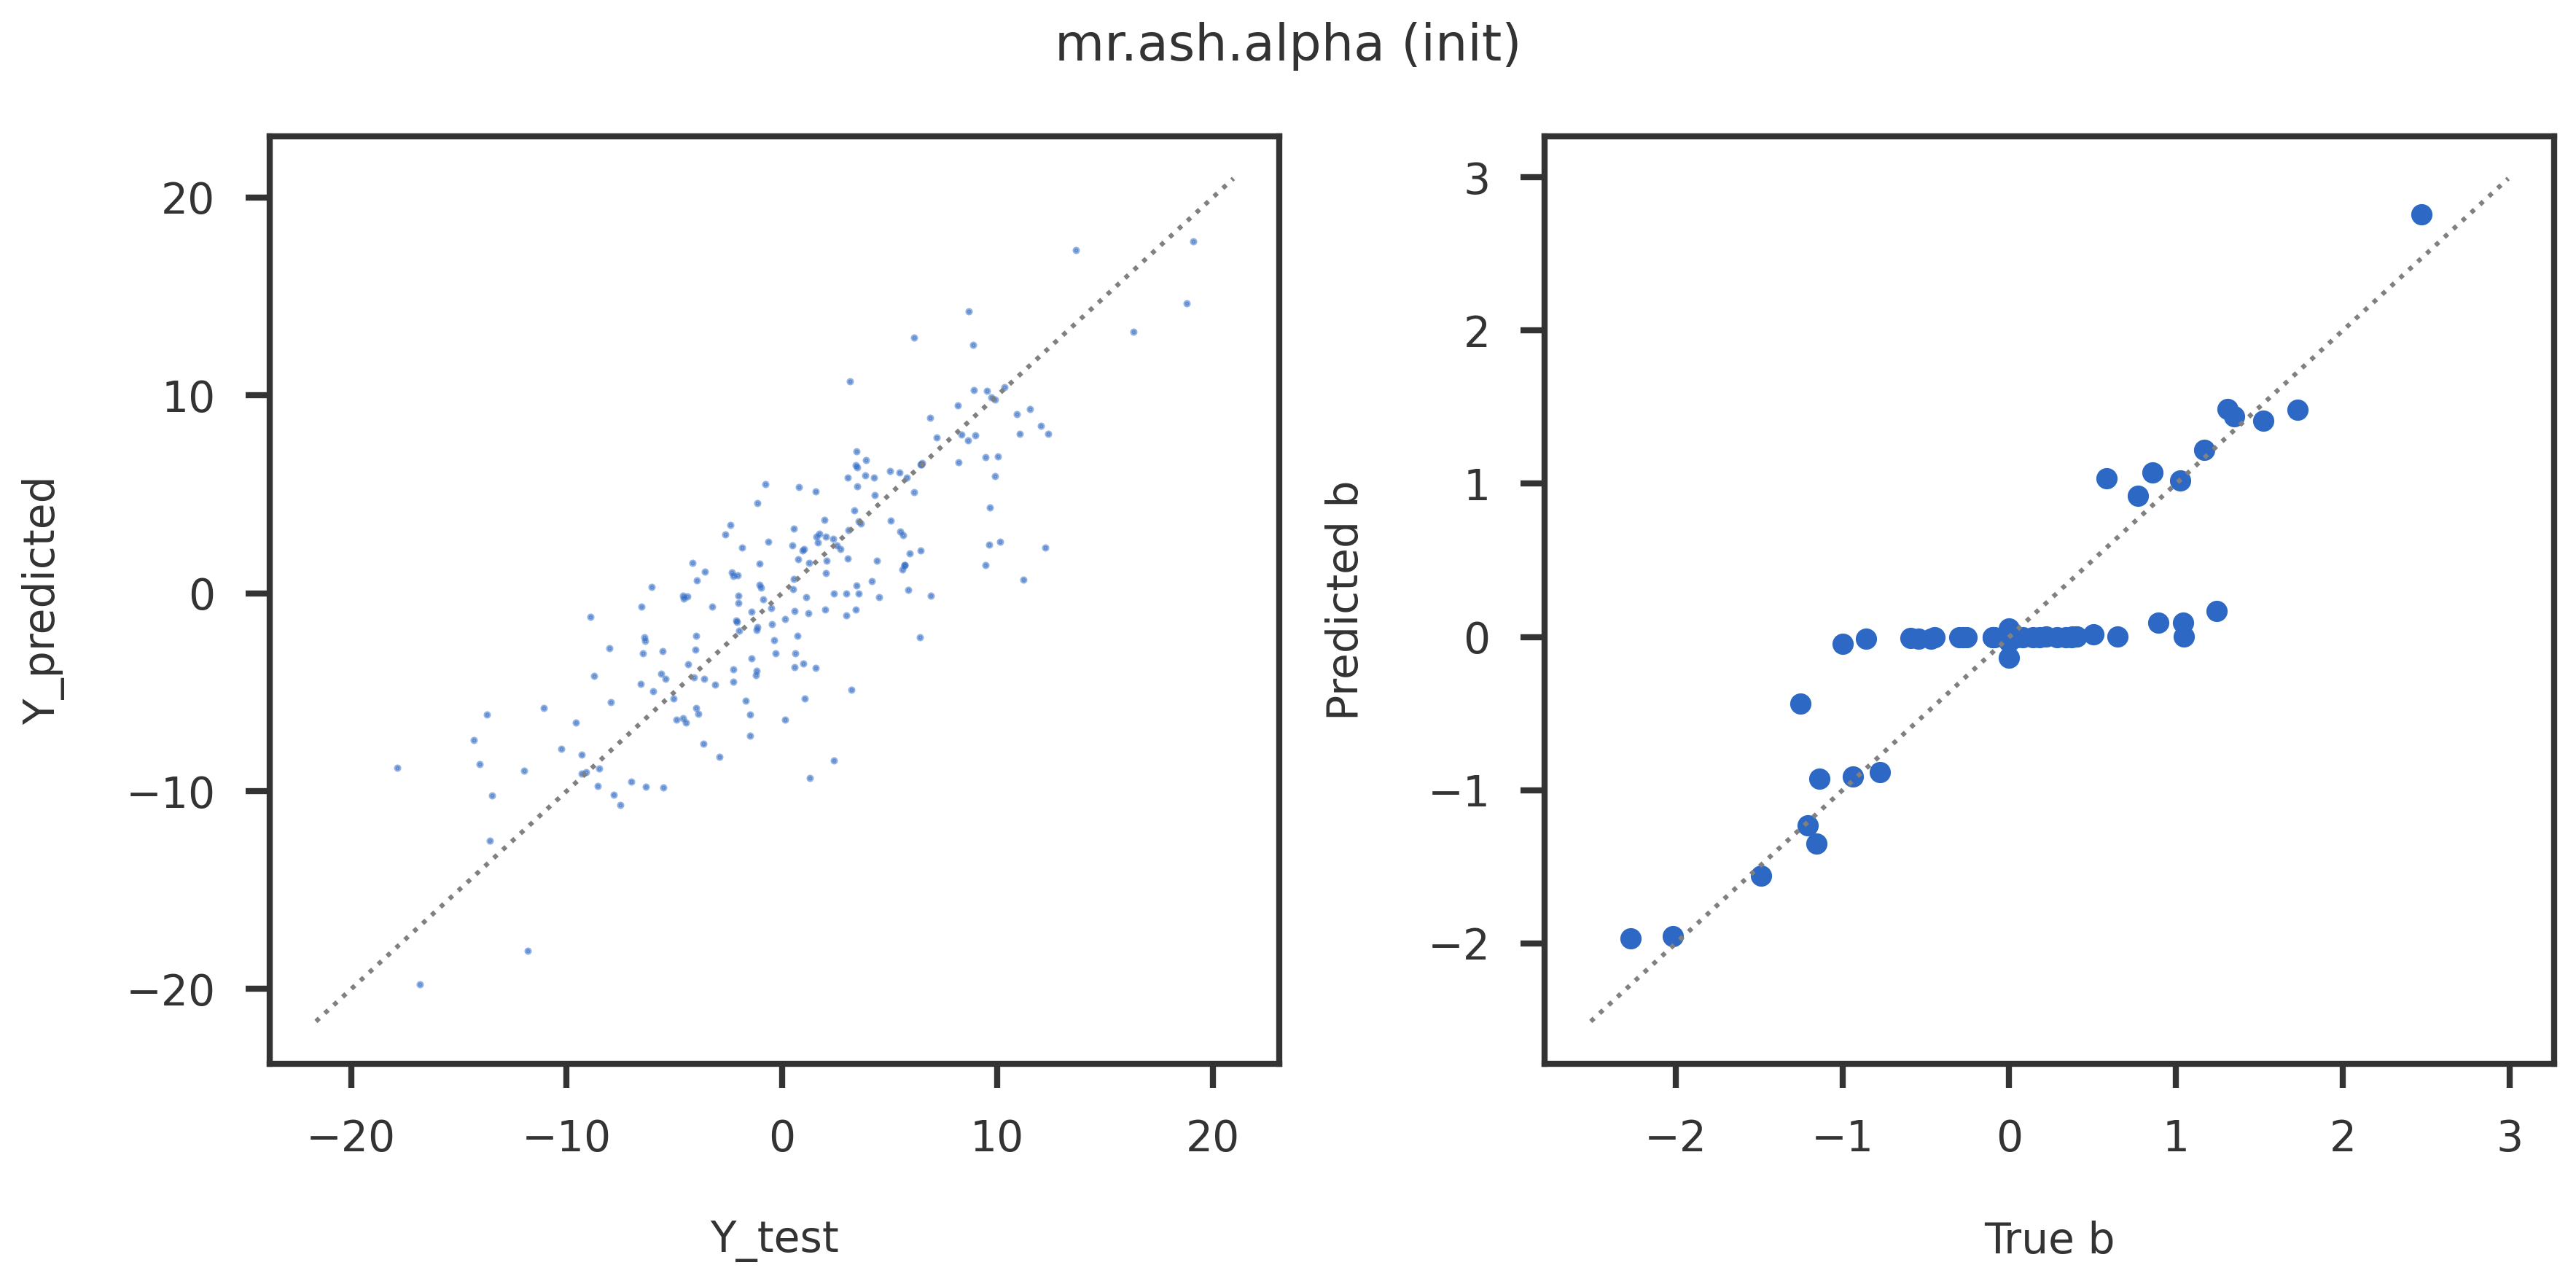

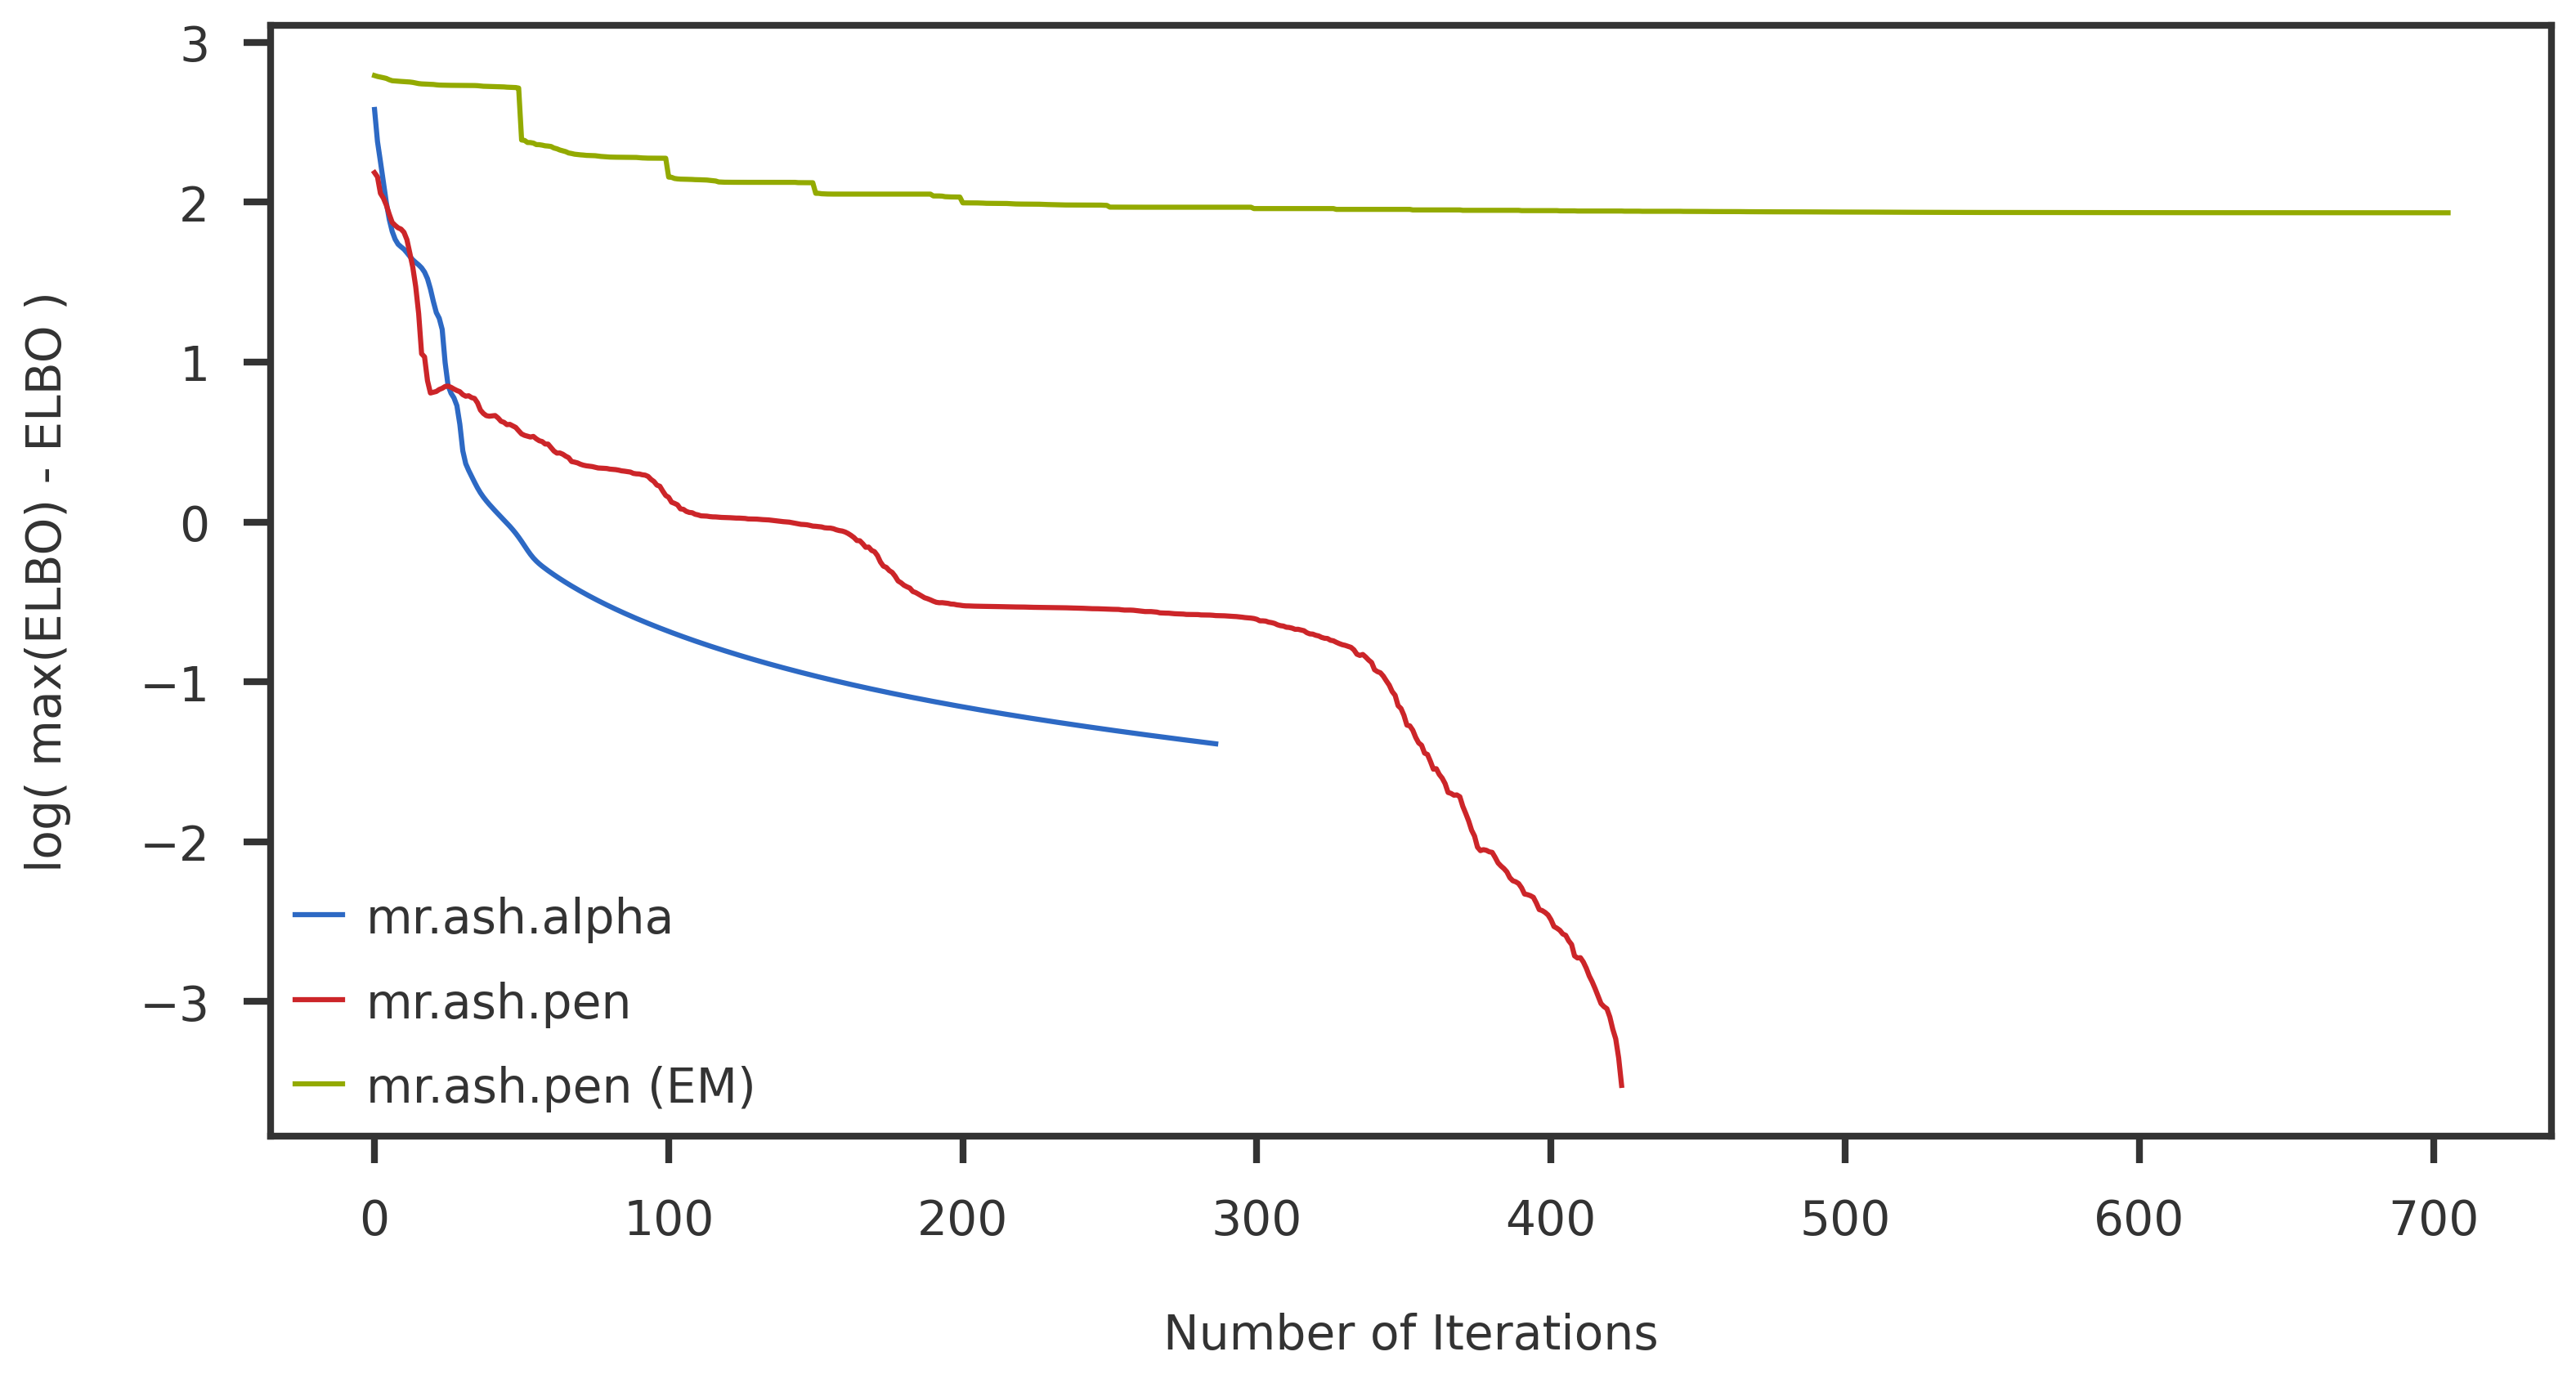

In [4]:
#collapse-hide
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue,
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [5]:
#collapse-hide

objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
df

sigma2        ELBO niter
True                 2.274857           -     -
mr.ash.alpha         6.596107  617.949649   287
mr.ash.pen           6.624967  617.908679   426
mr.ash.pen (EM)      0.415383  703.591955   706
mr.ash.alpha (init)  6.626743   617.90801    14

## 2. Correlated variables

It was also found earlier that mr.ash.alpha performs suboptimally, when the variable are correlated ([1](https://banskt.github.io/iridge-notes/2021/03/24/compare-prediction-accuracy-linear-regression-methods-dsc.html)). This is an interesting case, because real world applications on genetic data involves strong correlations. Here, I have generated data from matrix normal distribution, $\mathbf{X} \sim \mathcal{MN}\left(0, \mathbb{I}_N, \mathbf{\Sigma}_{\rho} \right)$, where $\mathbf{\Sigma}_{\rho}$ is a matrix with ones along the diagonal and all off diagonal entries set to $\rho \gt 0$. That is, each row of $\mathbf{X}$ is multivariate normal with zero mean and covariance $\mathbf{\Sigma}_{\rho}$. In this particular example, I have used $\rho = 0.95$ and PVE = $0.95$ with 10 non-causal variables in a high-dimension setting ($N = 200$ and $P = 2000$).

Interestingly, the convergence for mr.ash.pen happens after a large number of iterations, while the other methods fails to converge to a higher ELBO.

In [36]:
#collapse-hide

n = 200
p = 2000
p_causal = 10
pve = 0.7
rho = 0.95
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = rho, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

In [37]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)
winit  = mix_gauss.emfit(lasso_b, sk)
print ("Lasso initialization")

'''
mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True, 
                maxiter = 2000, tol = 1e-8, function_call = 'python')
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)
#plr_lbfgs = lbfgsfit.method_fixseq_simple(X, y, sk, wk, binit = lasso_b, s2init = s2init, calculate_elbo = True)
#plr_lbfgs = lbfgsfit.method_init_gb(X, y, sk, wk, binit = lasso_b, s2init = s2init, calculate_elbo = True)

'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init, 
               maxiter = 200, qb_maxiter = 50, calculate_elbo = True)


'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

Lasso initialization
mr.ash.pen terminated at iteration 174.
mr.ash.pen (EM) terminated at iteration 70.
Mr.ASH terminated at iteration 405.
Mr.ASH terminated at iteration 217.


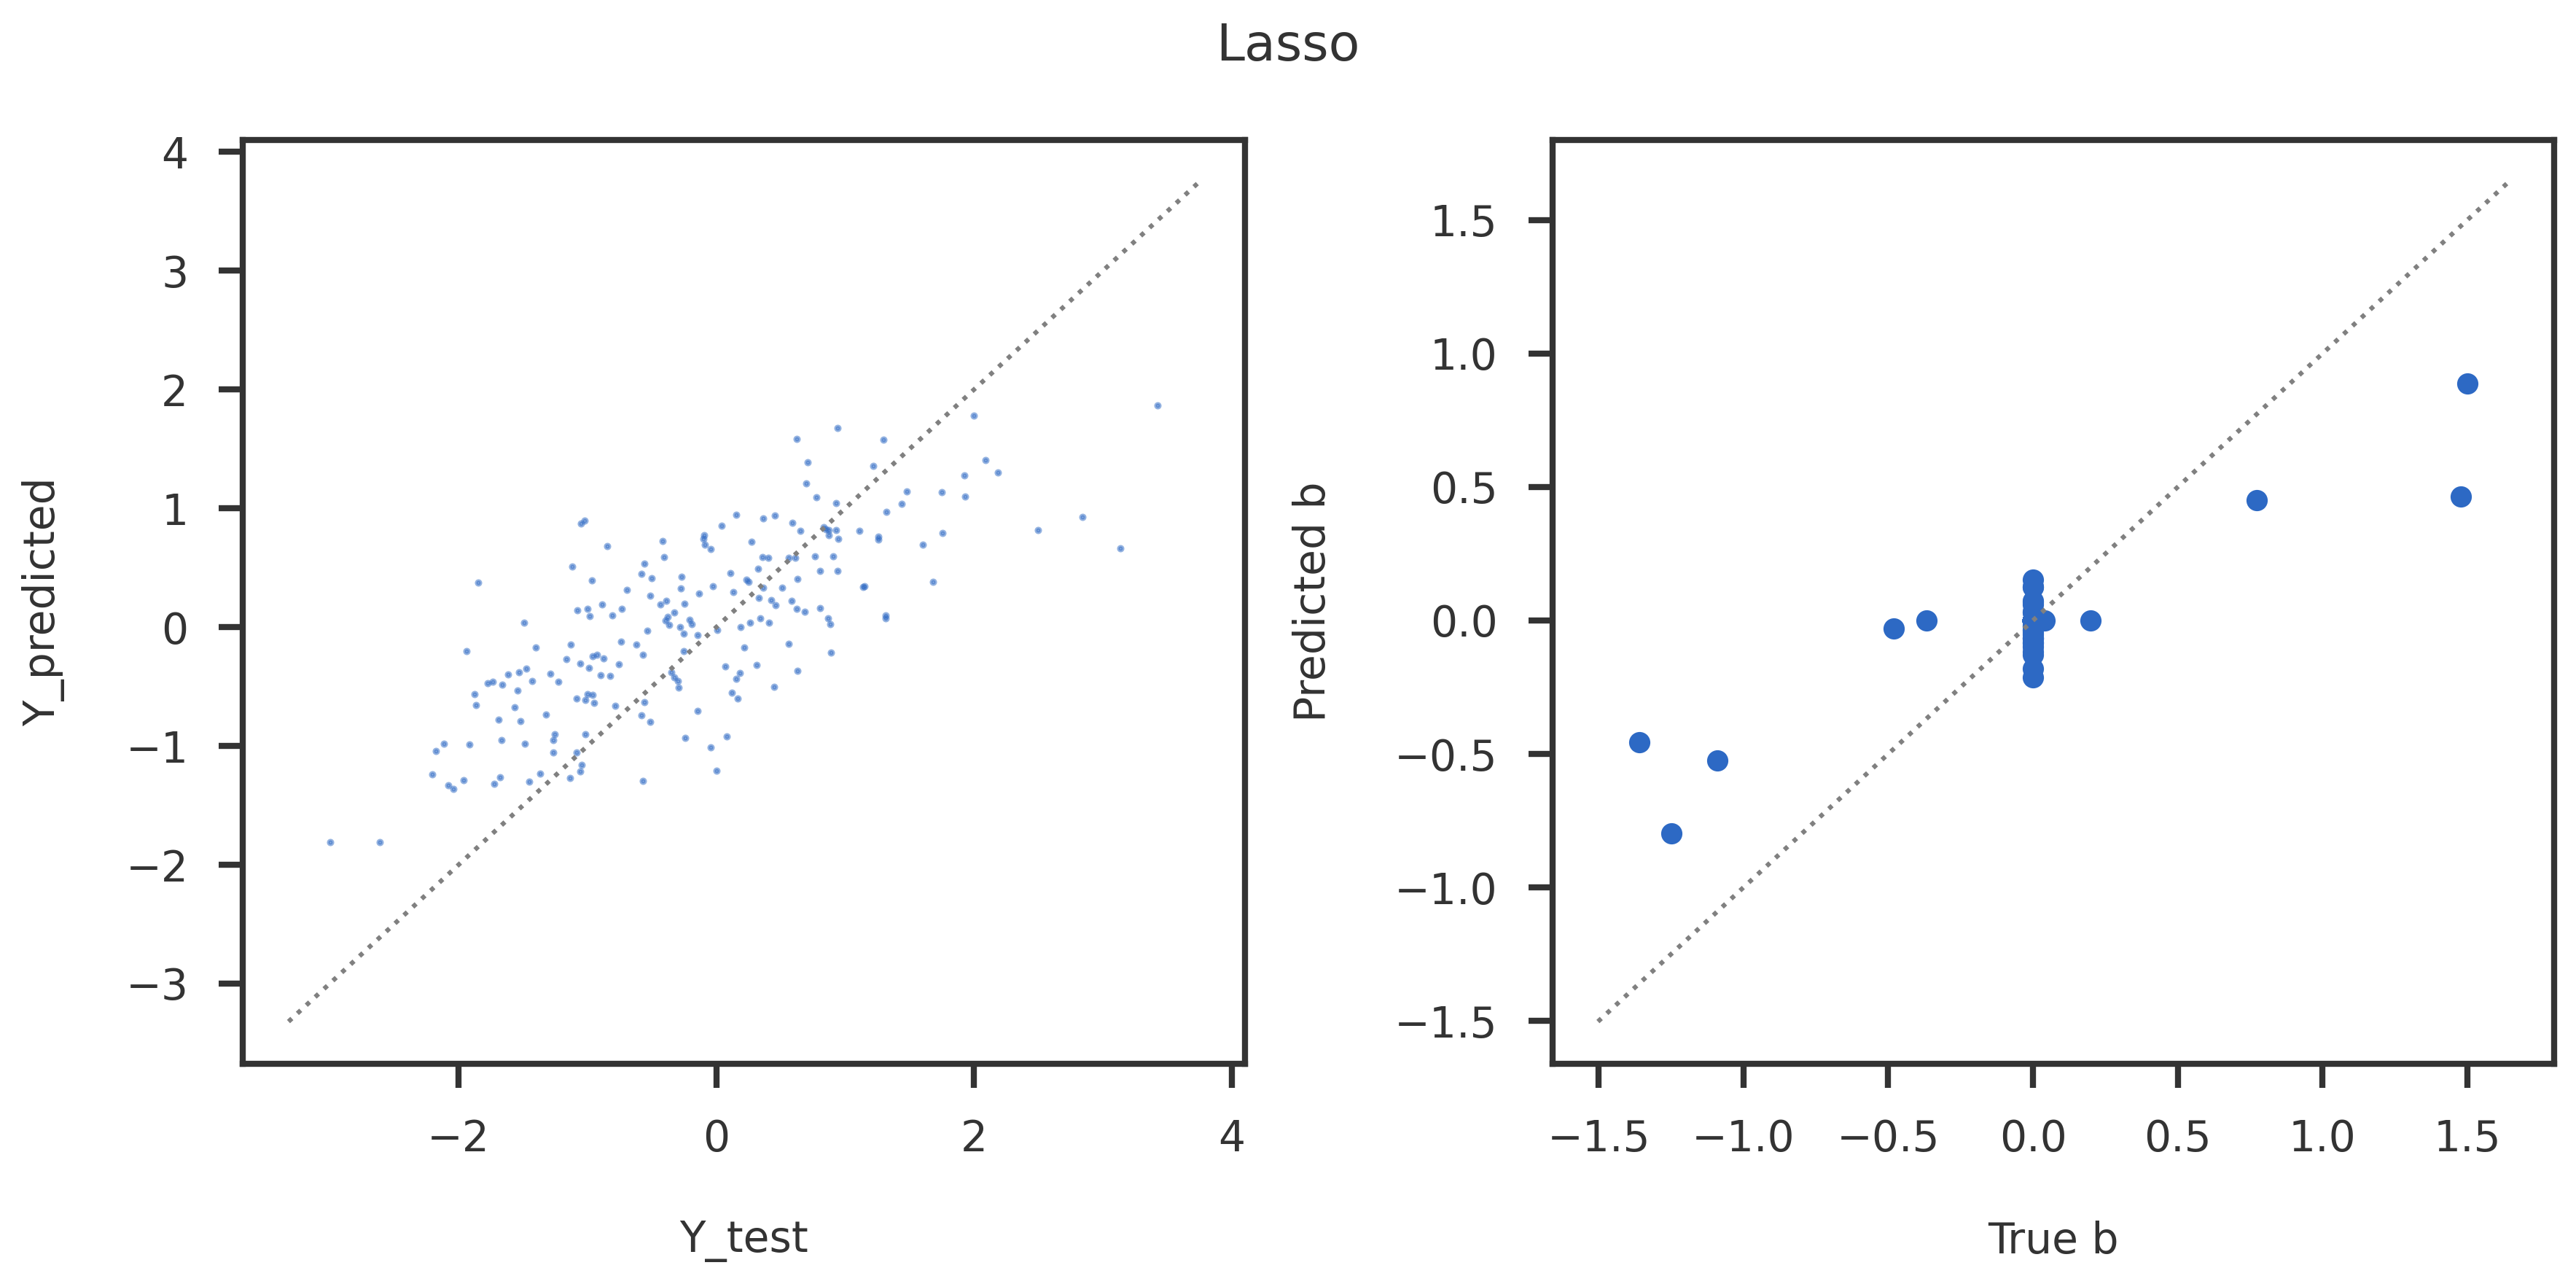

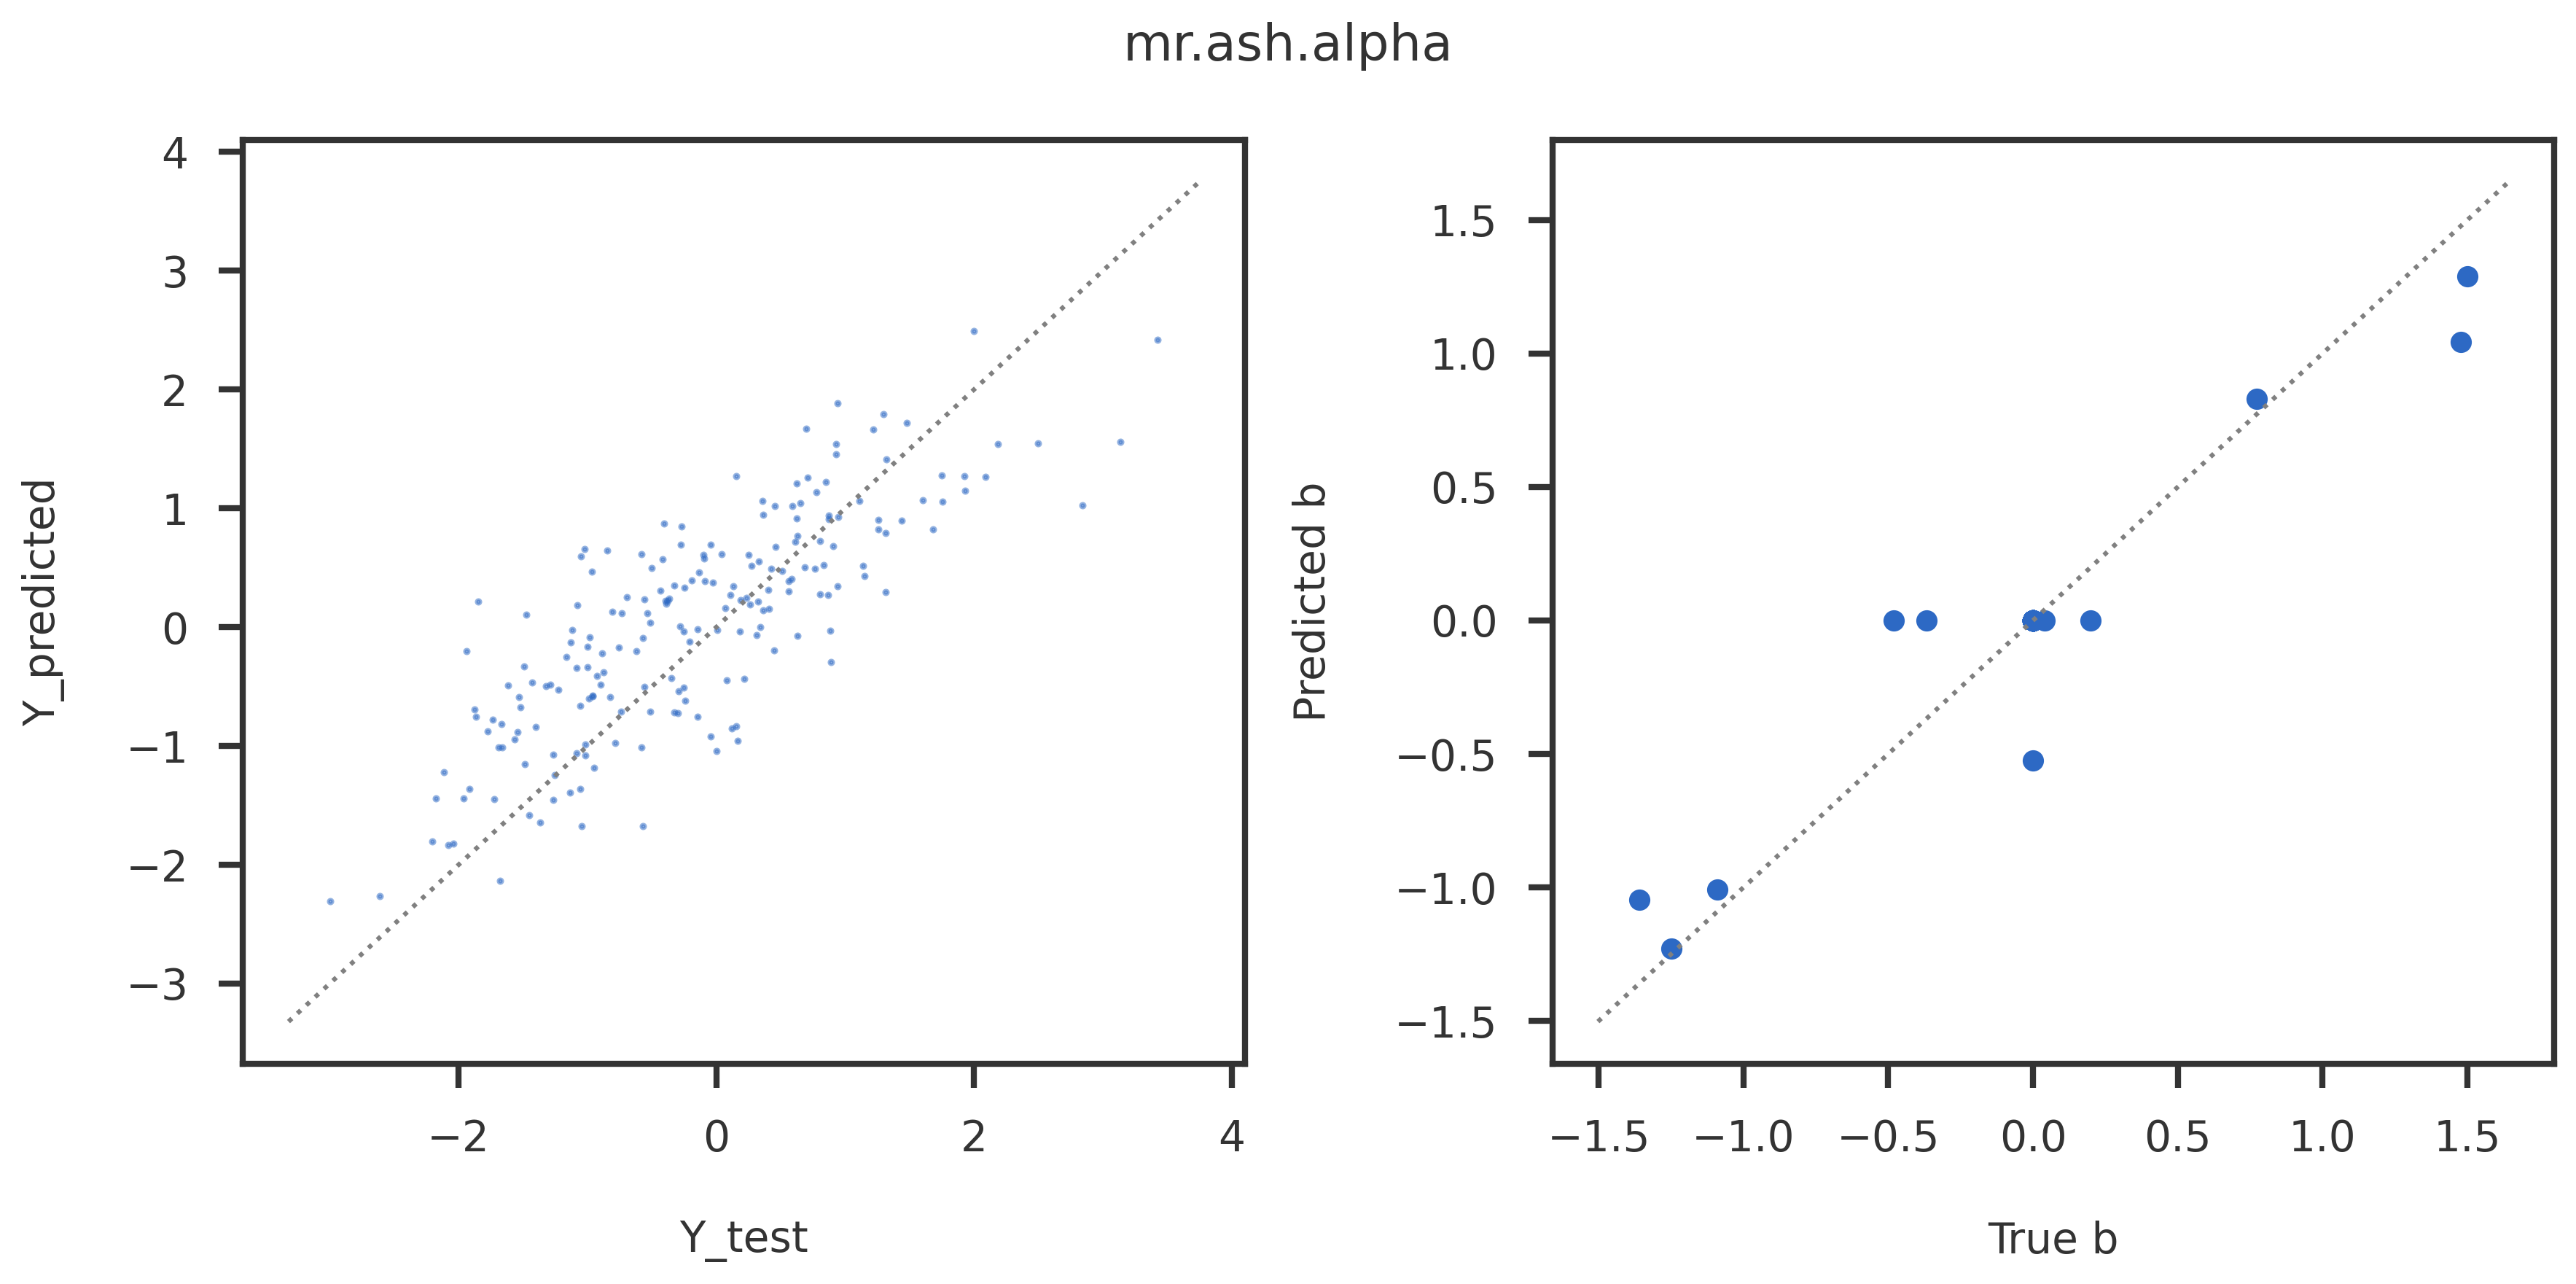

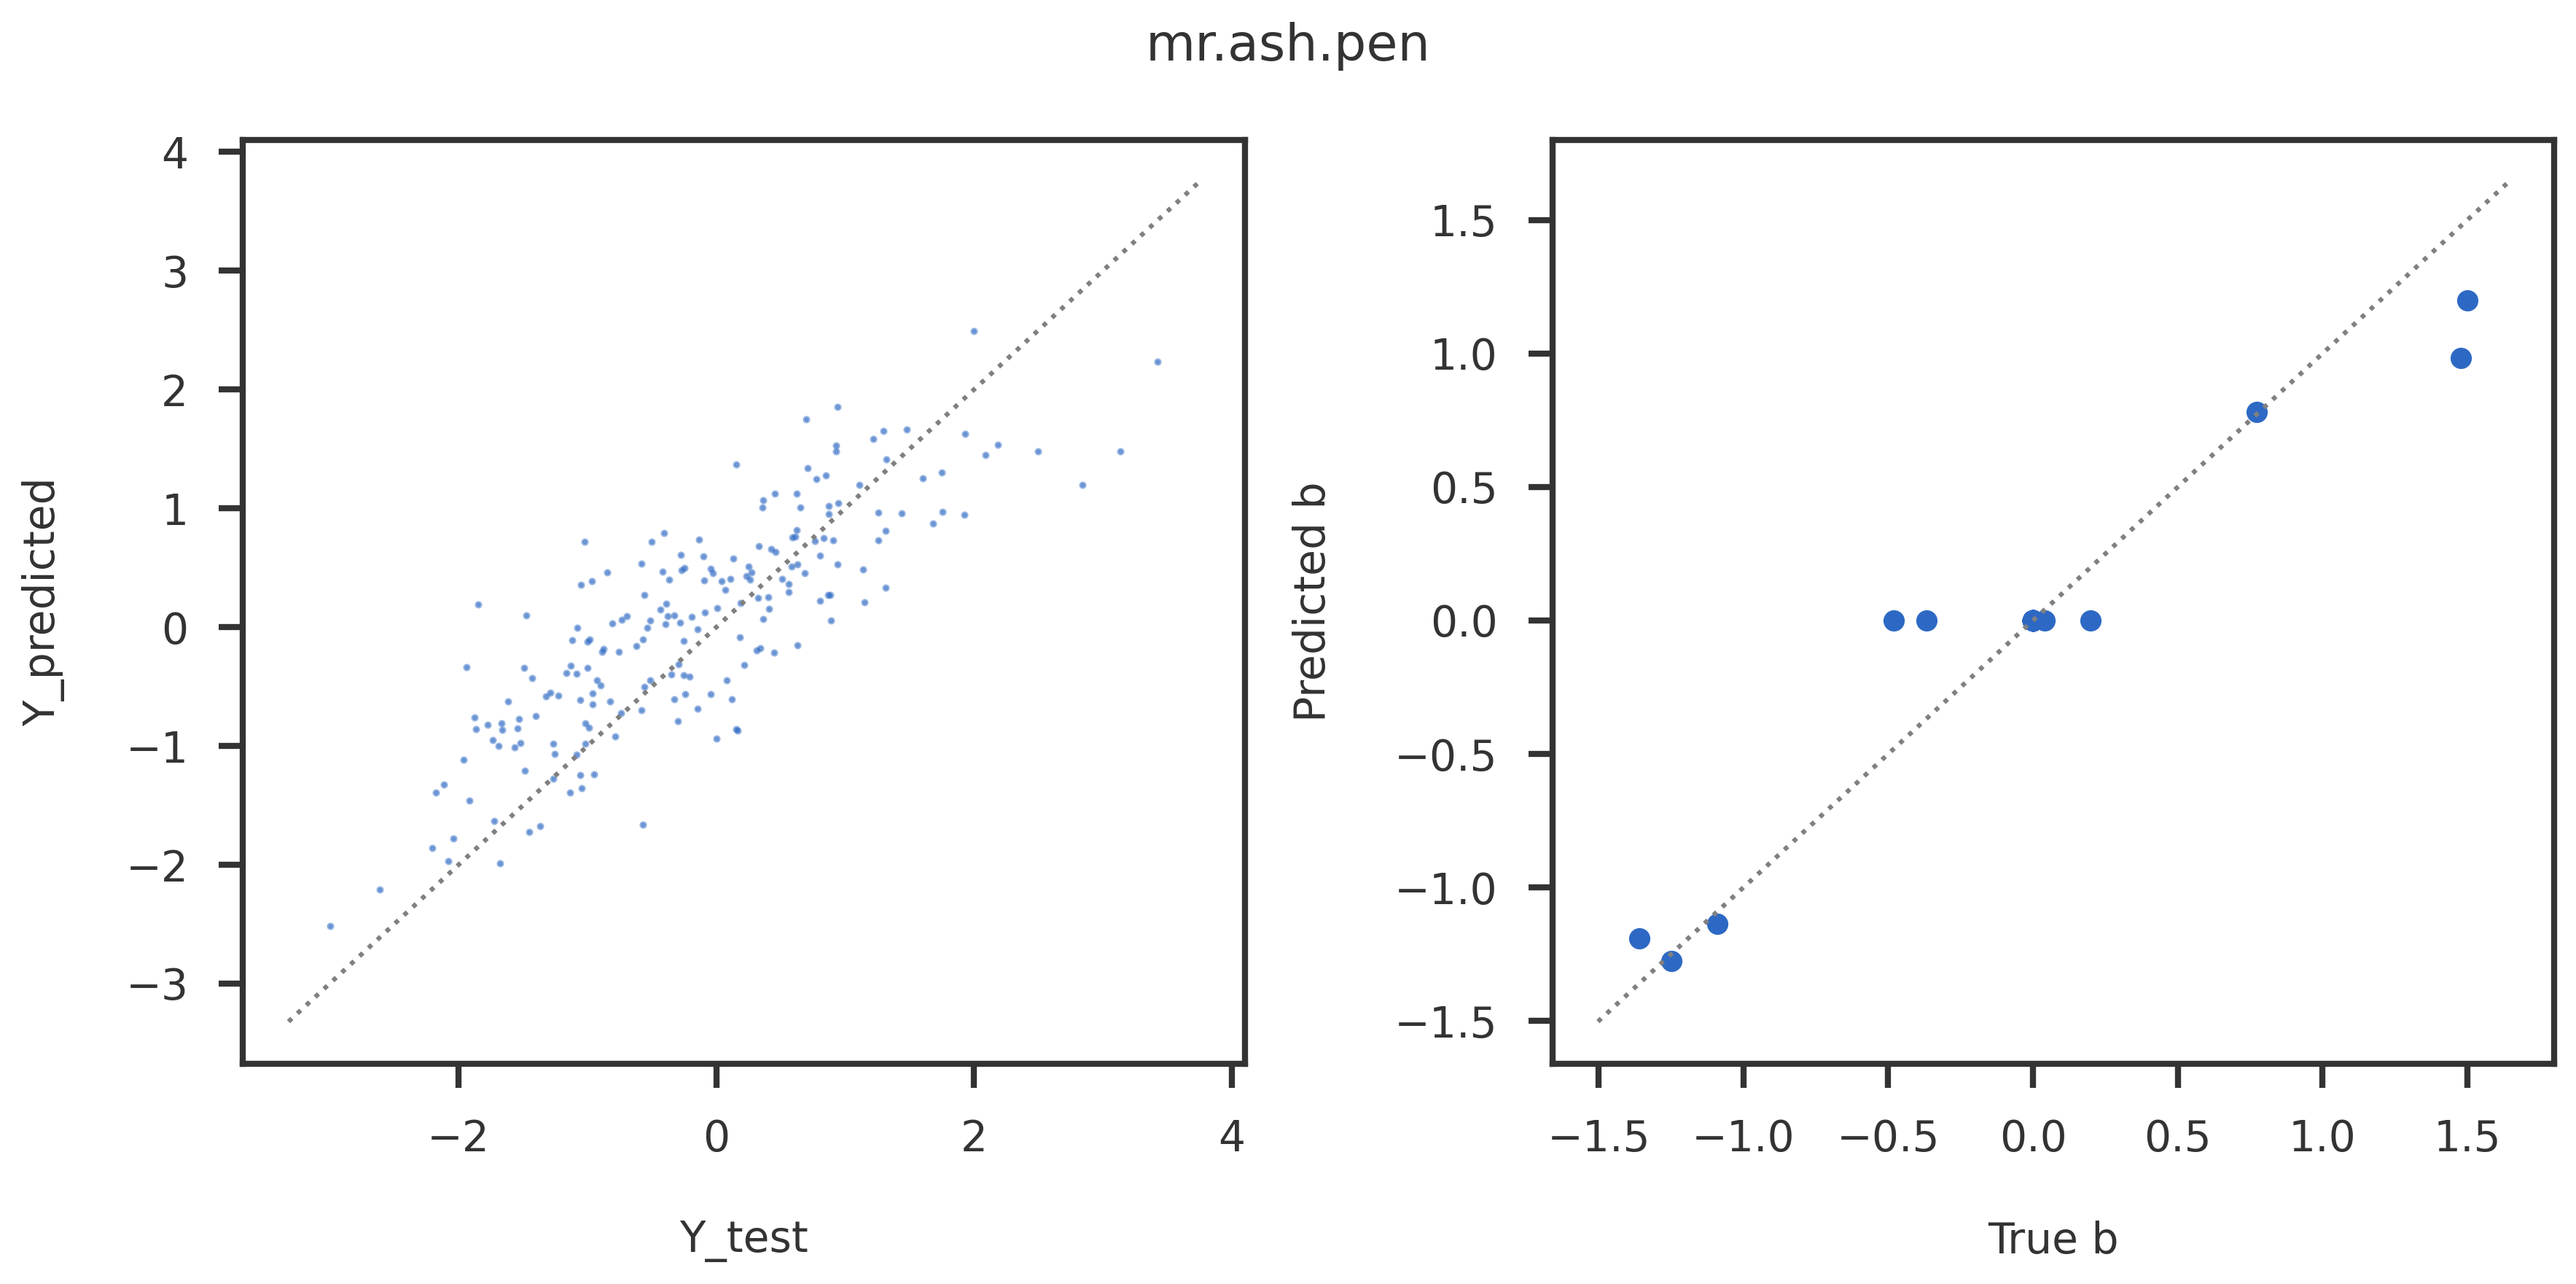

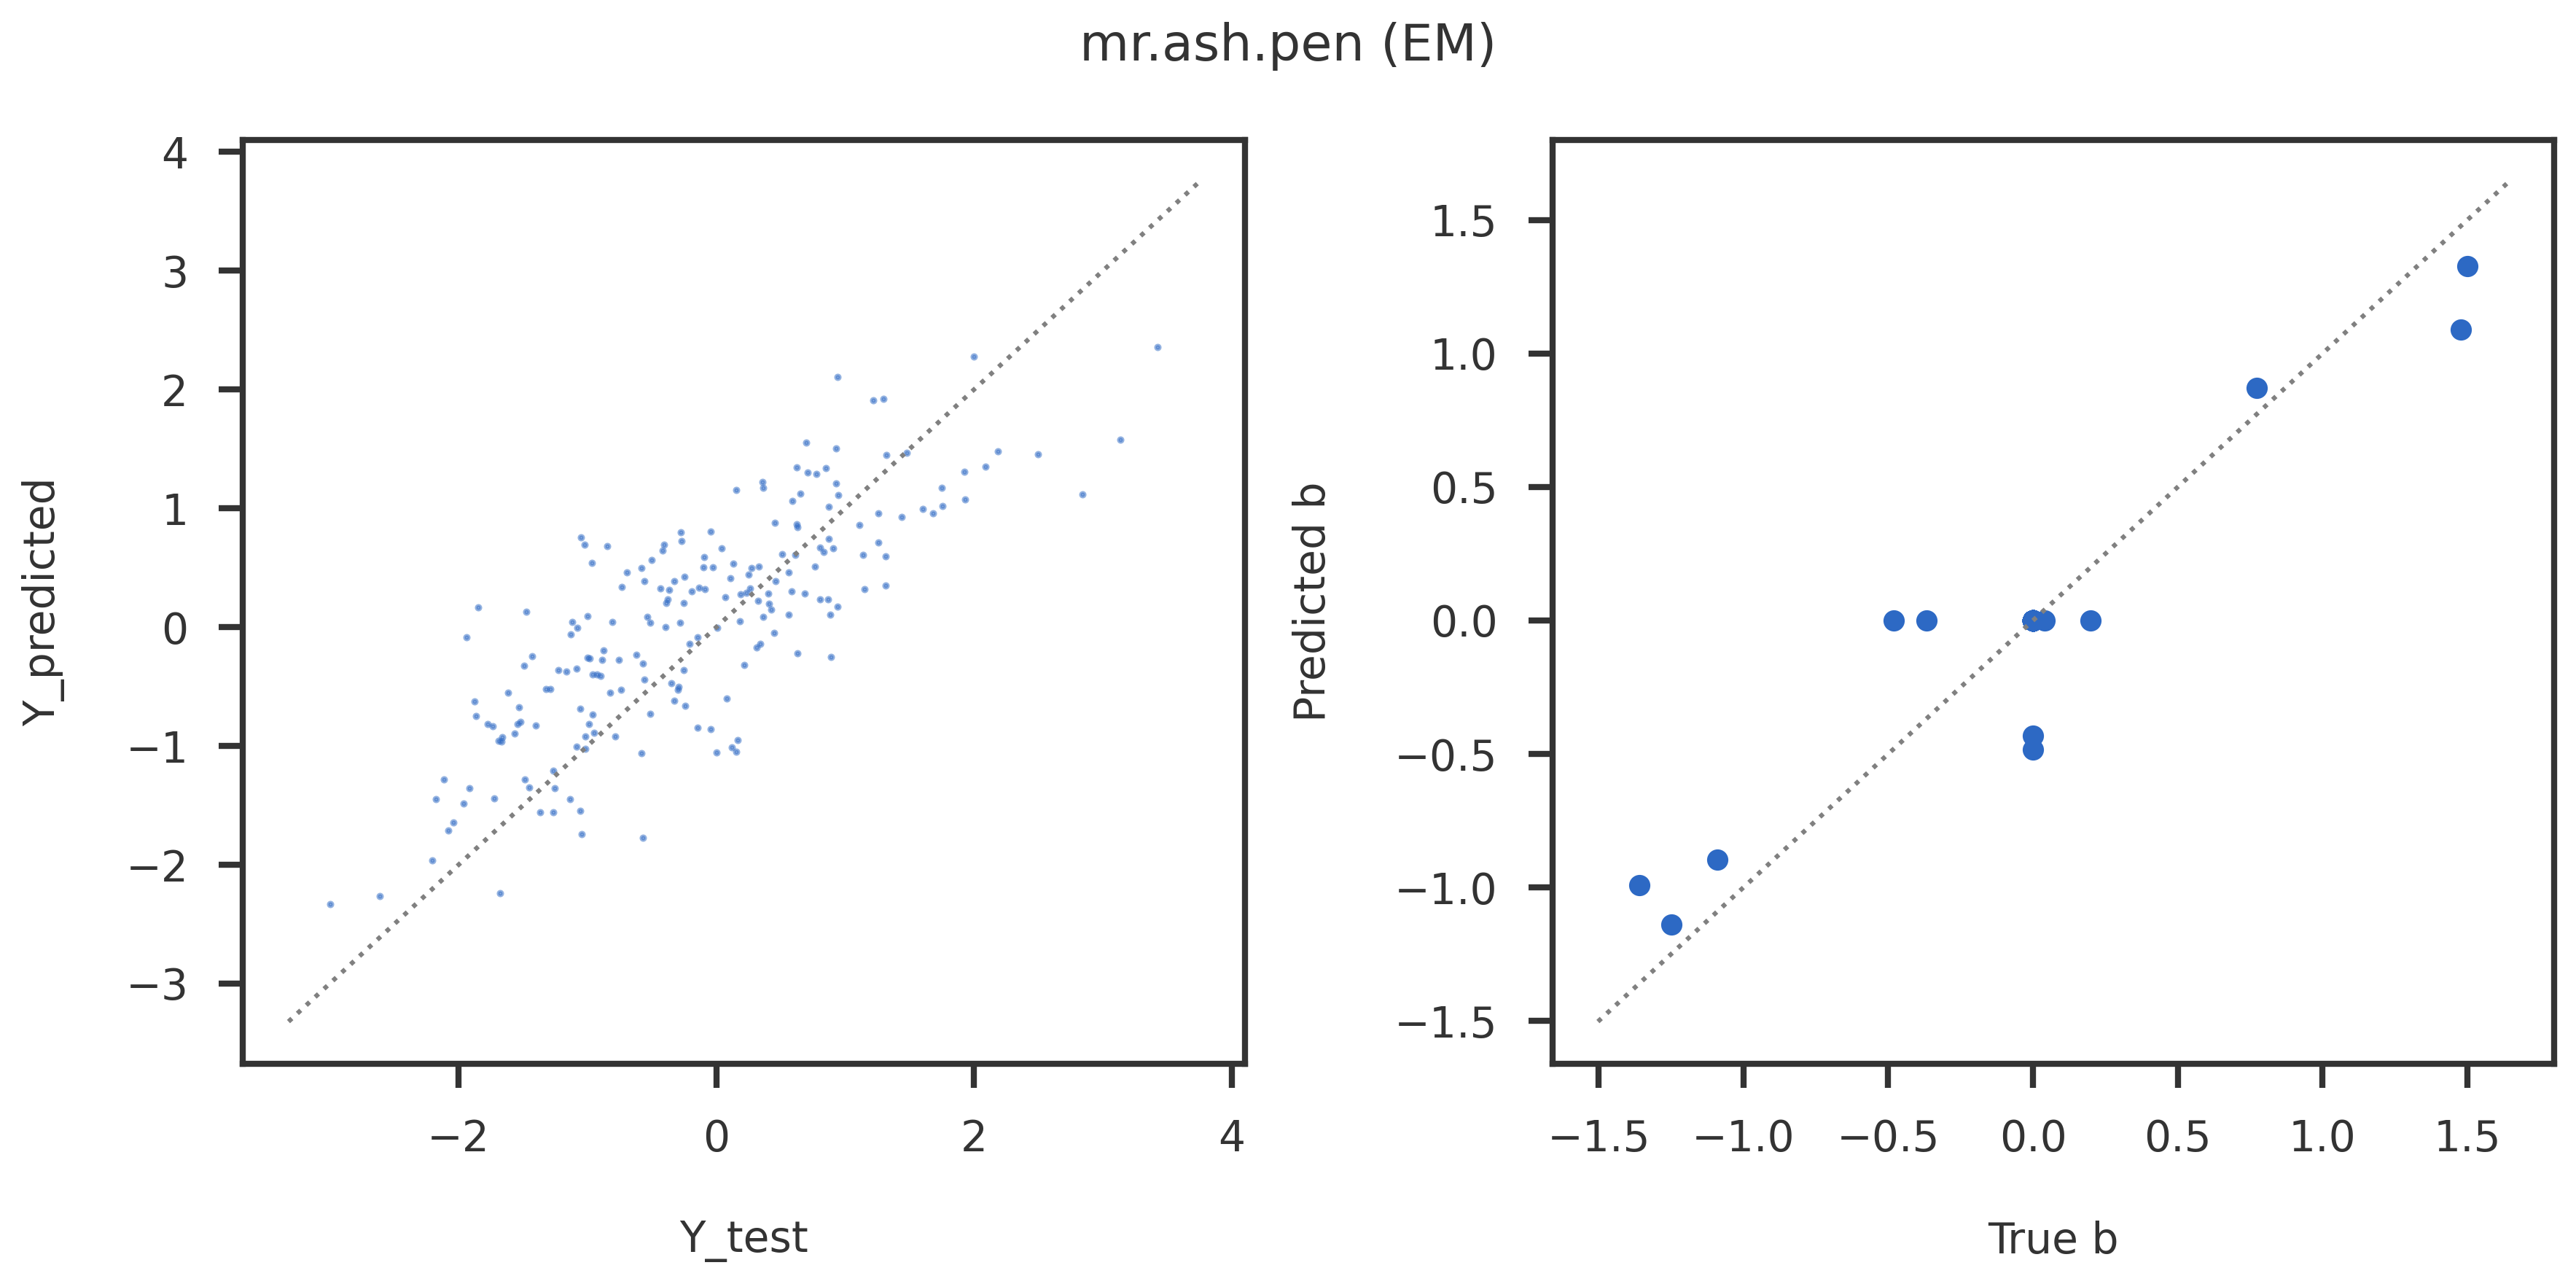

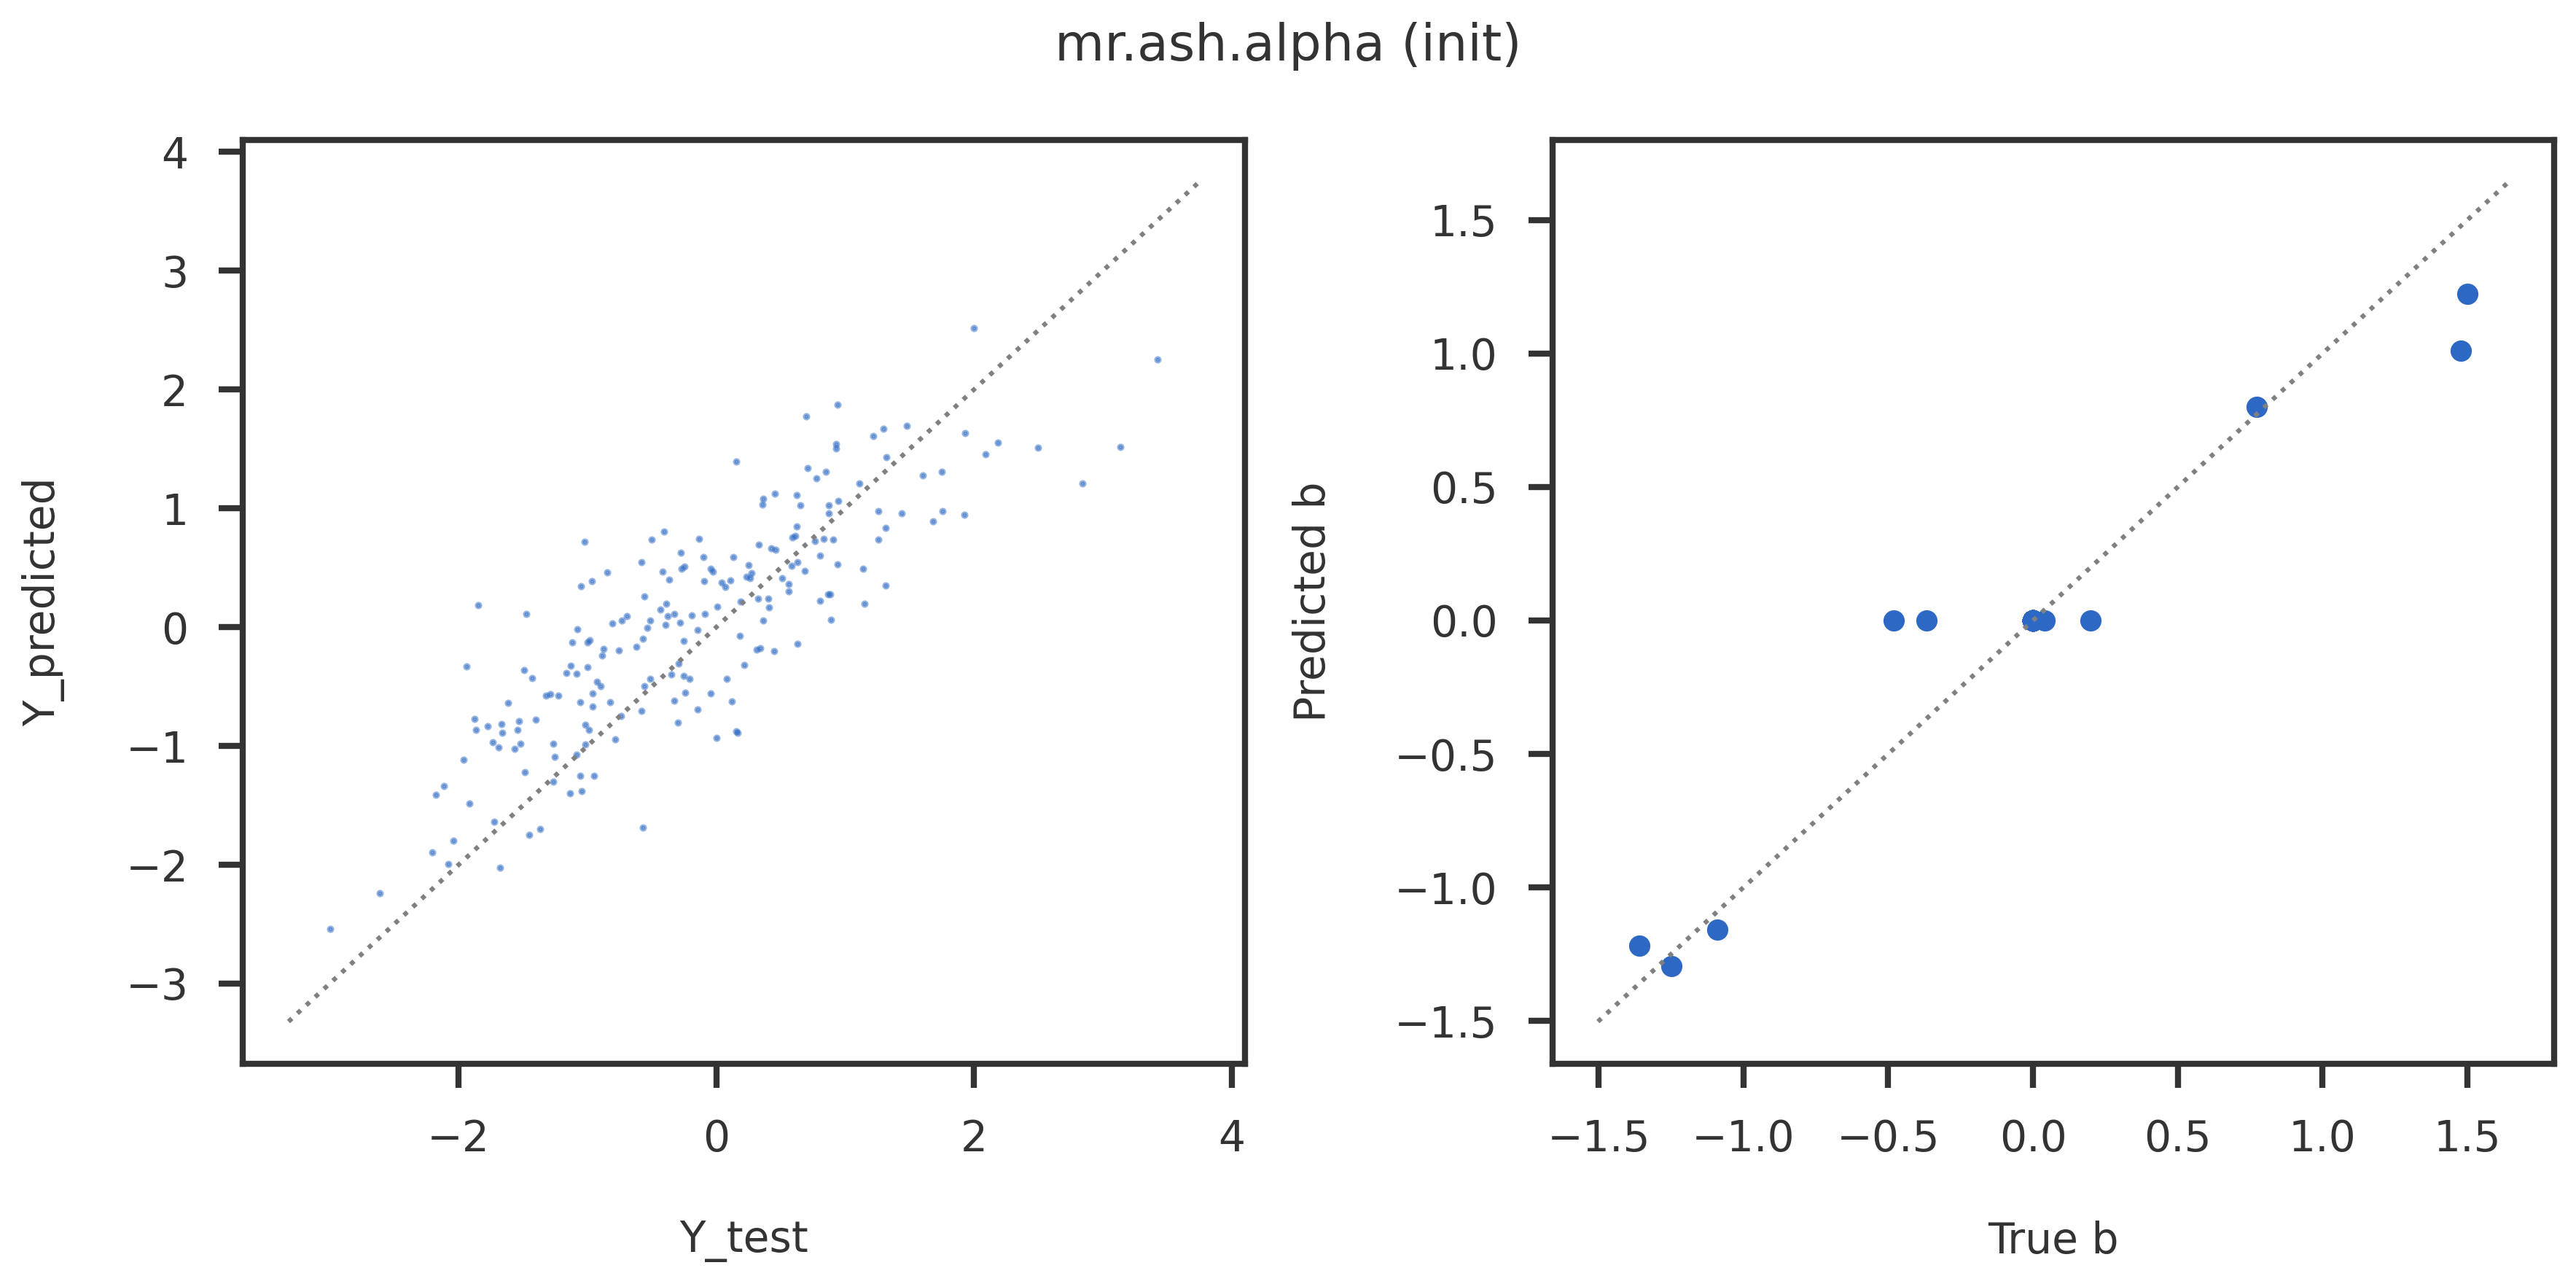

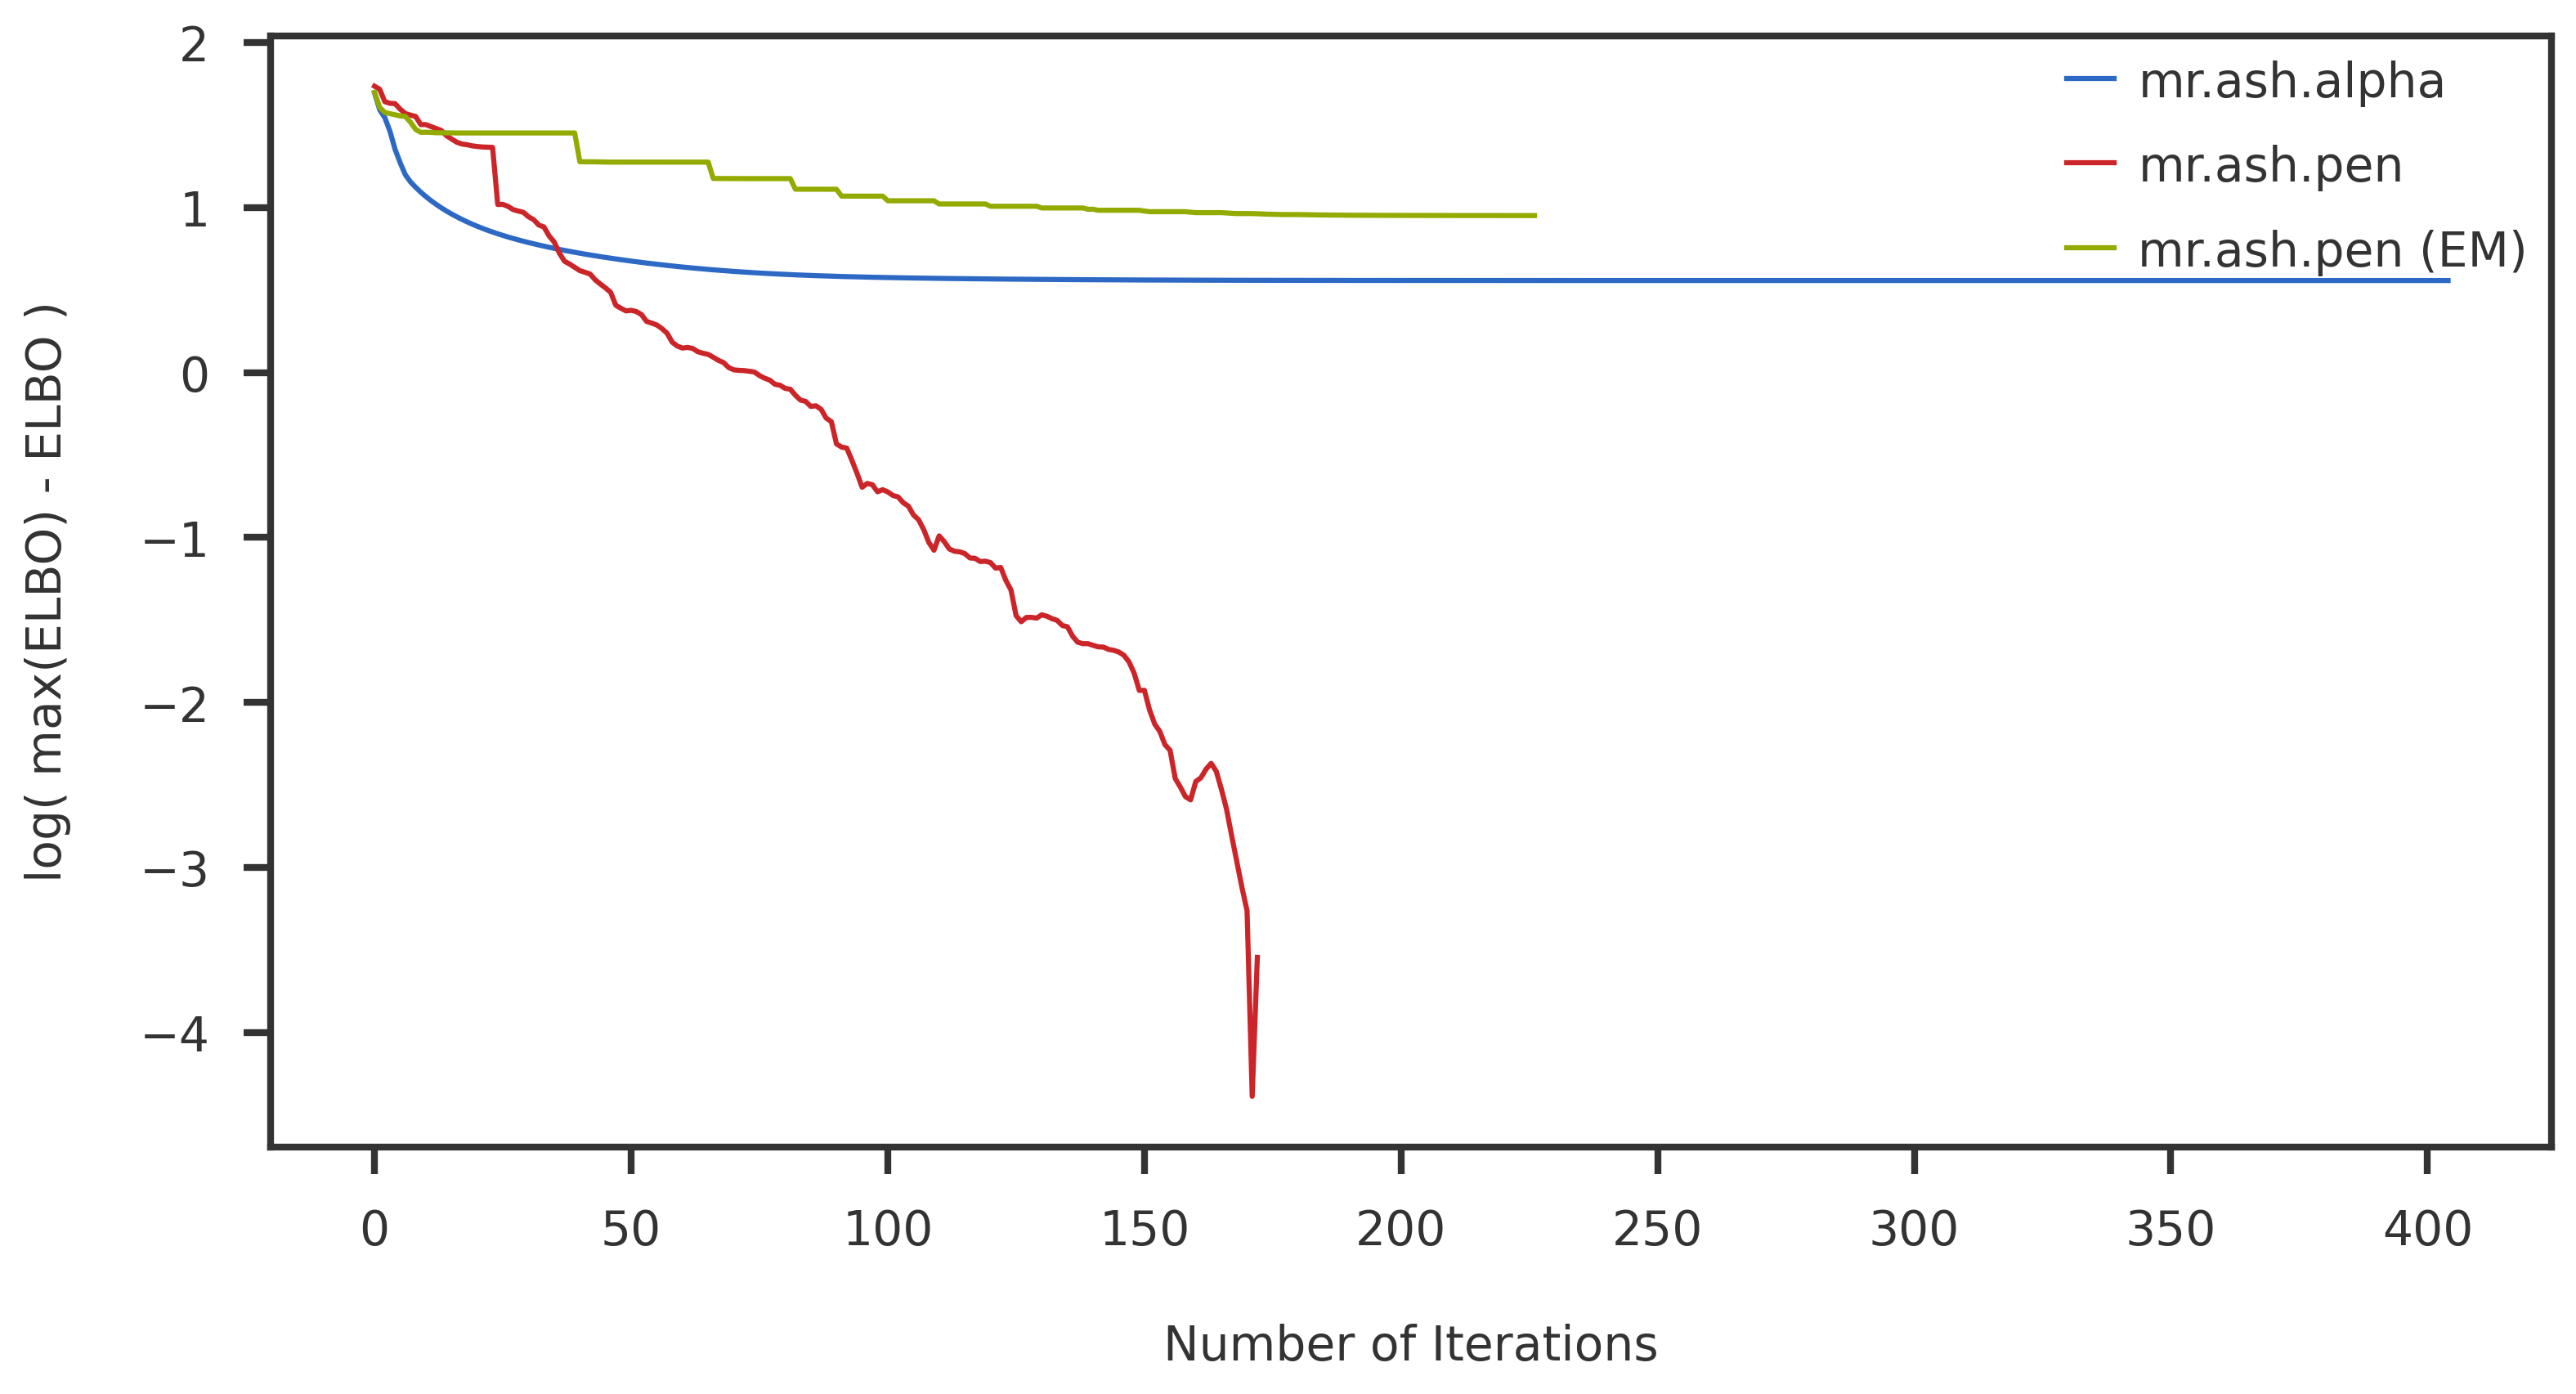

In [38]:
#collapse-hide

'''
Plot
'''
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [34]:
#collapse-hide

objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
df

sigma2        ELBO niter
True                 0.351862           -     -
mr.ash.alpha         0.438320   257.17008   324
mr.ash.pen           0.421410  261.469167   262
mr.ash.pen (EM)      0.411527  267.158922   238
mr.ash.alpha (init)  0.421411  261.465475    27

## 3. Trendfiltering with 20 changepoints

Another interesting and relatively harder problem is trendfiltering. Previously, I looked at many different cases of trendfiltering with mr.ash.alpha ([link](https://banskt.github.io/iridge-notes/2021/04/12/changepoint-estimation-adaptive-splines.html)). For the zero-th order trendfiltering ($k = 0$), I found that Mr.ASH performance becomes worse with increasing the number of changepoints, $s$. Here, I show an example with $s = 20$.

In [10]:
#collapse-hide

n = 200
p = 200
p_causal = 20
snr = 10
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                    k = 0, signal = 'gamma', seed = 100)
wk, sk = initialize_ash_prior(k, scale = 4)


'''
Lasso initialization
'''
genlasso_a0, genlasso_b, _ = R_genlasso.fit(X, y, order = 0)
genlasso_b = genlasso_b.reshape(-1,)
s2init = np.var(y - np.dot(X, genlasso_b) - genlasso_a0)
winit  = mix_gauss.emfit(genlasso_b, sk)
print ("Lasso initialization")

'''
mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True, 
                maxiter = 2000, tol = 1e-8)
plr_lbfgs.fit(X, y, sk, binit = genlasso_b, winit = wk, s2init = s2init)

'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, binit = genlasso_b, winit = wk, s2init = s2init, 
               maxiter = 200, qb_maxiter = 50, calculate_elbo = True)


'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = genlasso_b, winit = wk, s2init = s2init)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 

Lasso initialization
mr.ash.pen terminated at iteration 657.
mr.ash.pen (EM) terminated at iteration 2.
Mr.ASH terminated at iteration 523.
Mr.ASH terminated at iteration 745.


On the left panel I compare the predicted $\mathbf{y}_{\mathrm{test}}$ by the different methods (solid blue line) with the true $\mathbf{y}_{\mathrm{test}}$ (empty black circles). On the right panel, I compare the predicted coefficients (solid red circles) with their true values (empty black circles). The plot at the bottom shows the convergence of the different methods against the number of iteration.

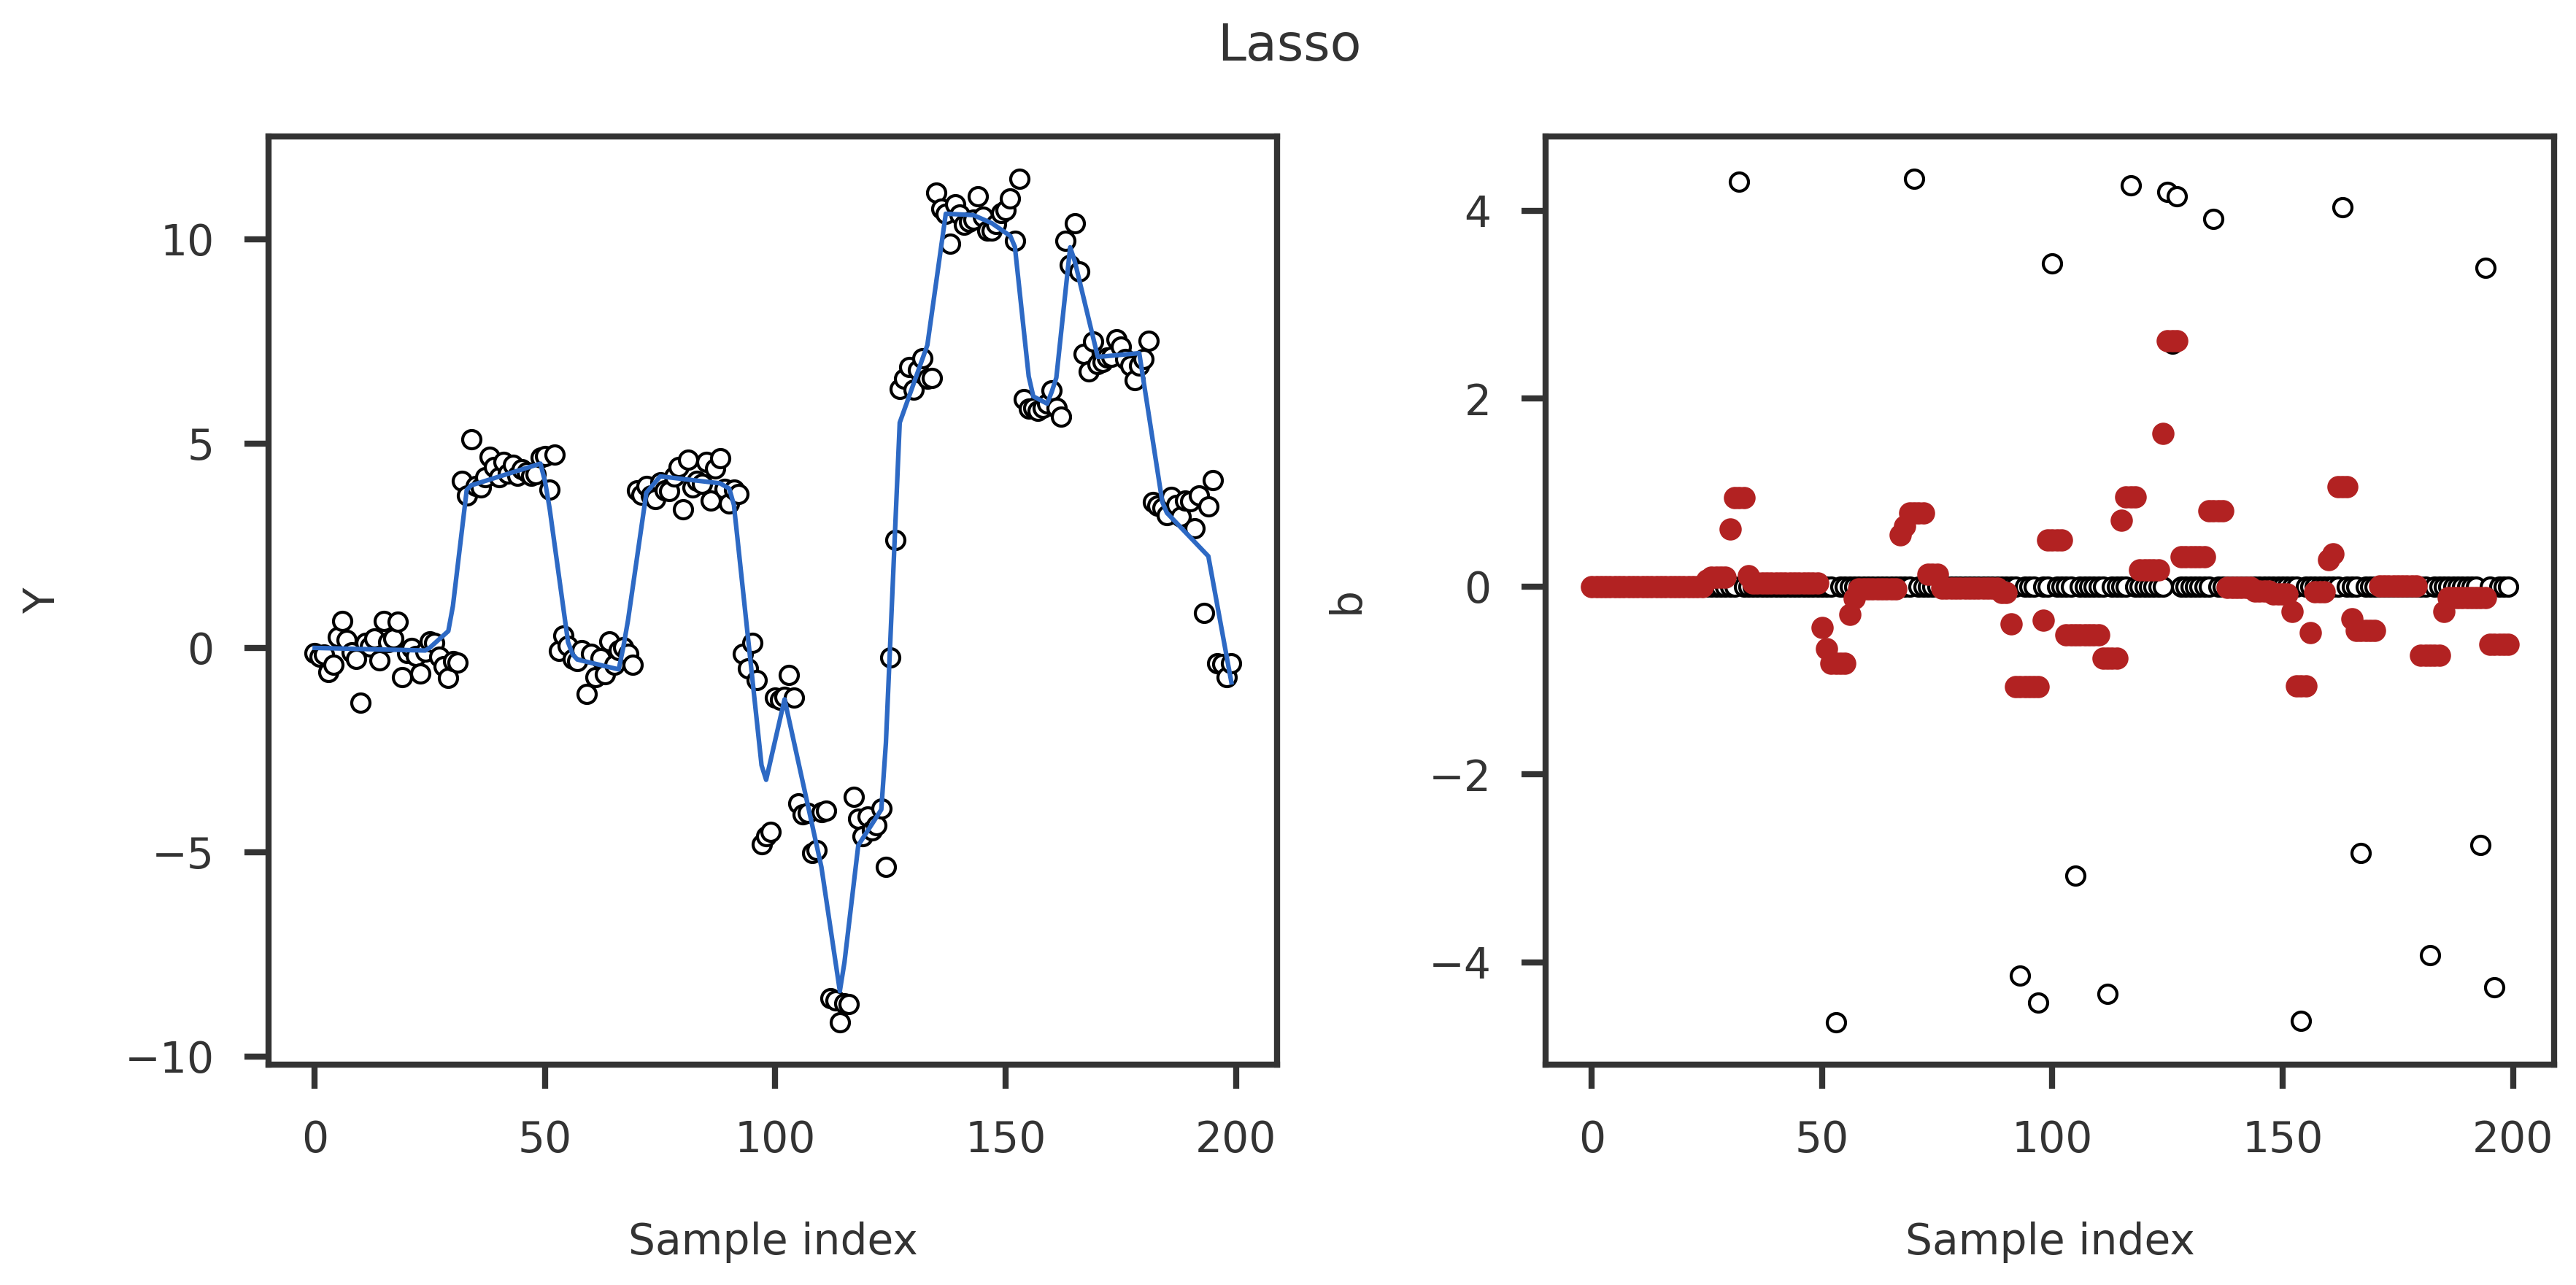

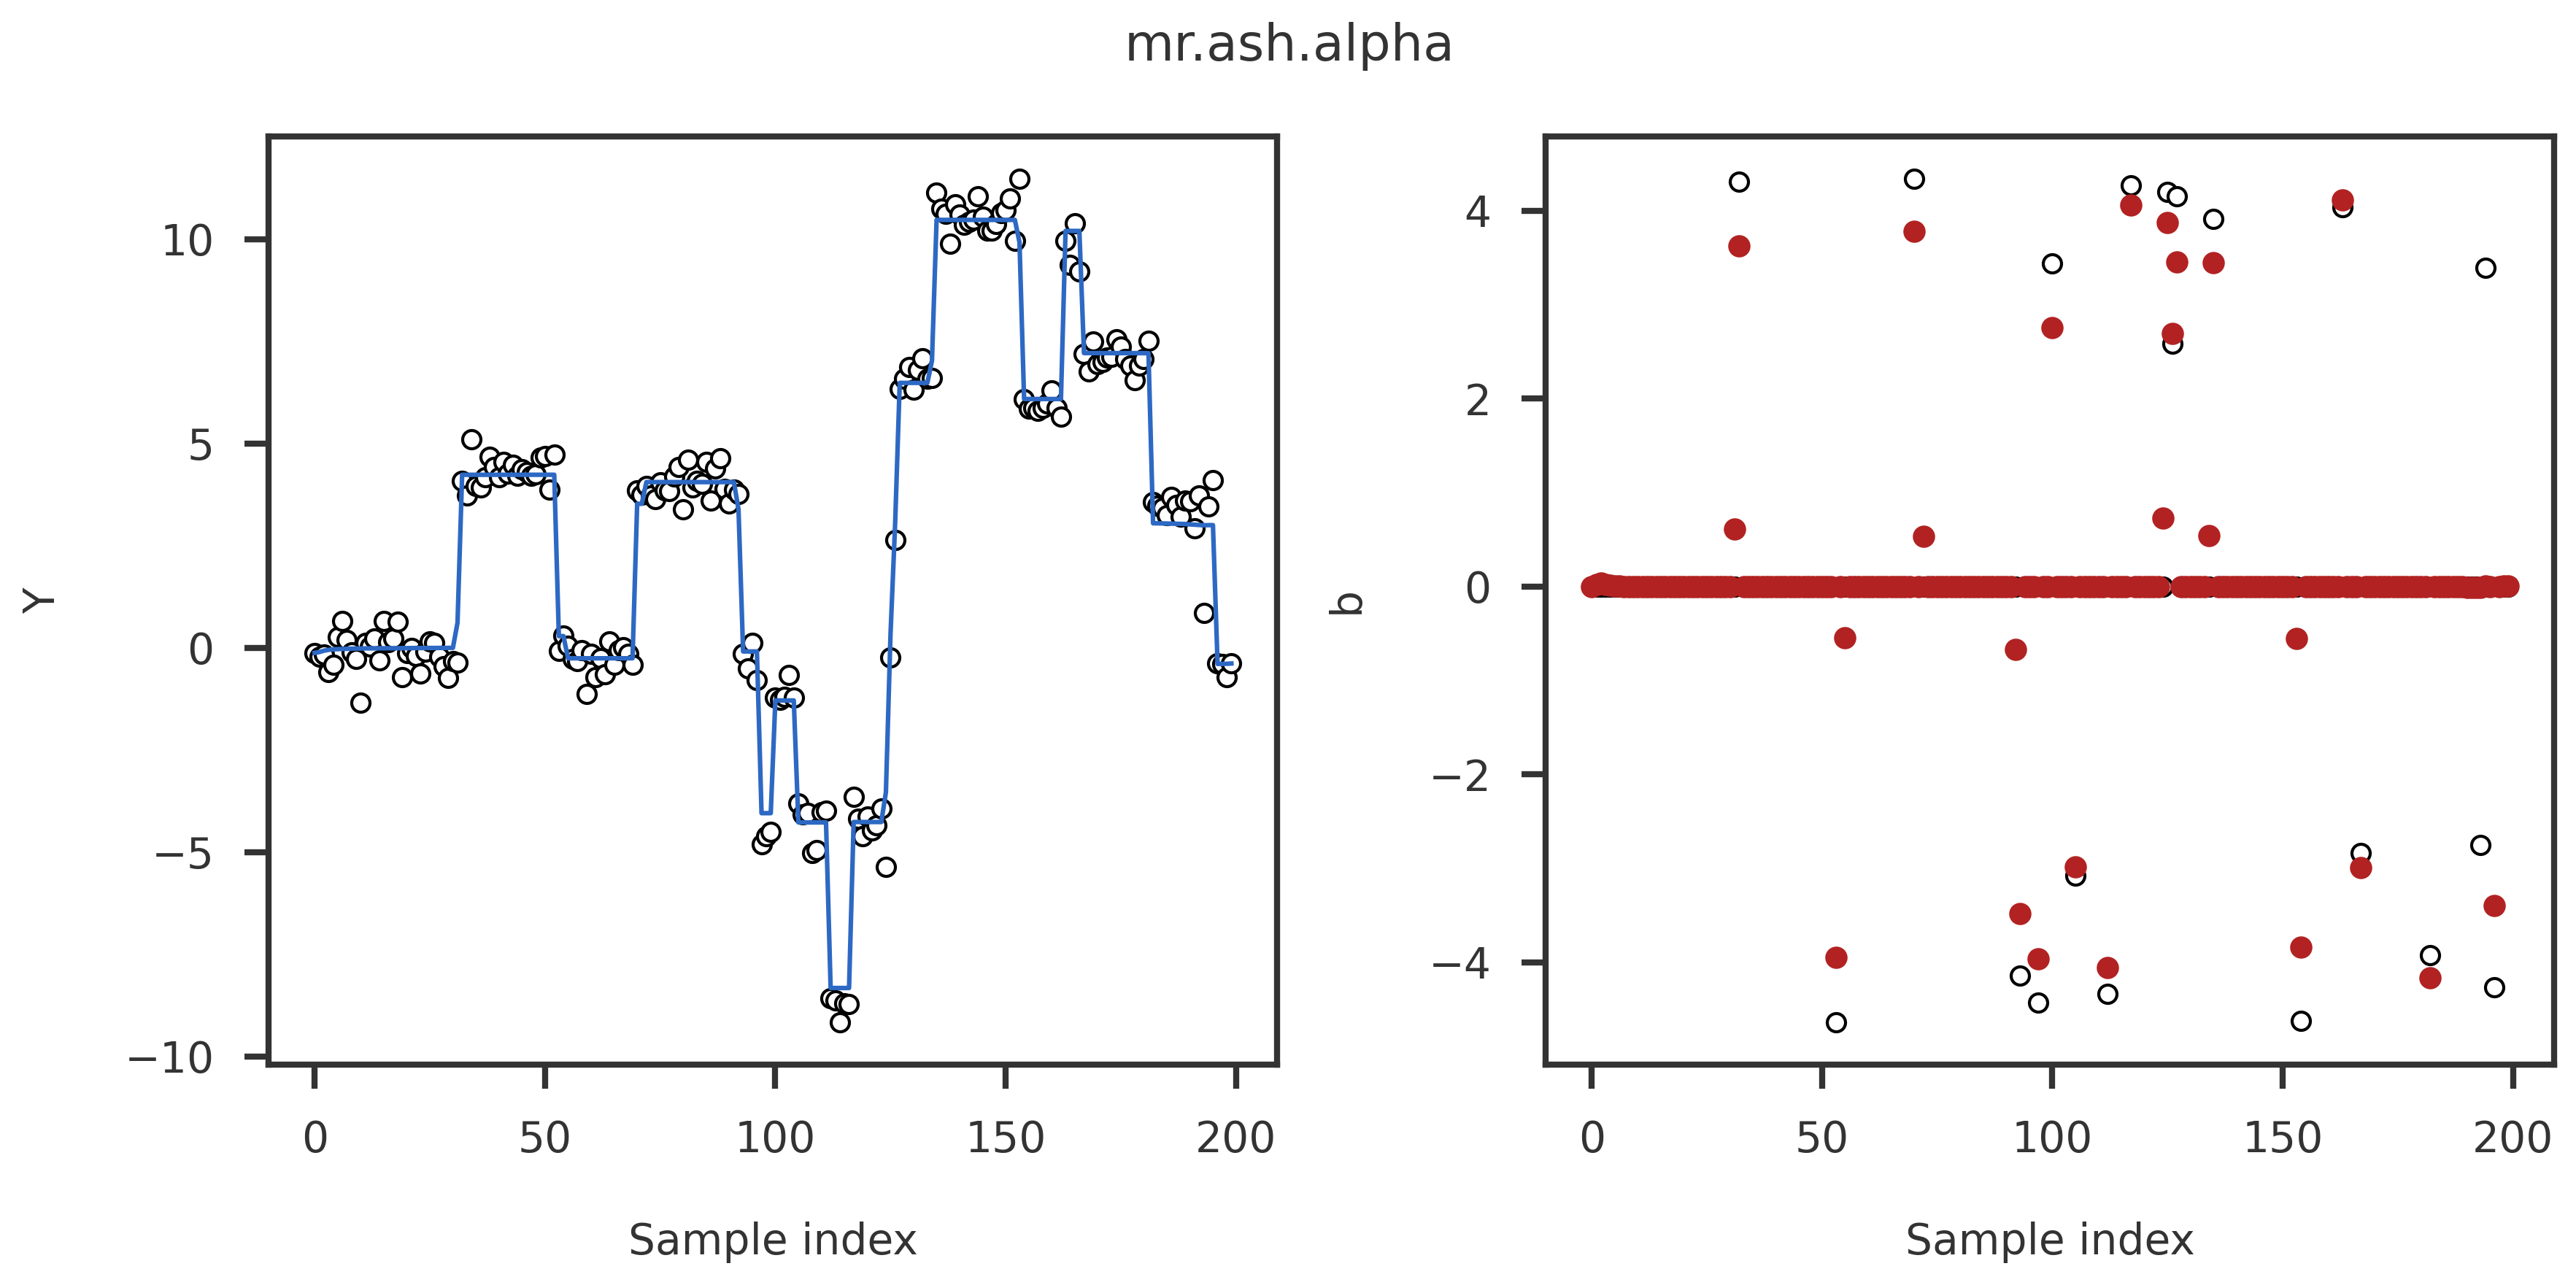

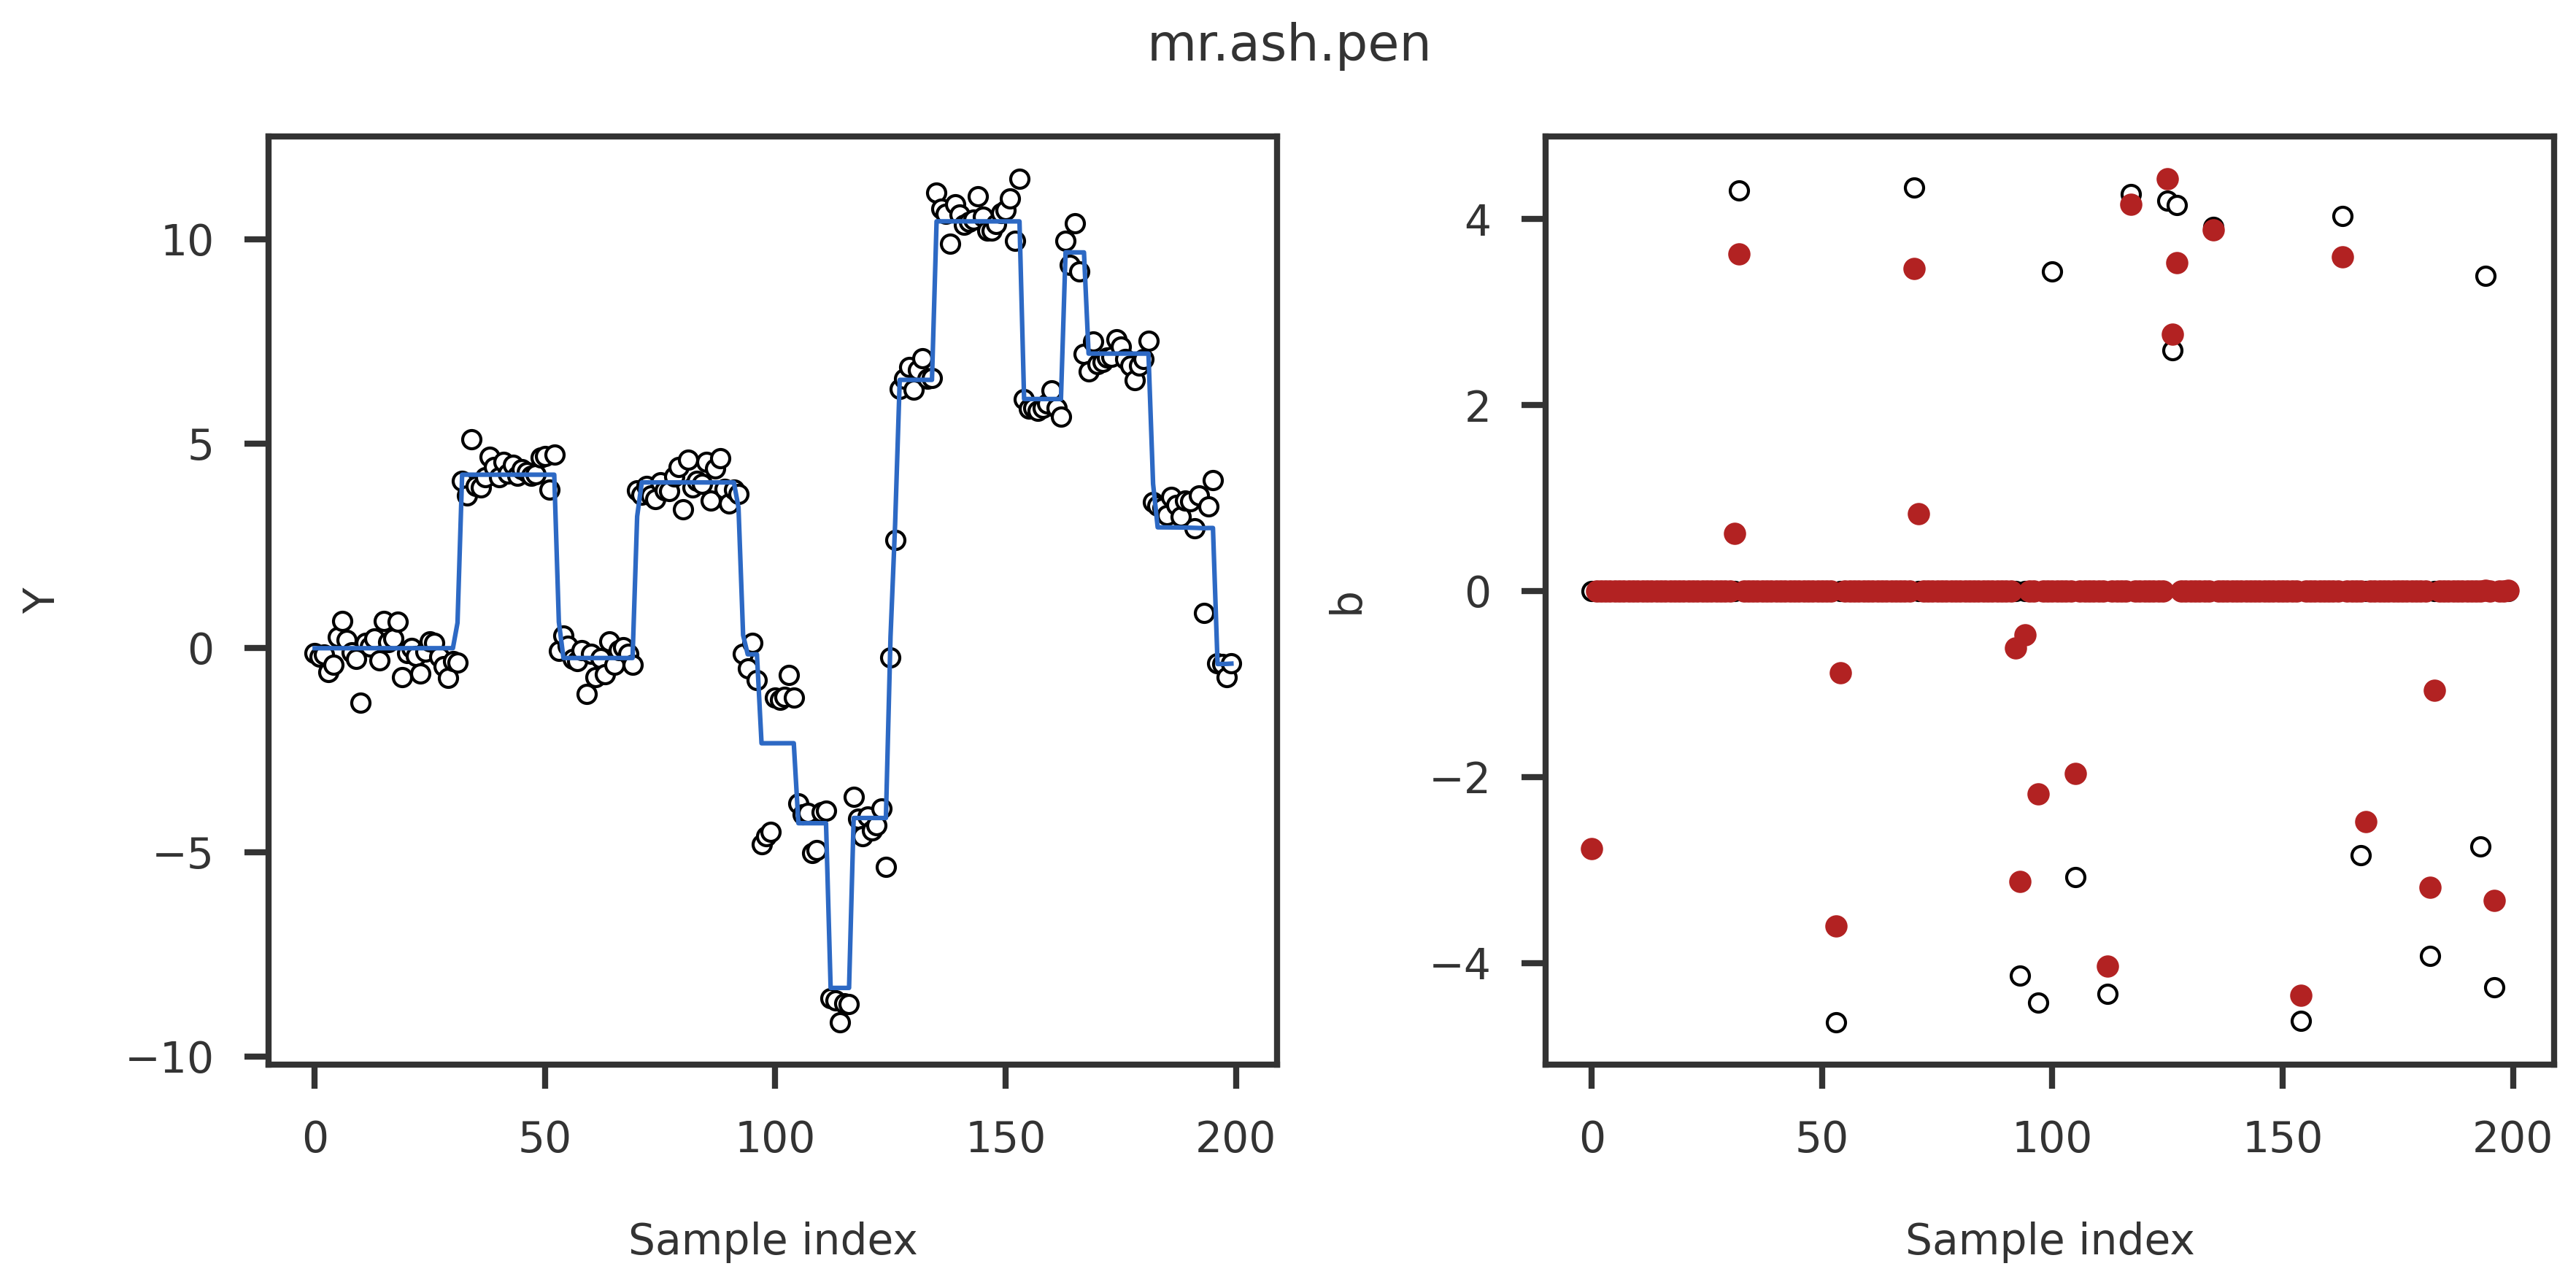

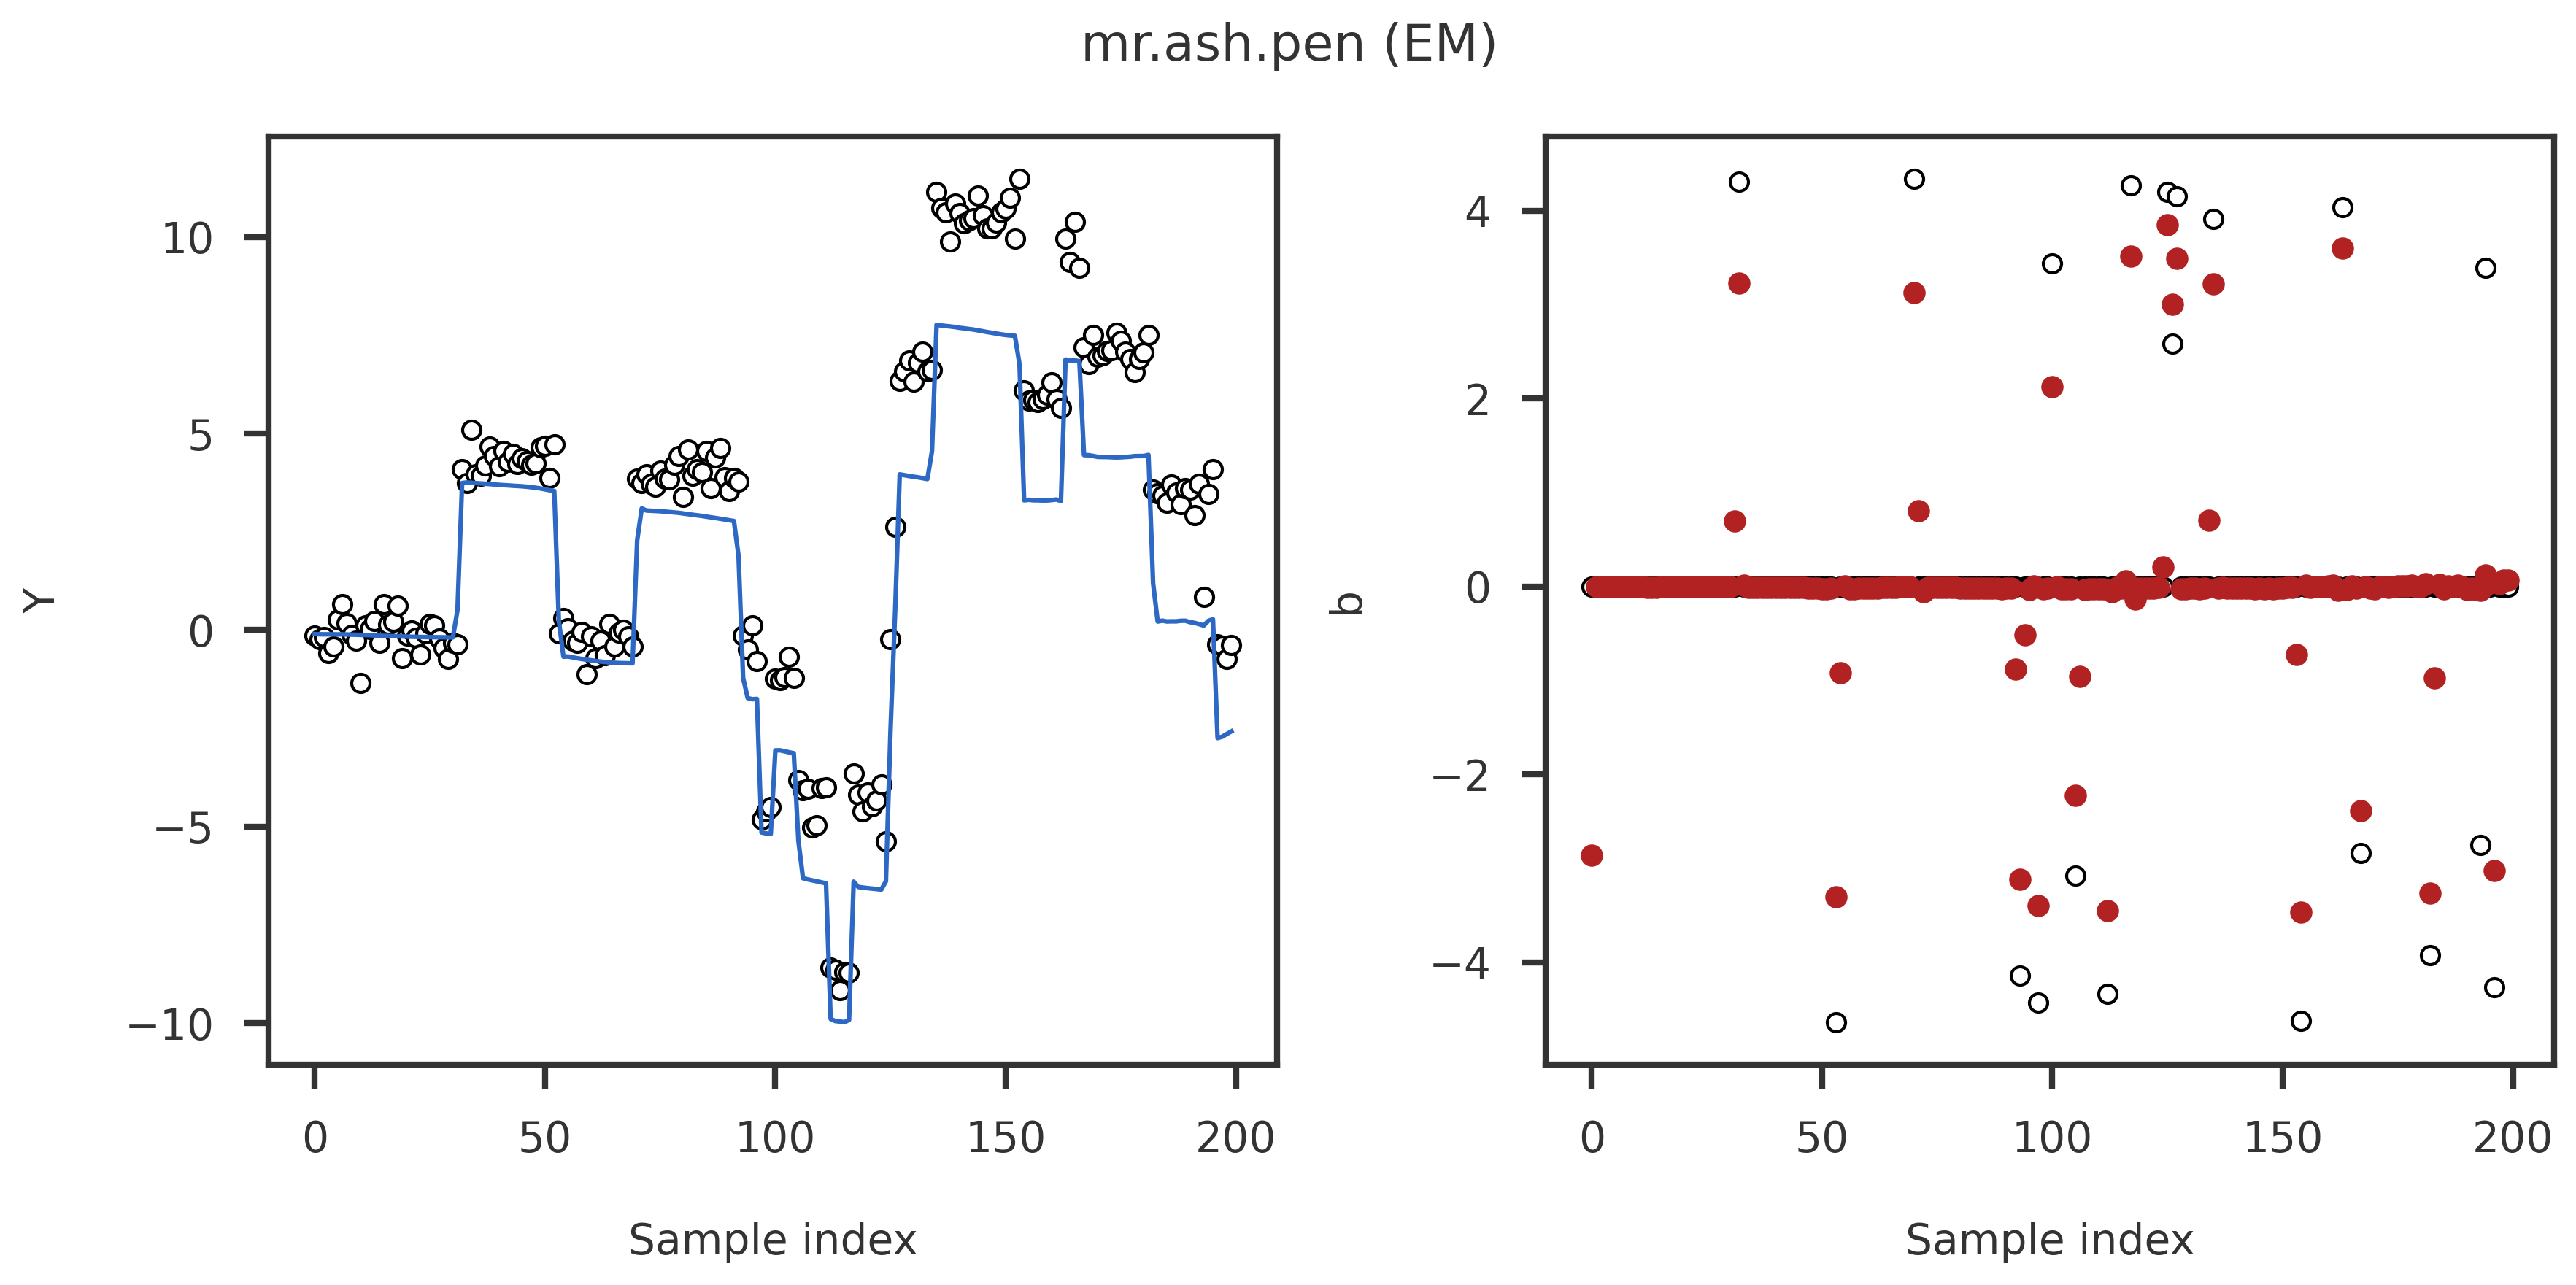

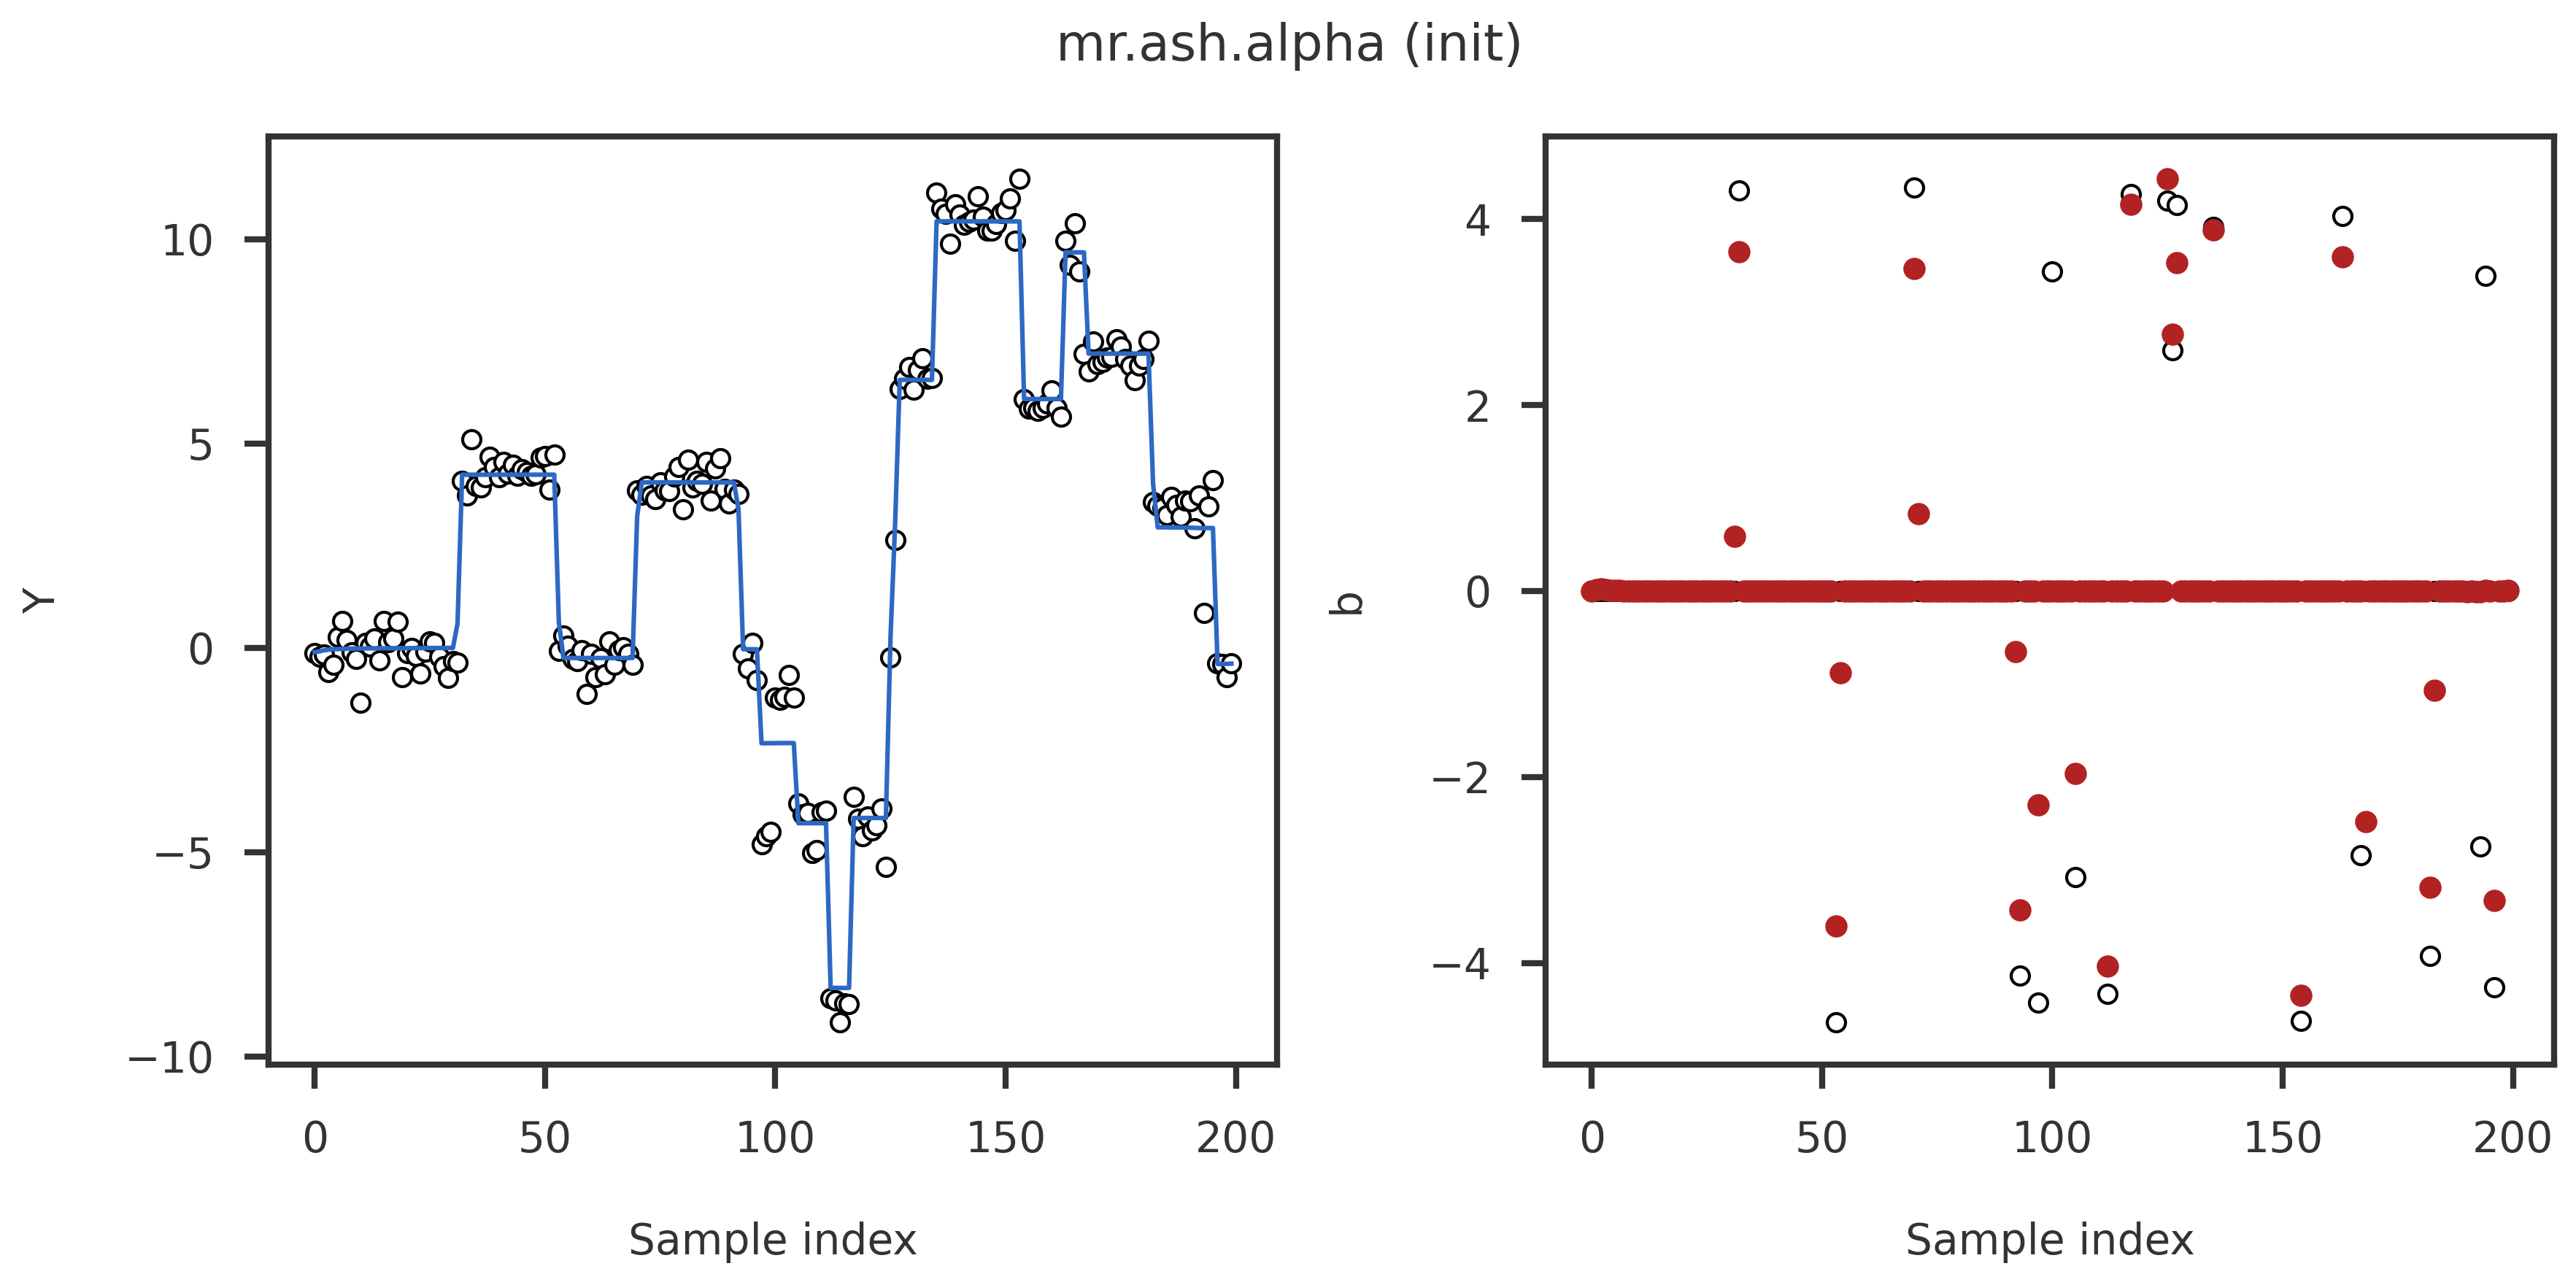

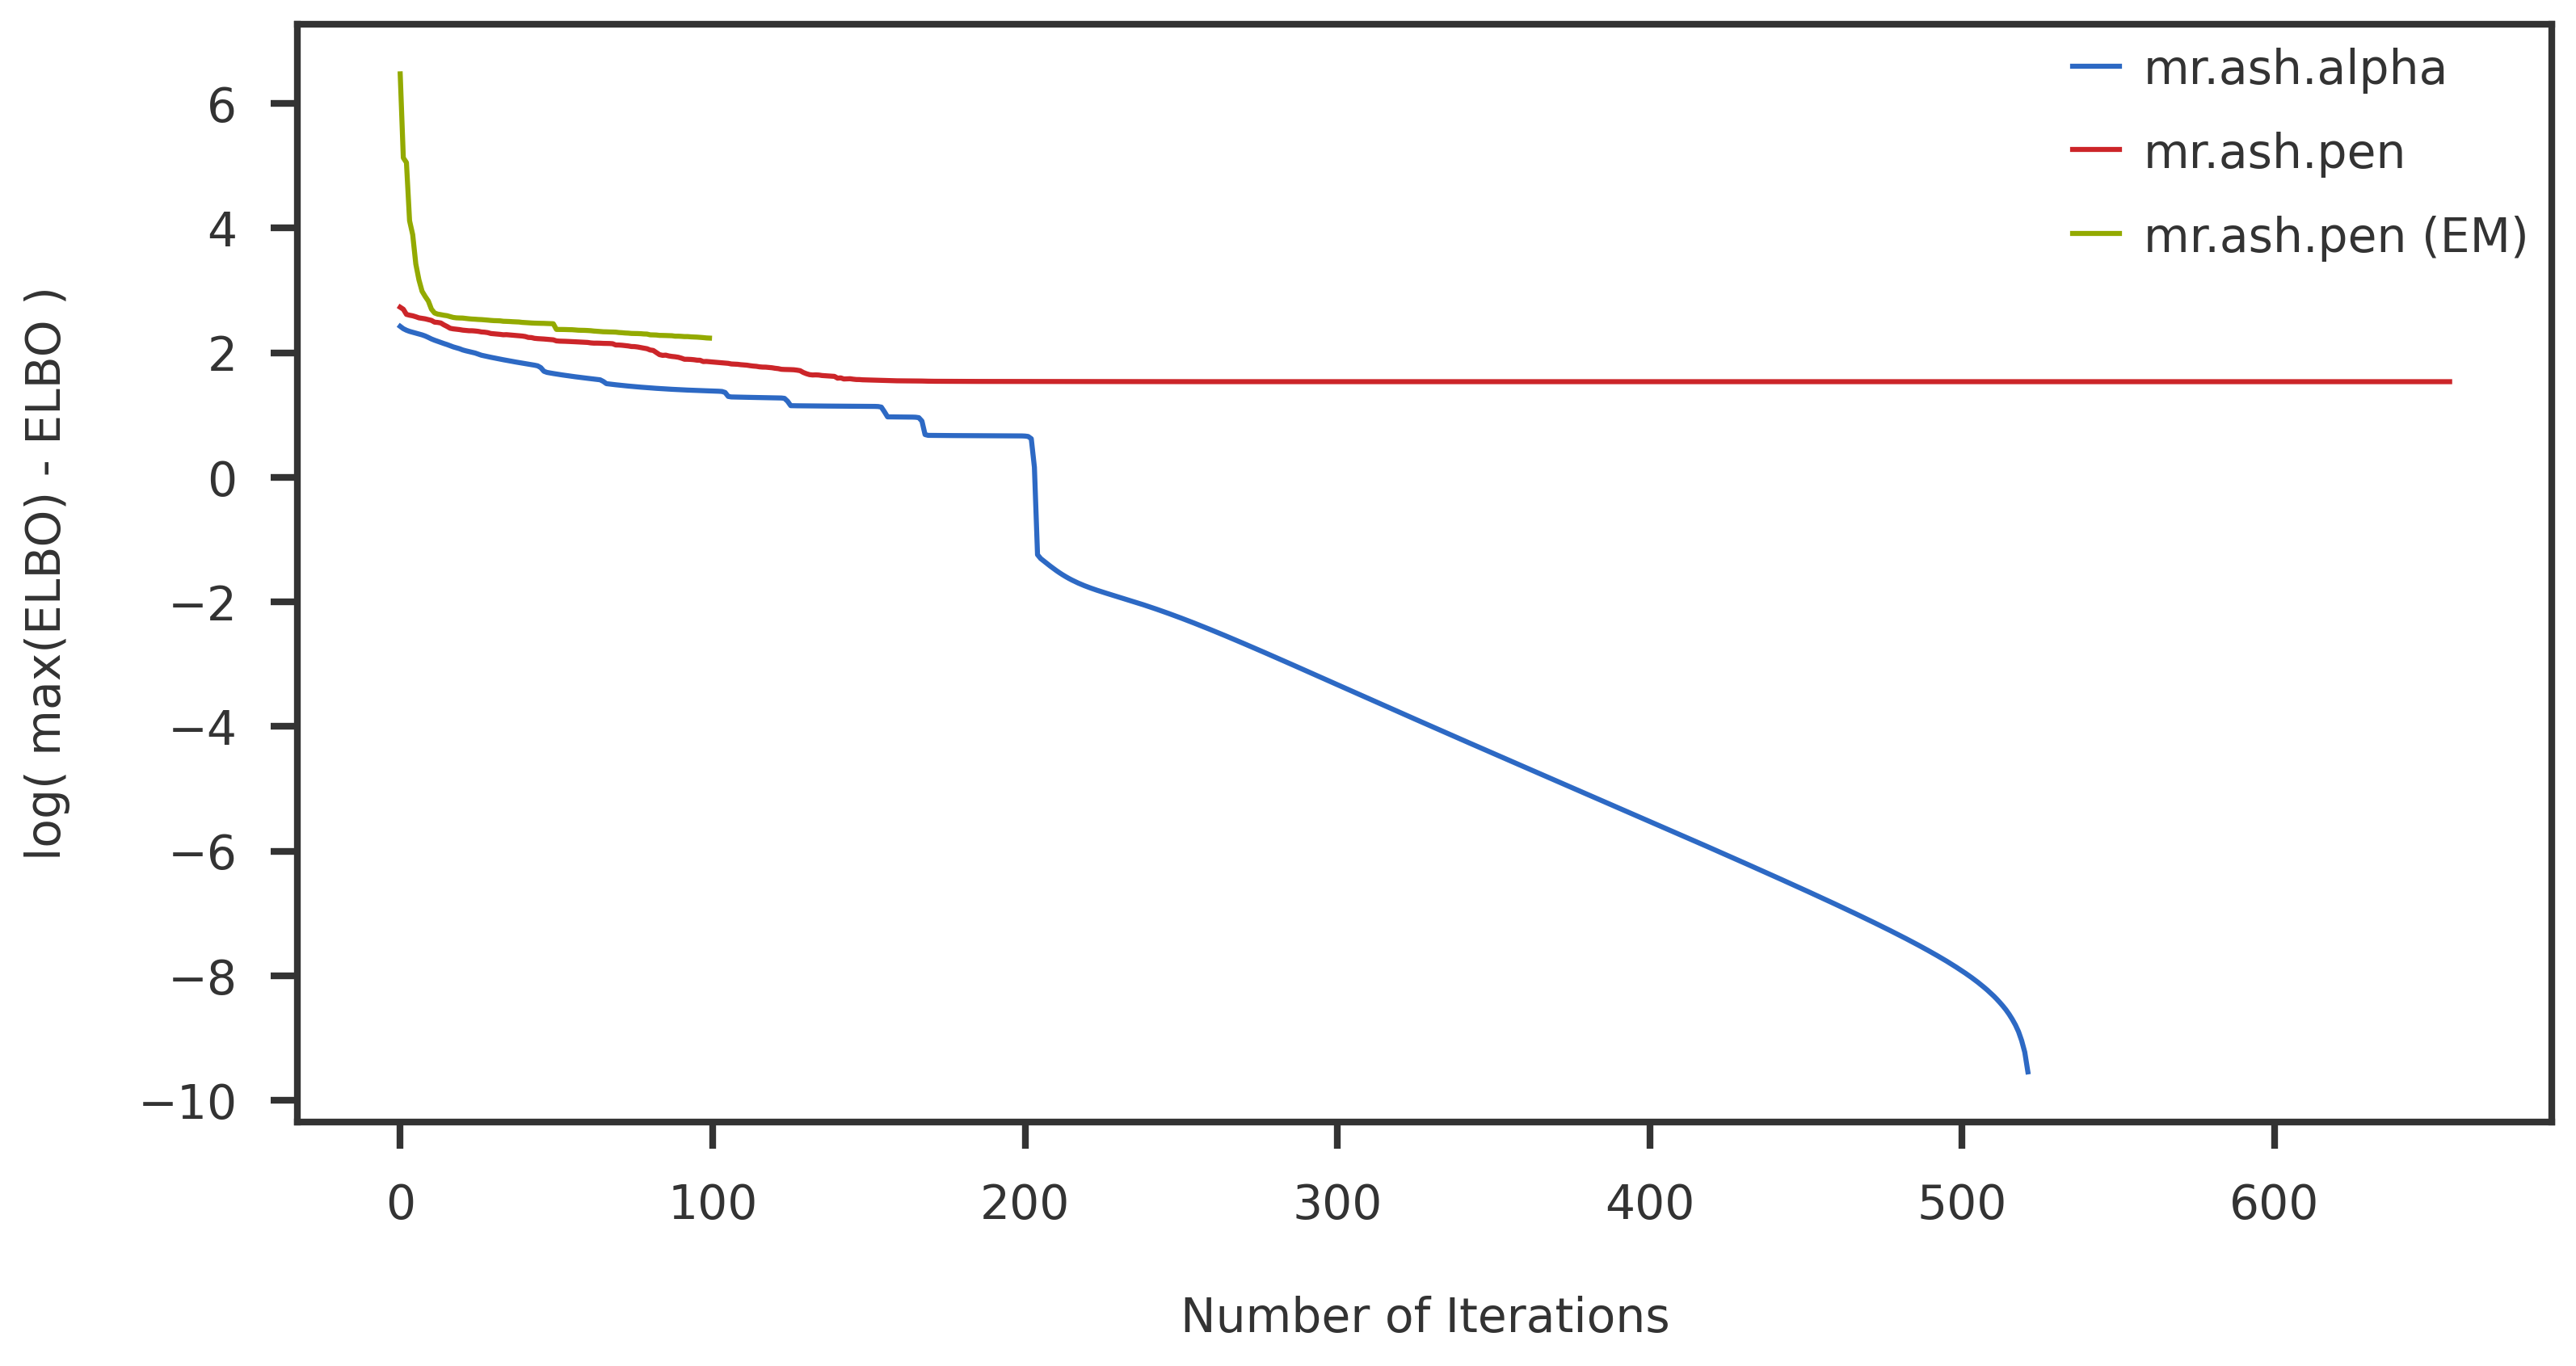

In [11]:
# collapse-hide

'''
Plot
'''
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     genlasso_b, intercept = genlasso_a0, title = 'Lasso')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [12]:
#collapse-hide

objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
df

sigma2        ELBO niter
True                 0.150644           -     -
mr.ash.alpha         0.318355  312.718728   523
mr.ash.pen           0.429685  346.906255   657
mr.ash.pen (EM)      0.629783  483.877748   100
mr.ash.alpha (init)  0.425031  326.546393   745

## 4. Trendfiltering with linear basis function

With a linear basis function, Mr.ASH tends to perform worse than other sparse regression methods. However, in this case, mr.ash.pen and mr.ash.pen (EM) also performs poorly. I found that the poor performance is mainly due to a low spread of variance in the mixture prior. As illustrated below, the performance of mr.ash.pen improves by changing the mixture prior.

Note that mr.ash.pen does not converge after 1000 iterations.

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 

Lasso initialization
mr.ash.pen terminated at iteration 1885.
mr.ash.pen (EM) terminated at iteration 4.
Mr.ASH terminated at iteration 609.
Mr.ASH terminated at iteration 458.


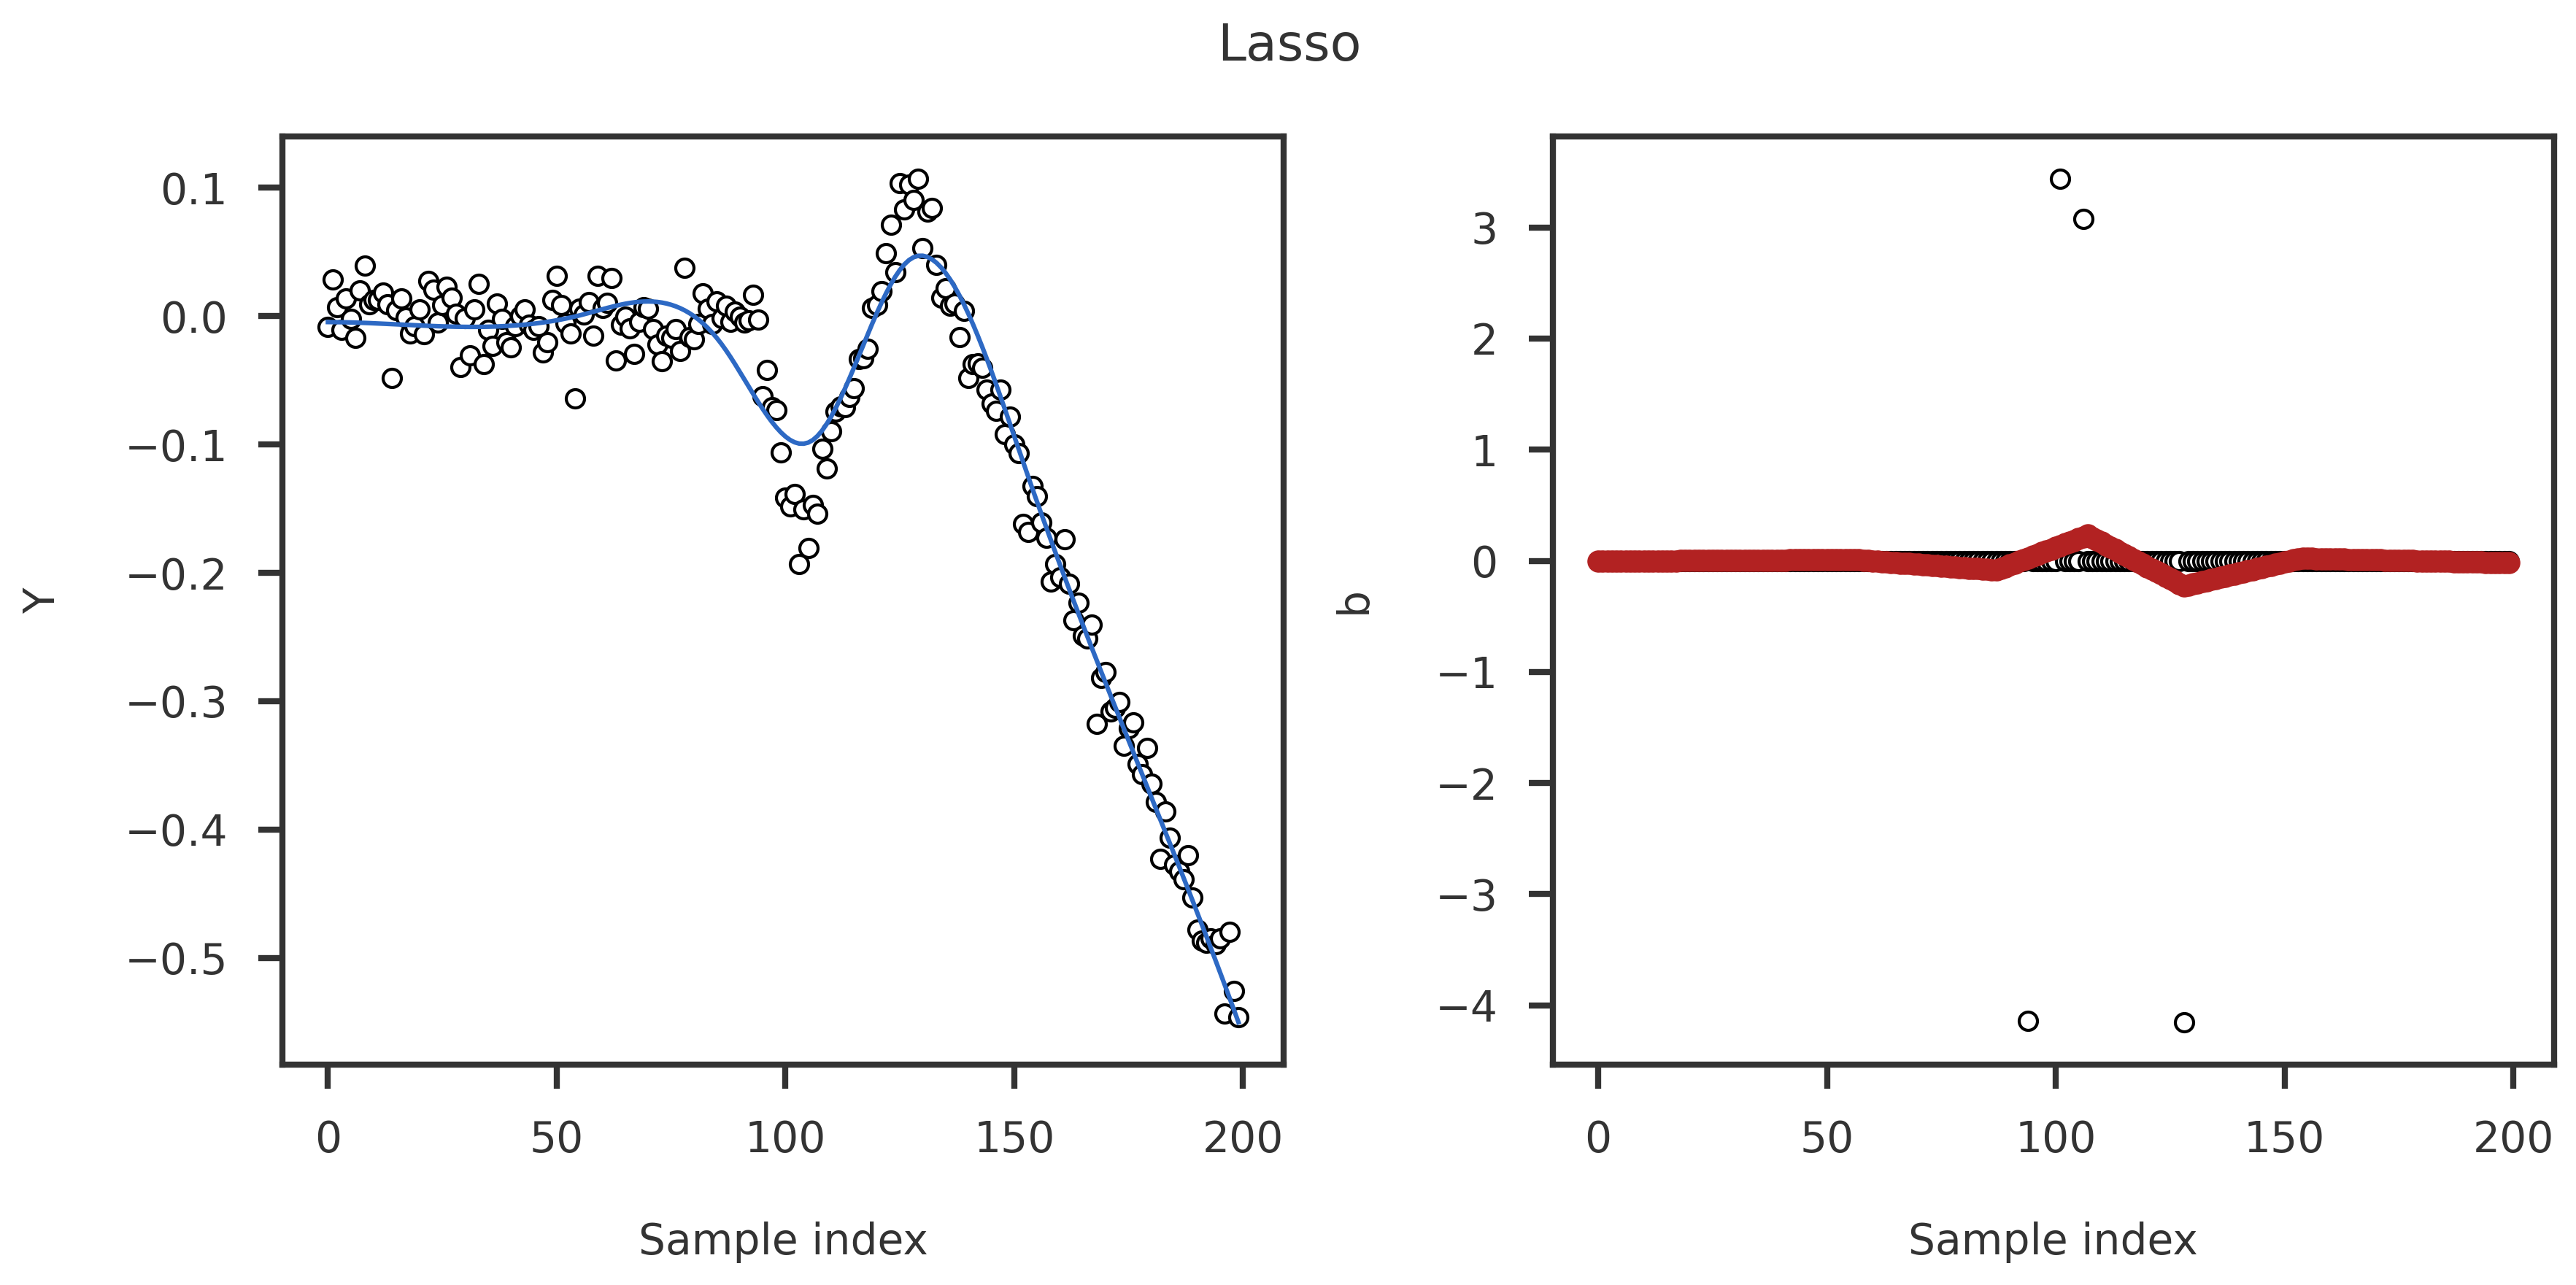

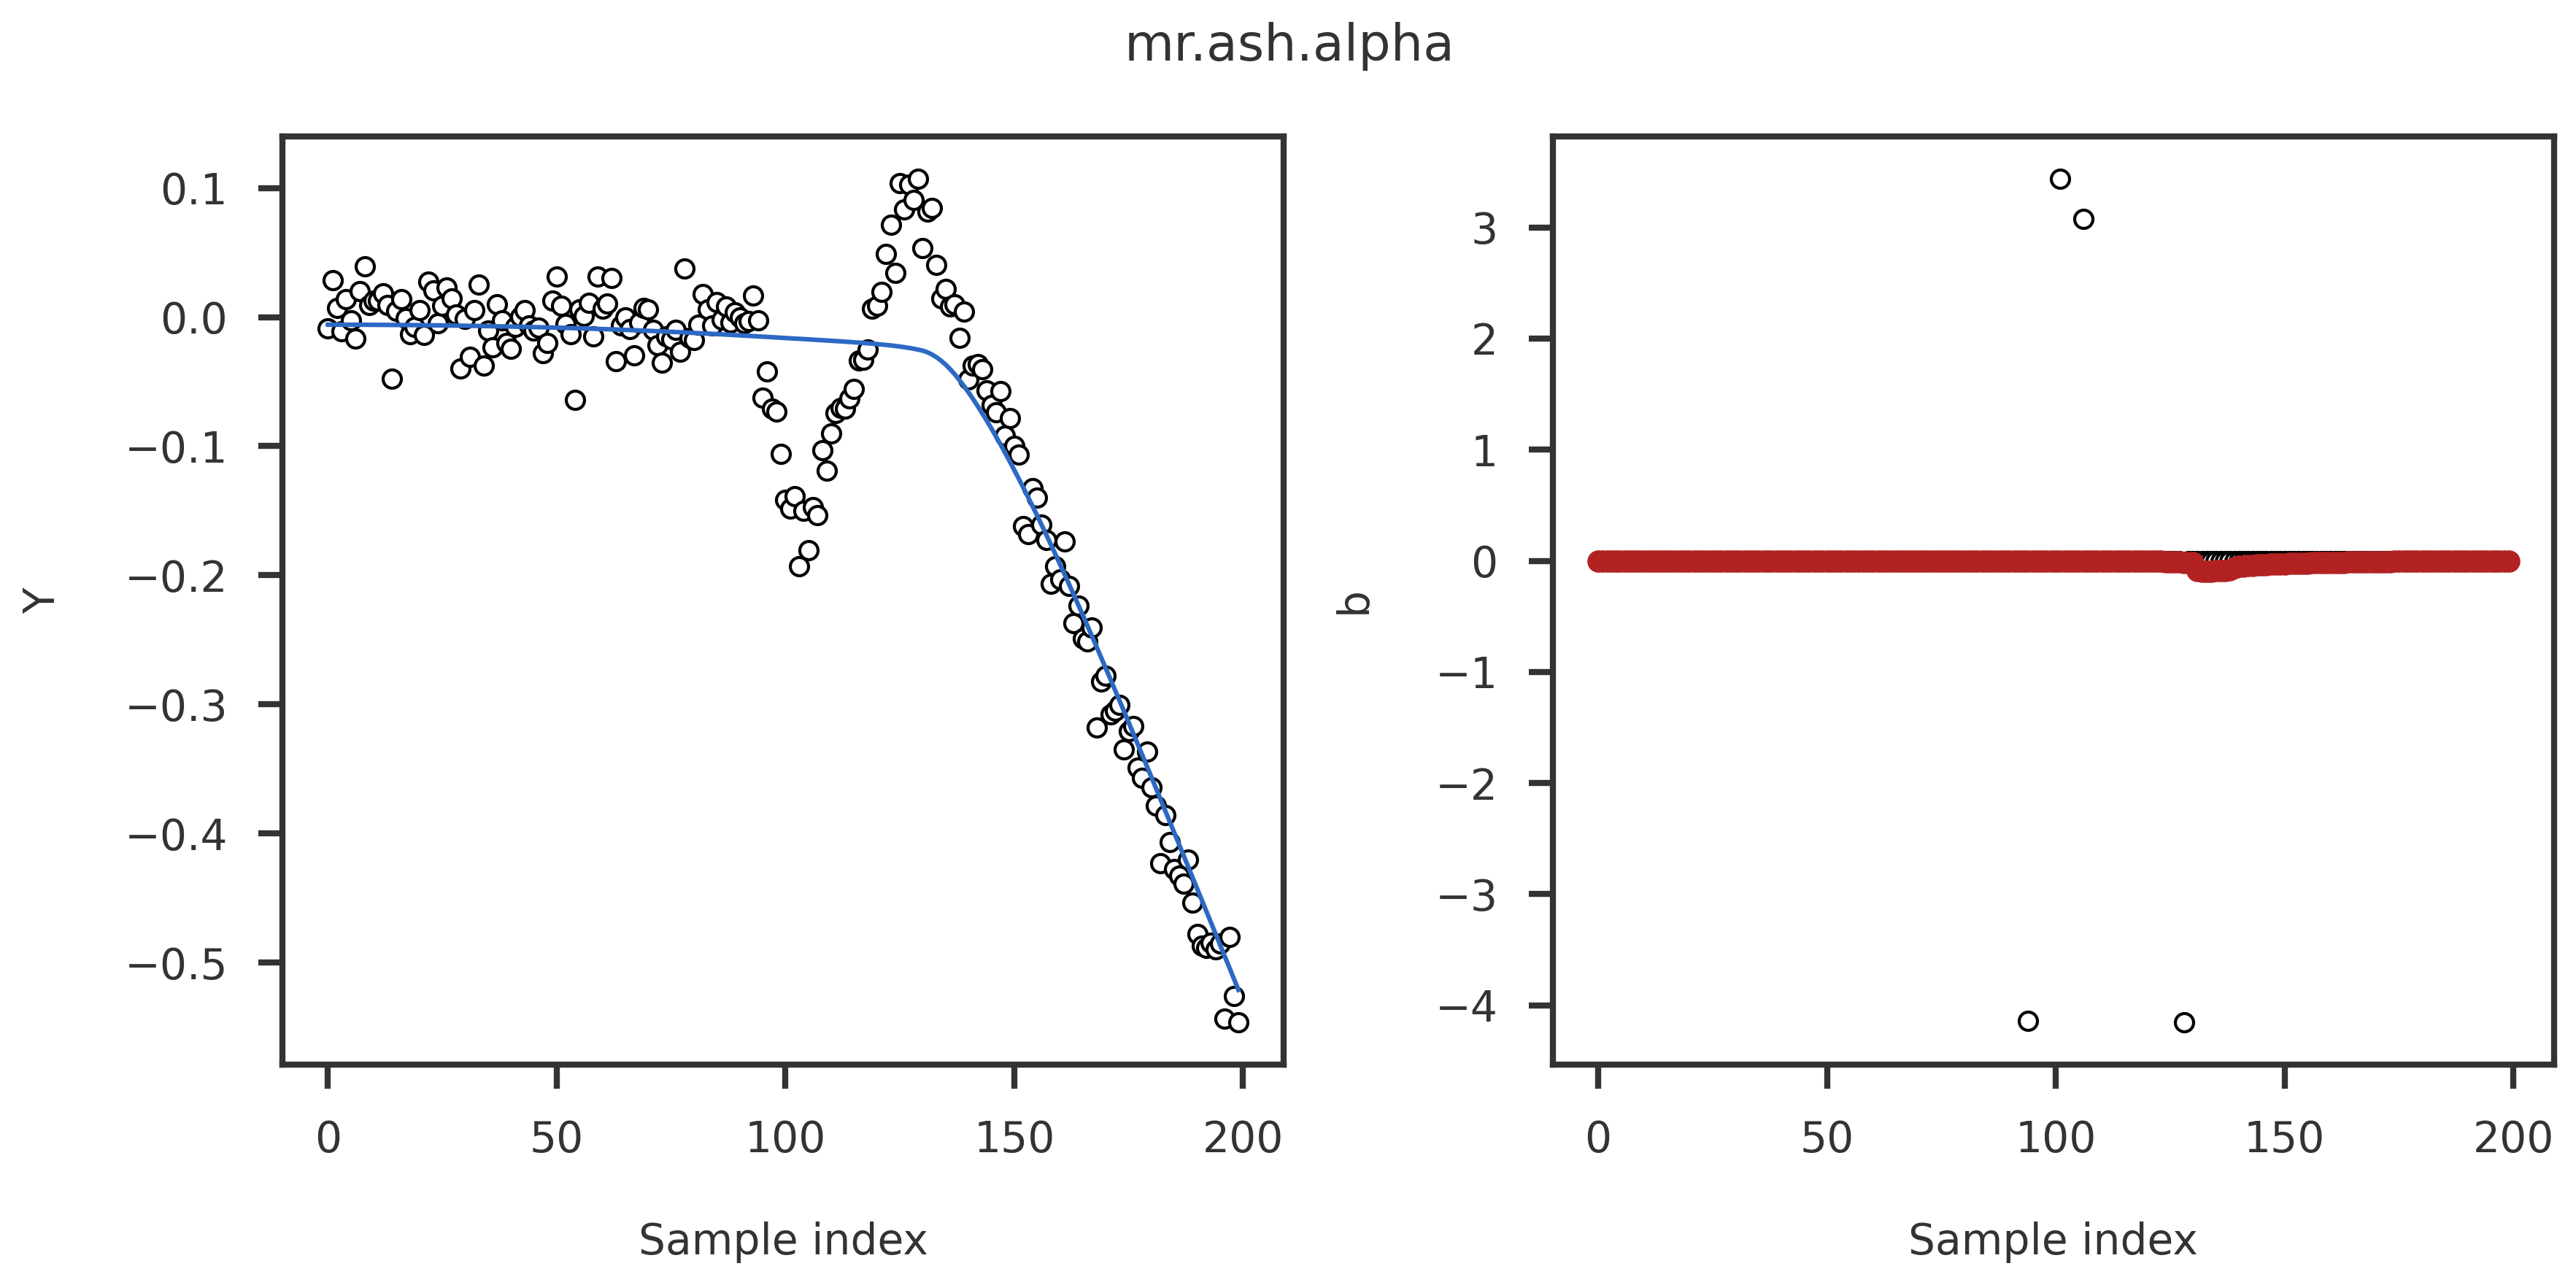

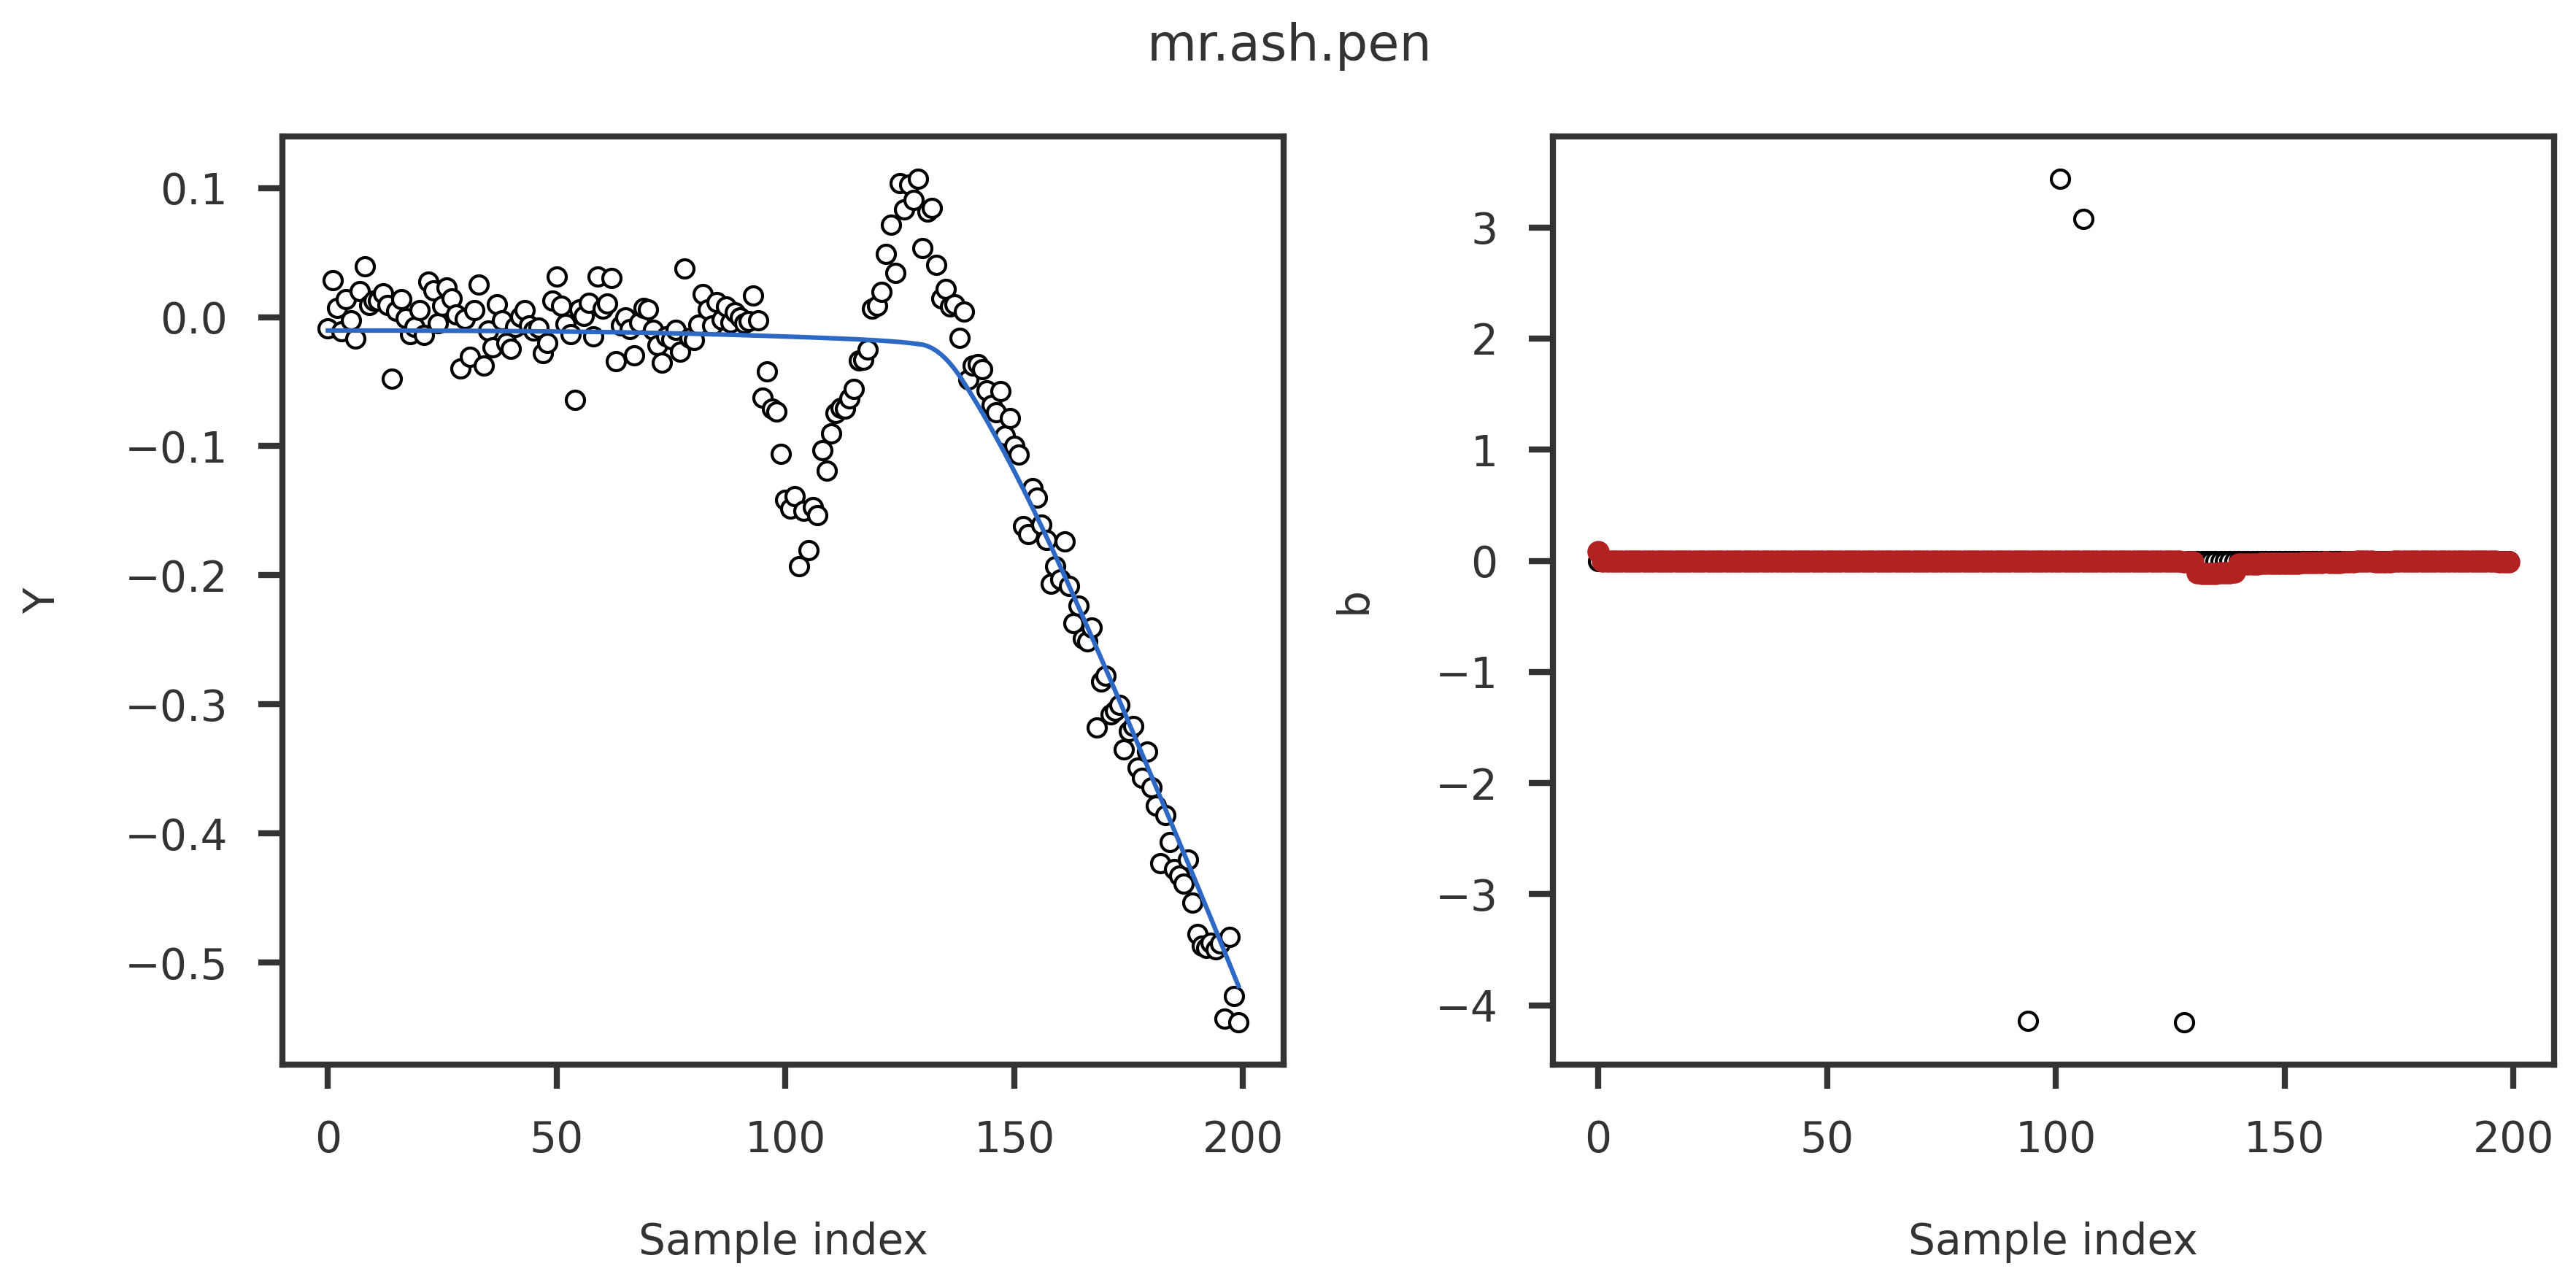

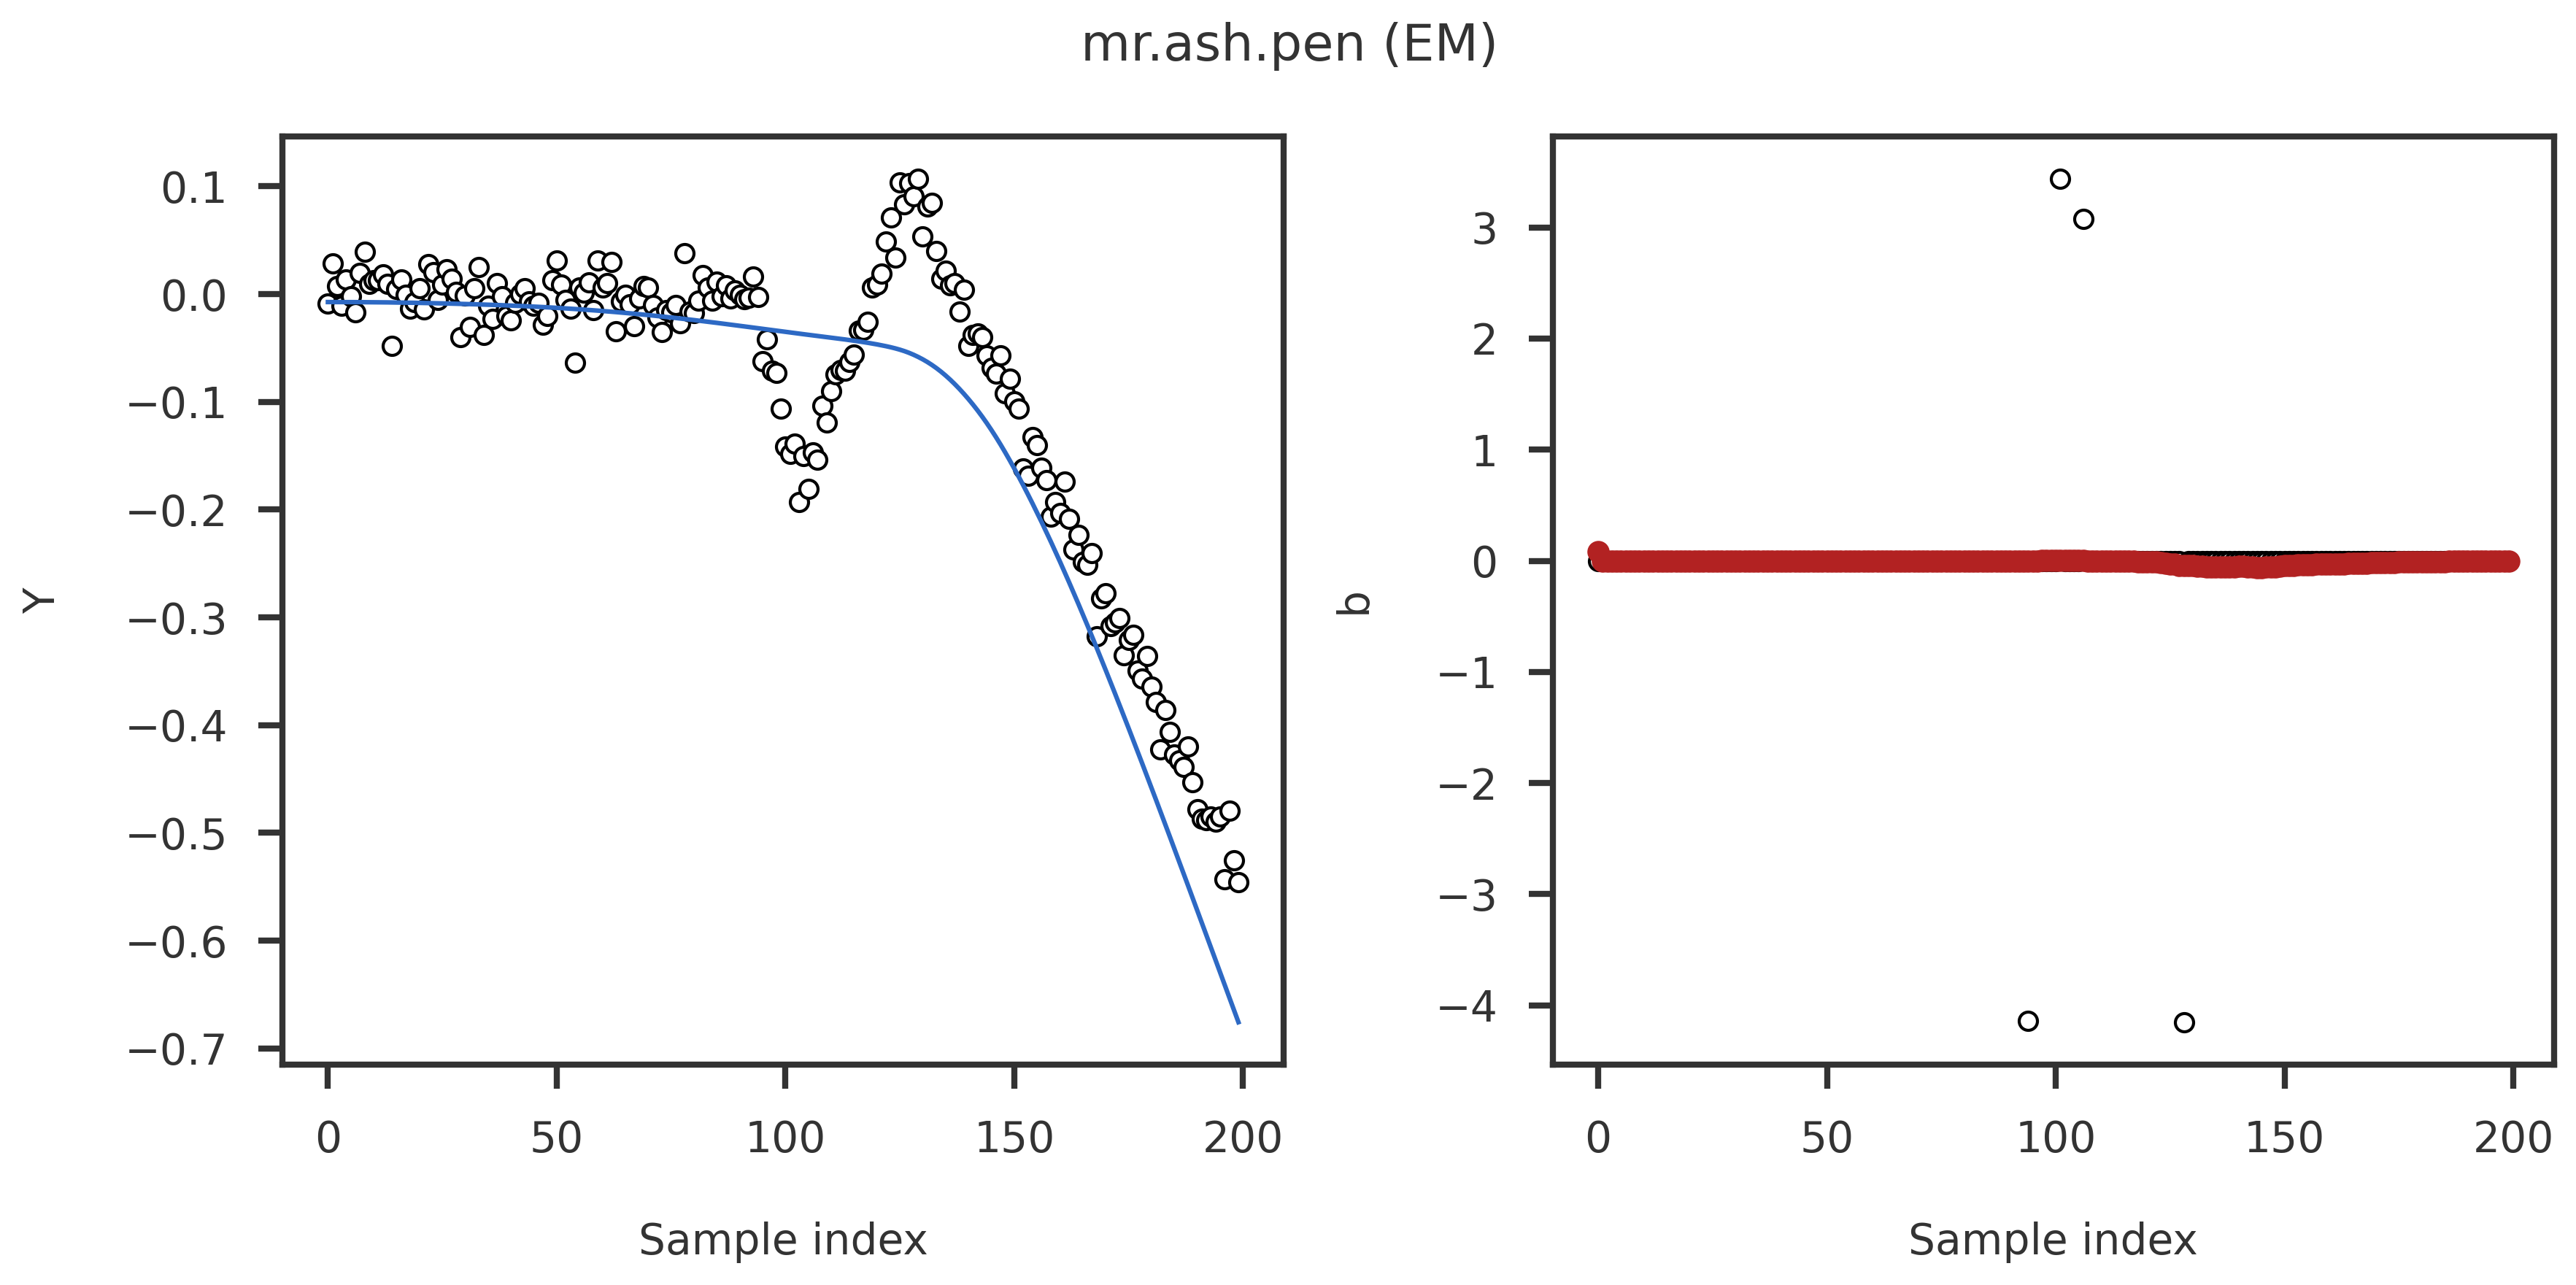

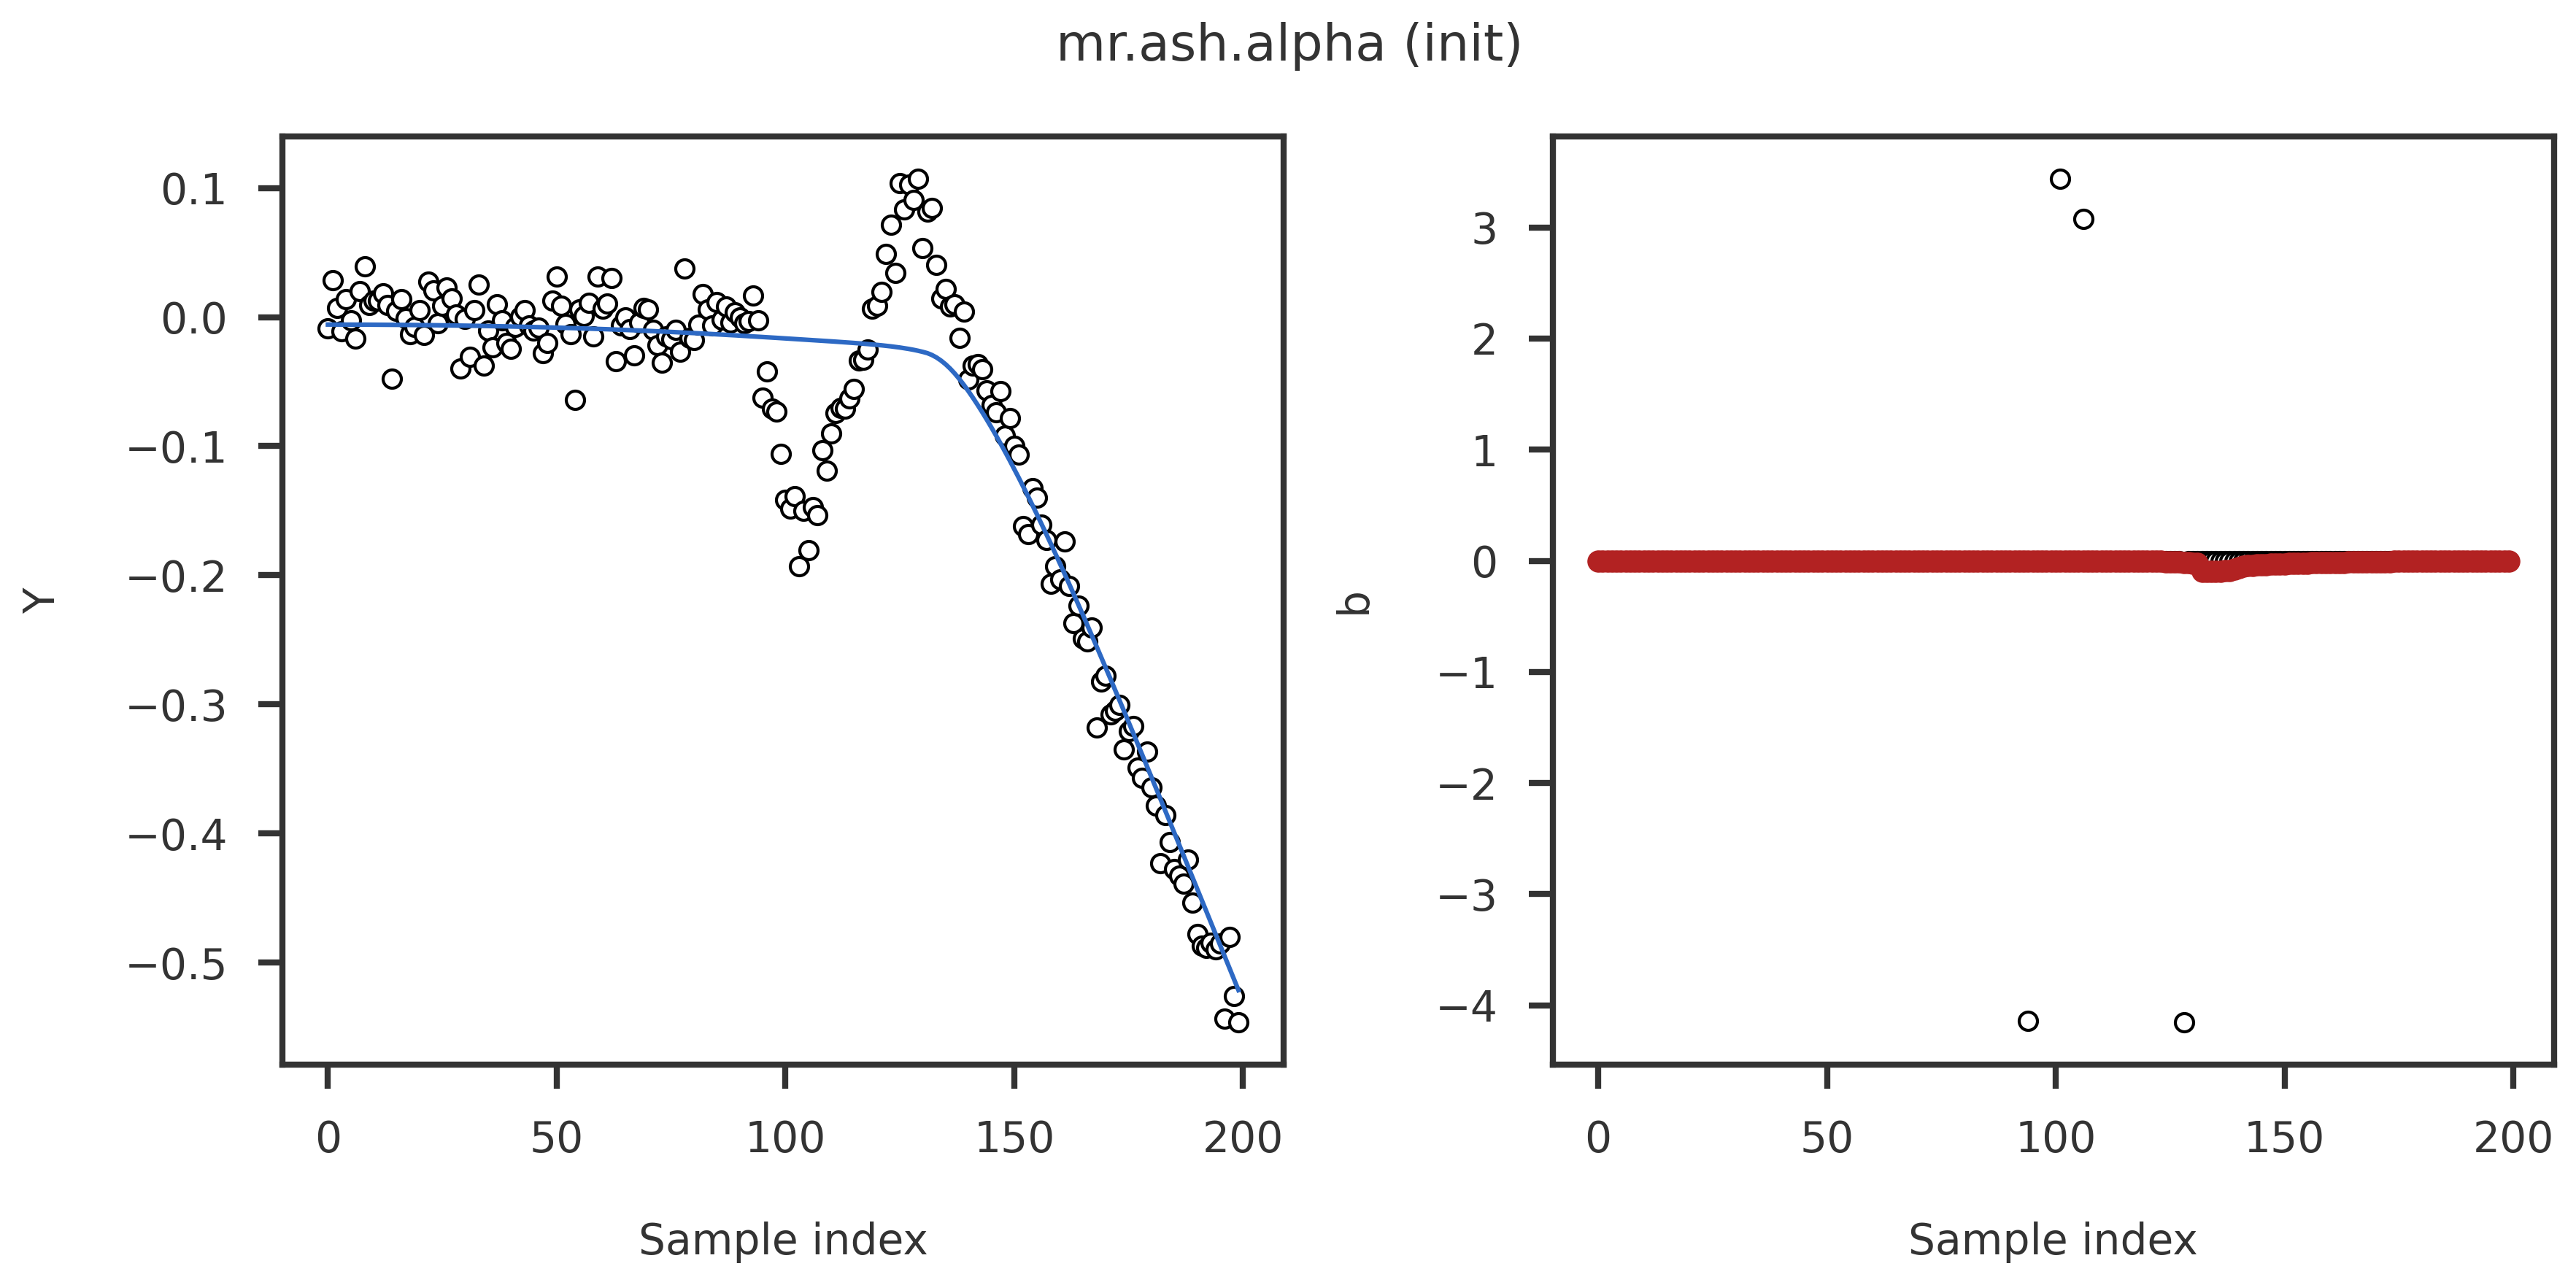

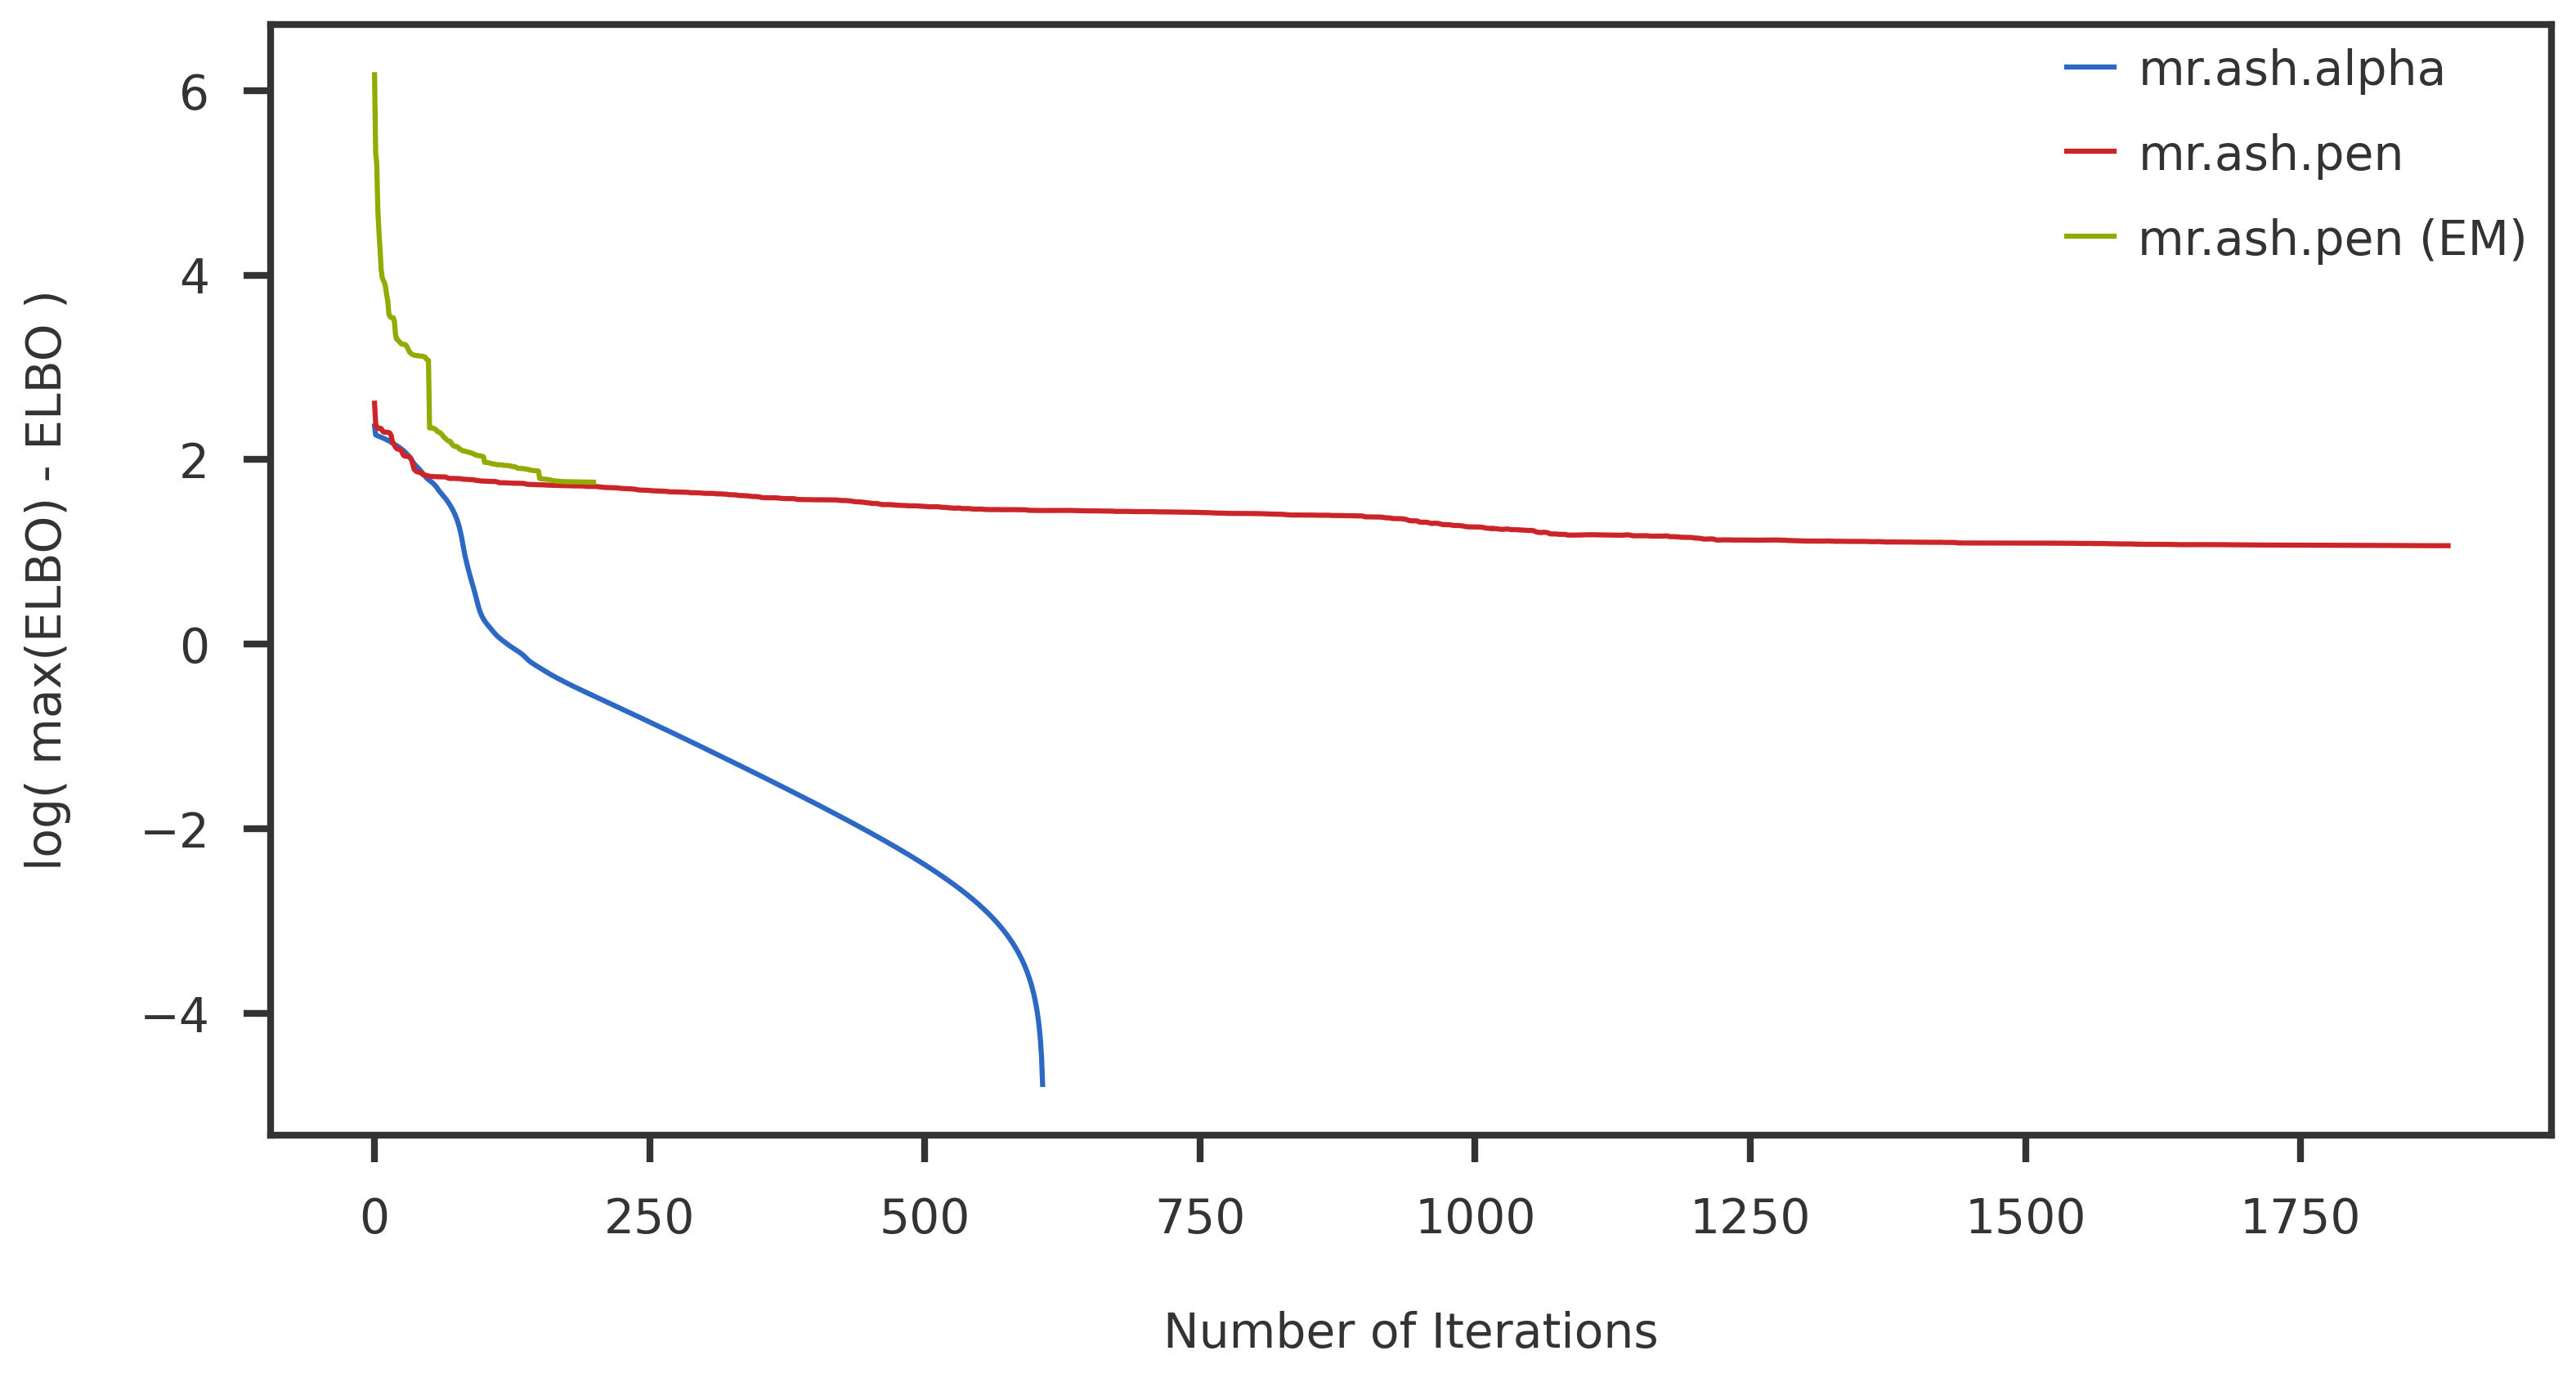

In [13]:
#collapse-hide

n = 200
p = 200
p_causal = 4
snr = 200
k = 10

X, y, Xtest, ytest, btrue, strue = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                    k = 1, signal = 'gamma', seed = 100)
wk, sk = initialize_ash_prior(k, scale = 2)

'''
Lasso initialization
'''
genlasso_a0, genlasso_b, _ = R_genlasso.fit(X, y, order = 1)
genlasso_b = genlasso_b.reshape(-1,)
s2init = np.var(y - np.dot(X, genlasso_b) - genlasso_a0)
winit  = mix_gauss.emfit(genlasso_b, sk)
print ("Lasso initialization")

'''
mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True, 
                maxiter = 2000, tol = 1e-8)
plr_lbfgs.fit(X, y, sk, binit = genlasso_b, winit = wk, s2init = s2init)

'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, binit = genlasso_b, winit = wk, s2init = s2init, 
               maxiter = 200, qb_maxiter = 50, calculate_elbo = True)


'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = genlasso_b, winit = wk, s2init = s2init)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

'''
Plot
'''
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     genlasso_b, intercept = genlasso_a0, title = 'Lasso')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [14]:
#collapse-hide

objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
df

sigma2        ELBO niter
True                 0.000342           -     -
mr.ash.alpha         0.003191 -251.761695   609
mr.ash.pen           0.003362 -240.097708  1885
mr.ash.pen (EM)      0.003289 -194.870168   200
mr.ash.alpha (init)  0.003200 -251.782514   458

### Change the prior grid

In [15]:
#collapse-show

wk, sk = initialize_ash_prior(k, scale = 100)

Here, none of the methods converge after reaching their maximum allowed iterations. However, mr.ash.pen provides better estimate for the coefficients, but surprisingly the ELBO is lower than that of mr.ash.alpha.

mr.ash.pen terminated at iteration 2000.
mr.ash.pen (EM) terminated at iteration 5.
Mr.ASH terminated at iteration 2000.
Mr.ASH terminated at iteration 2000.


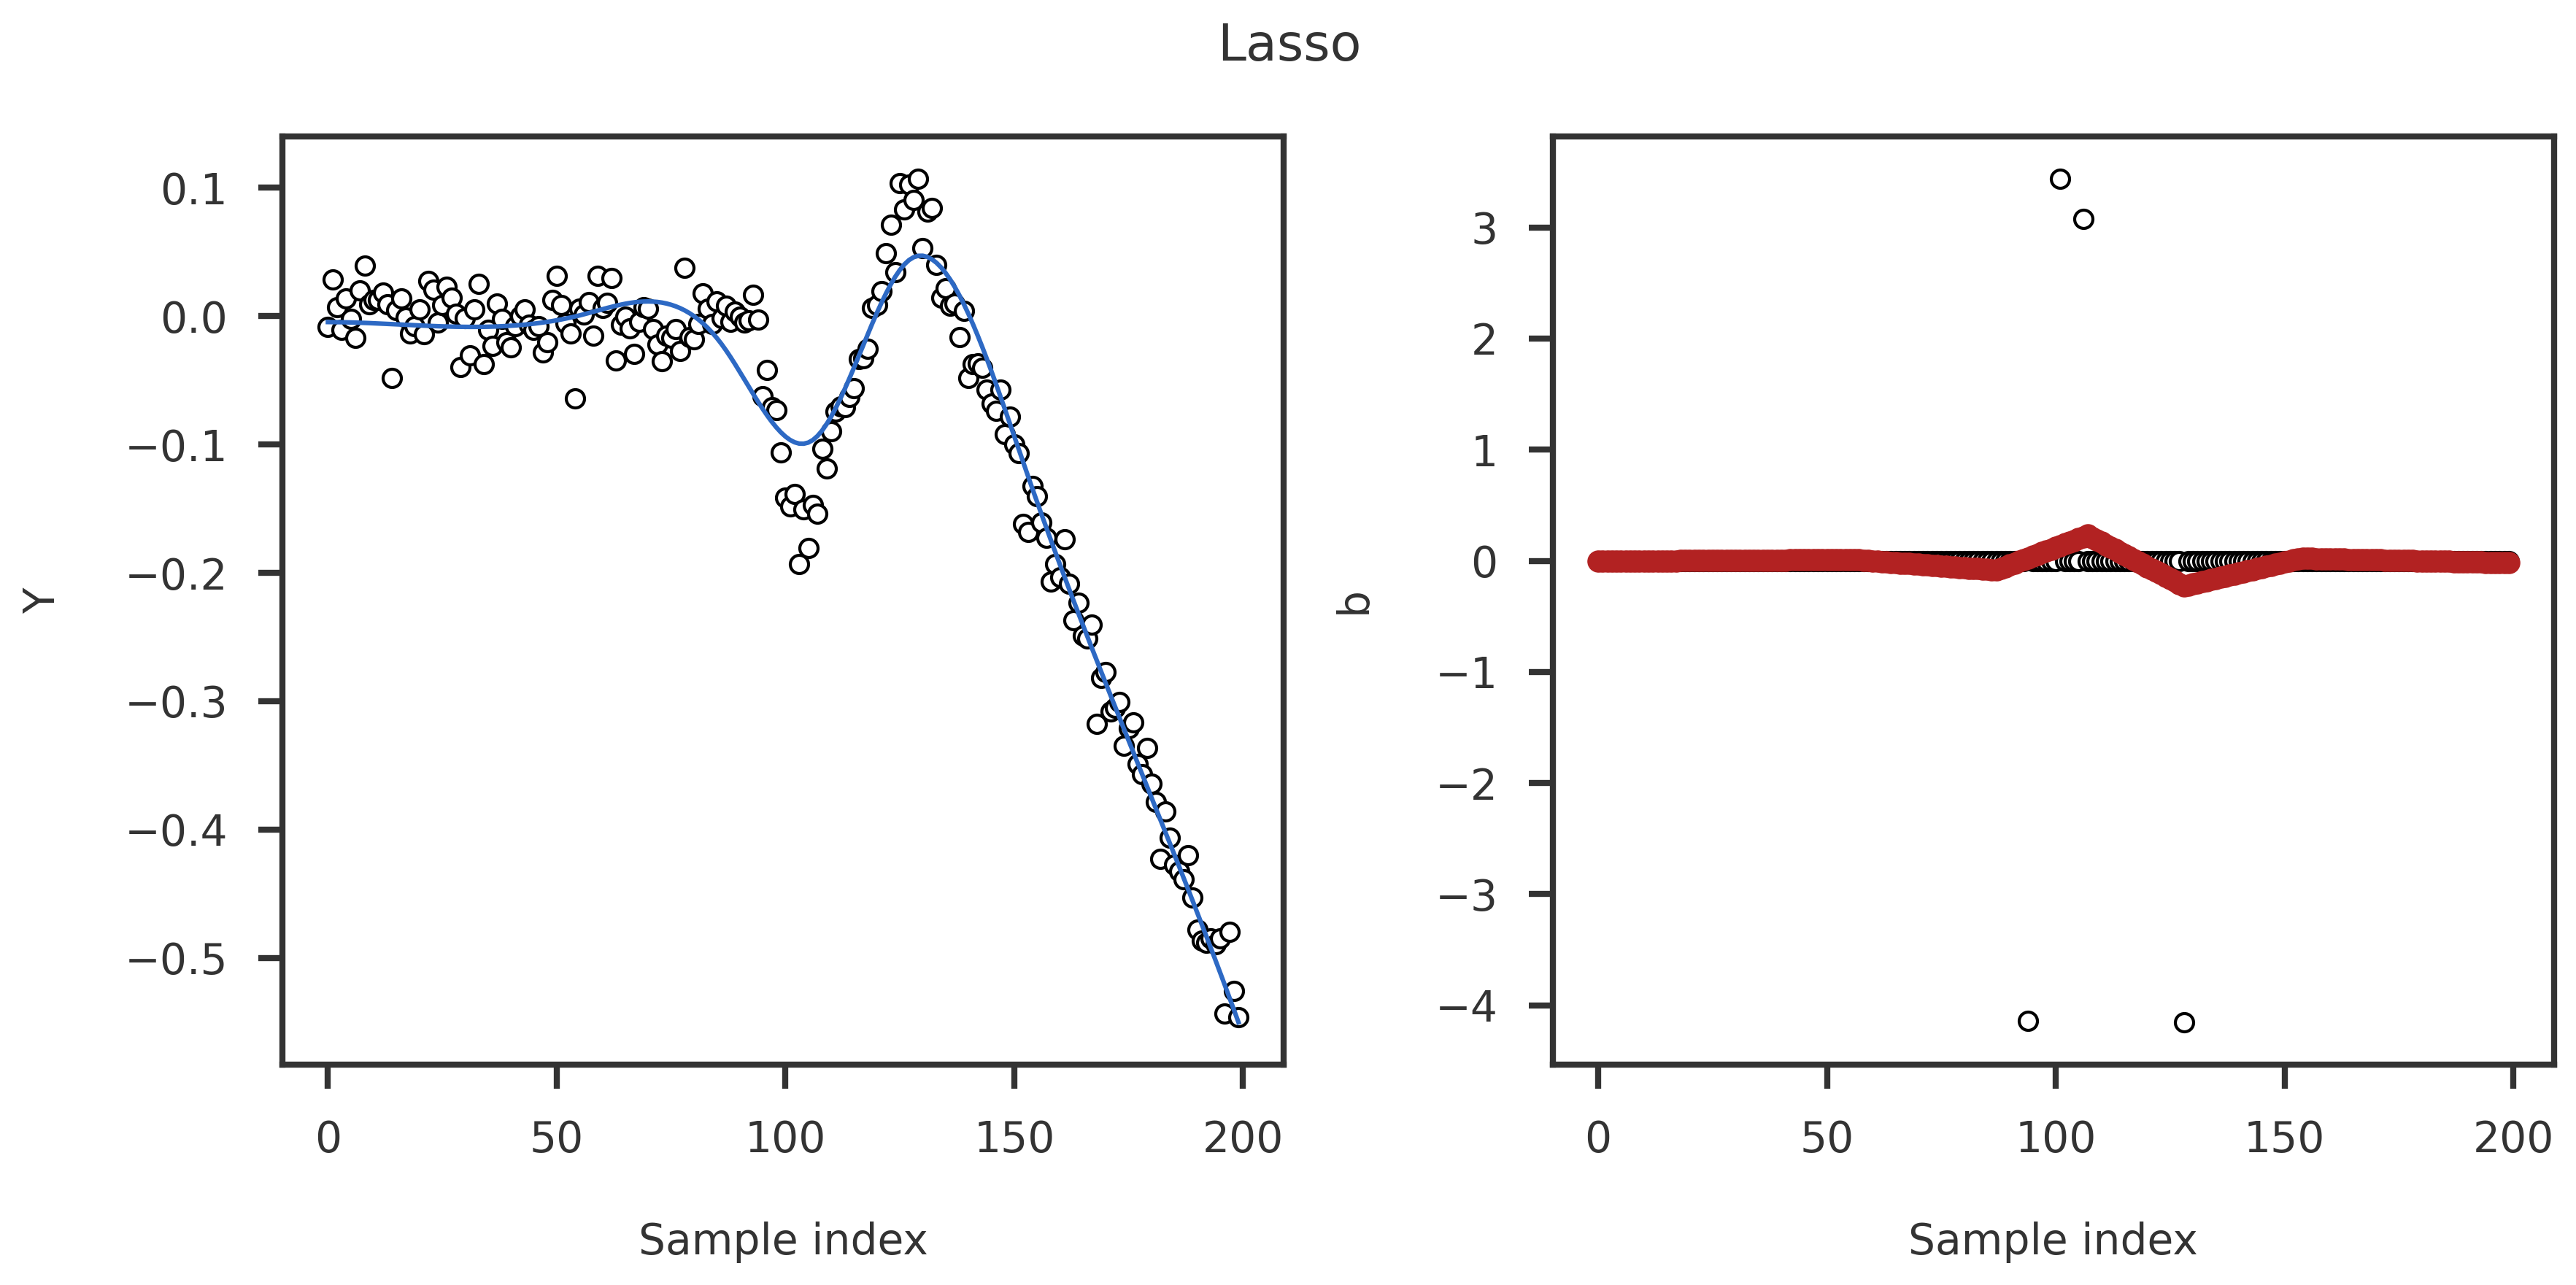

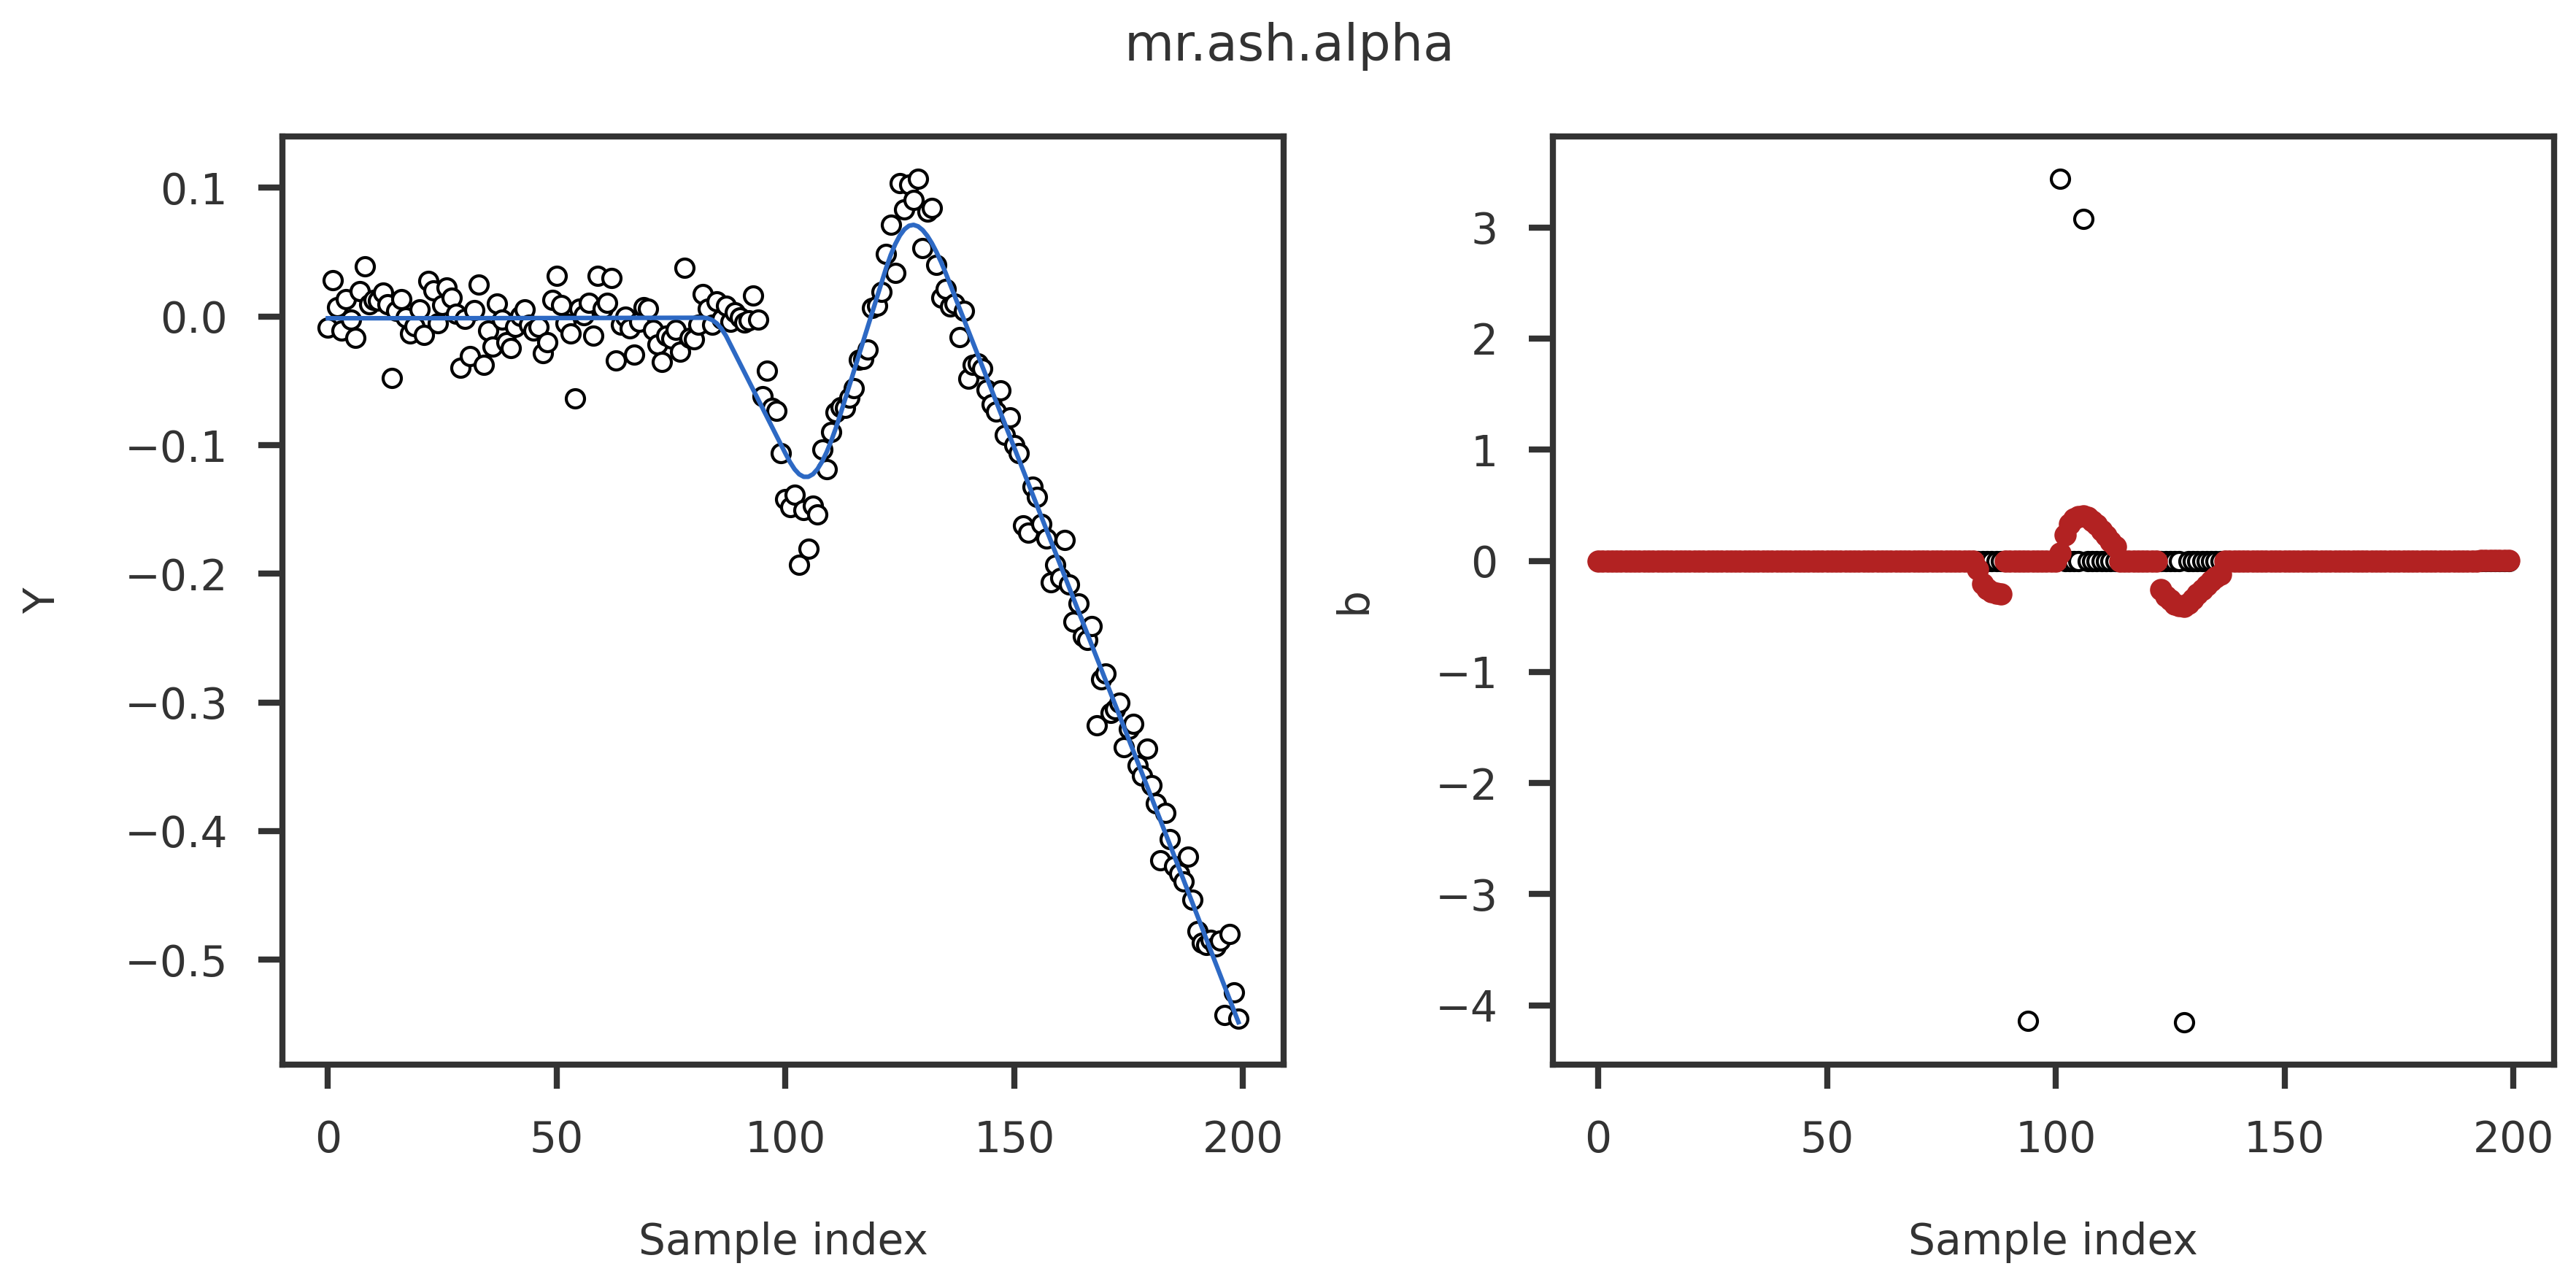

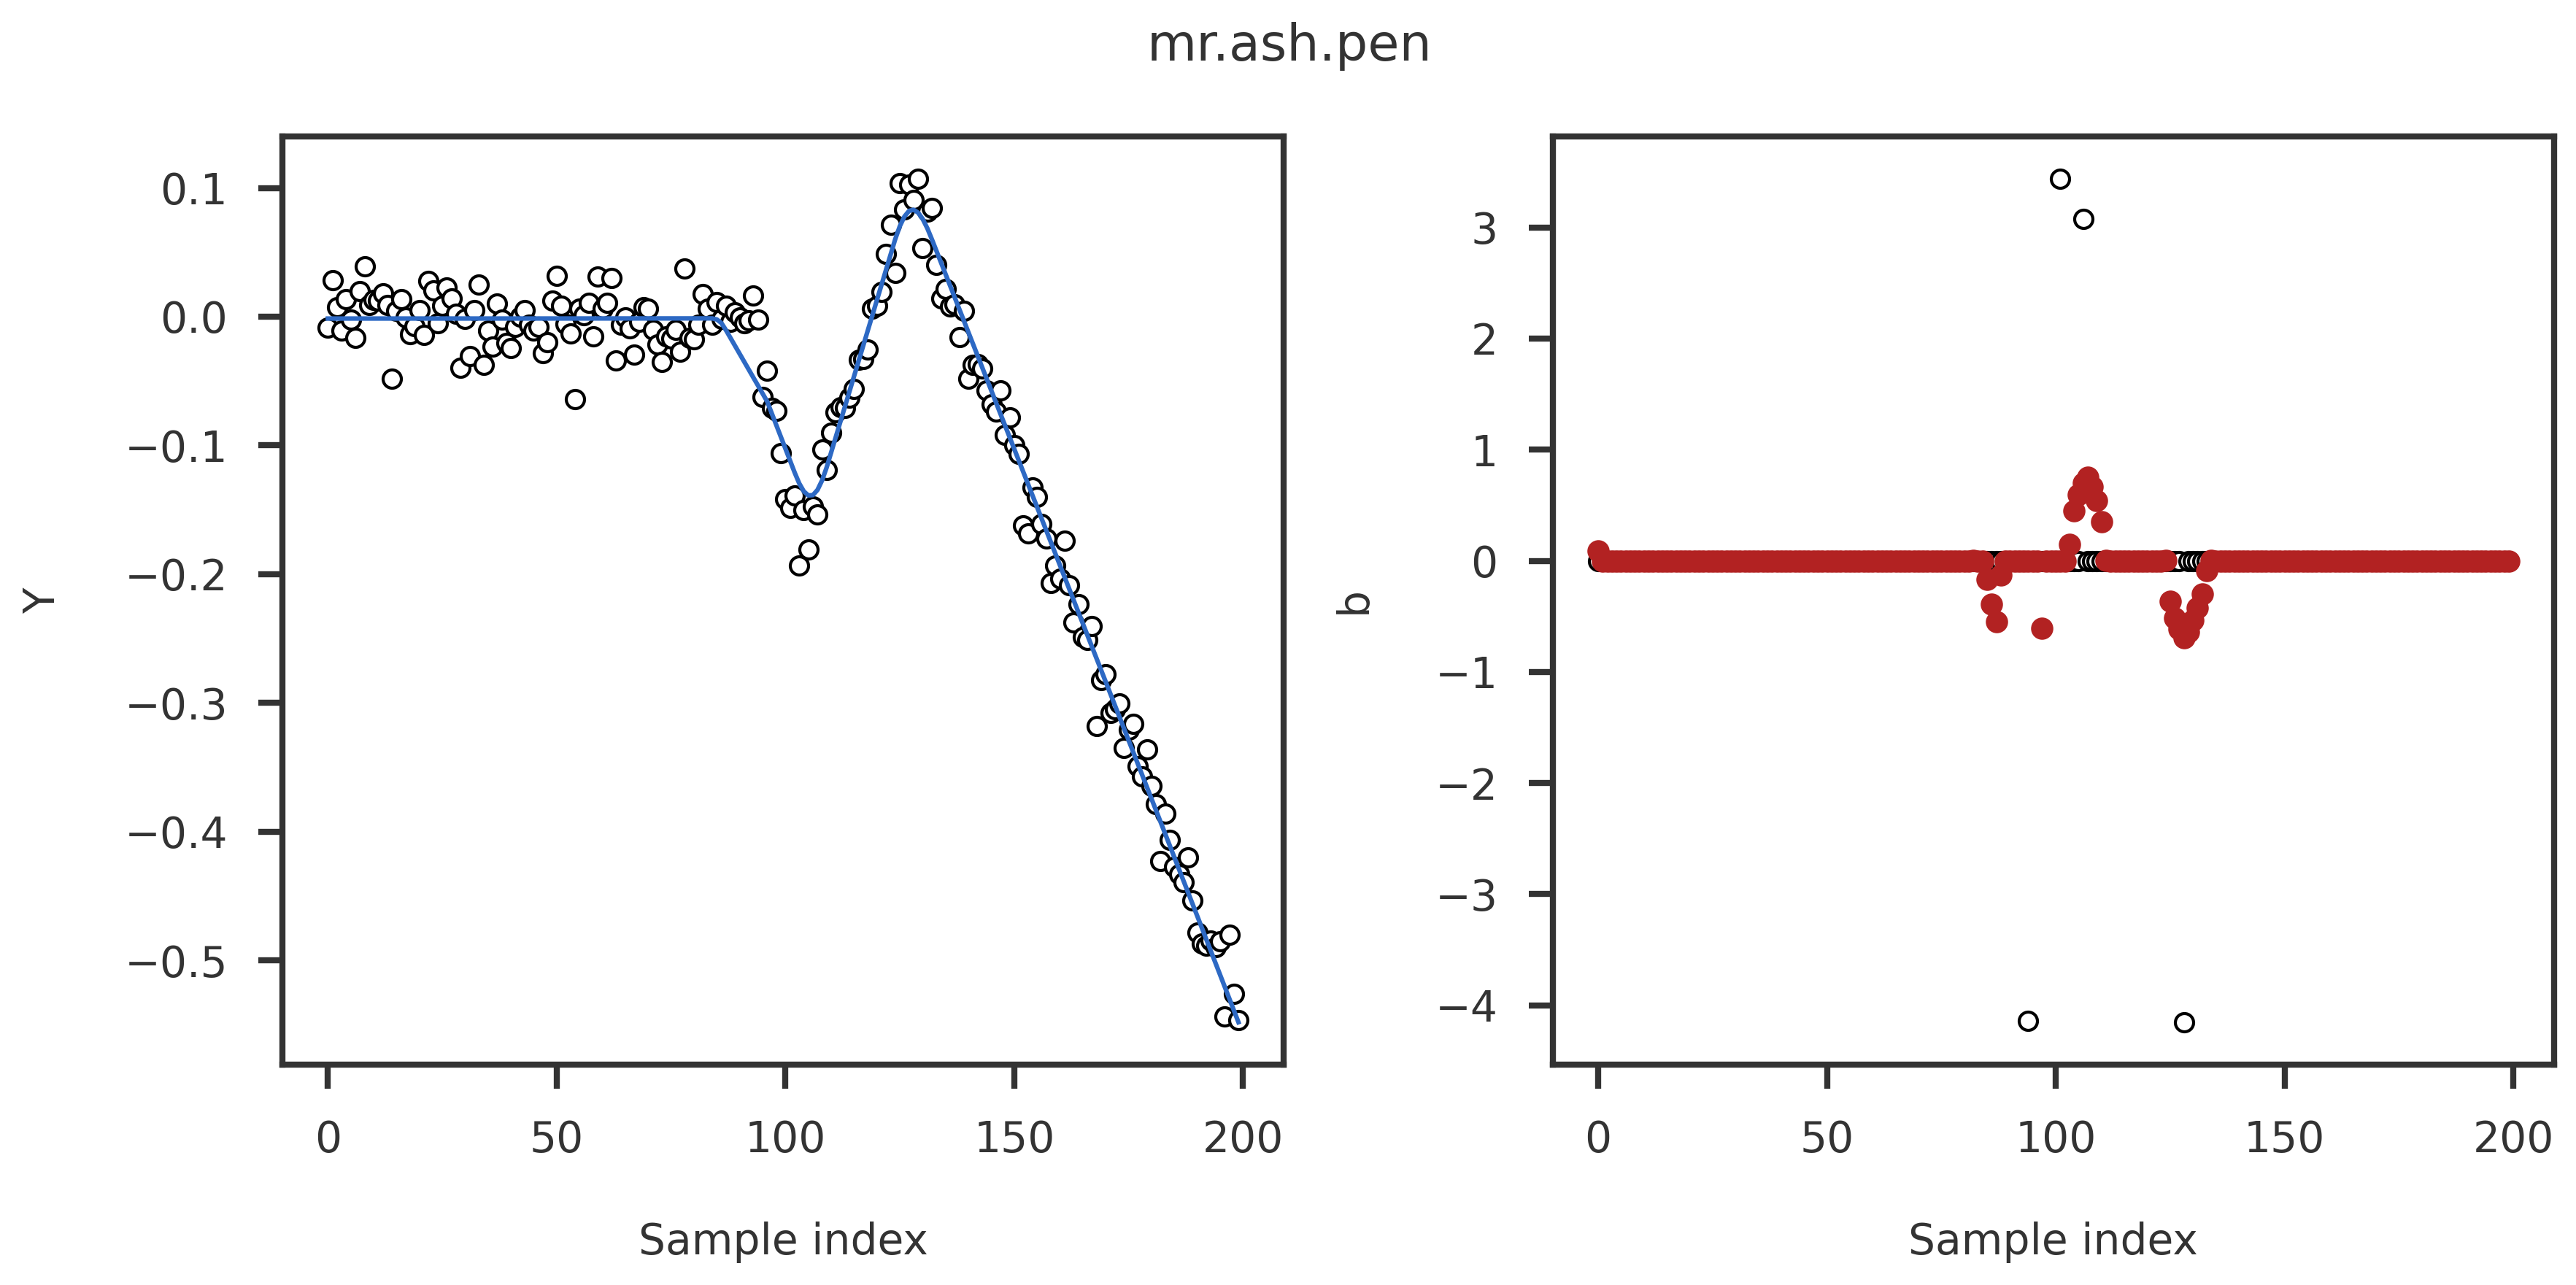

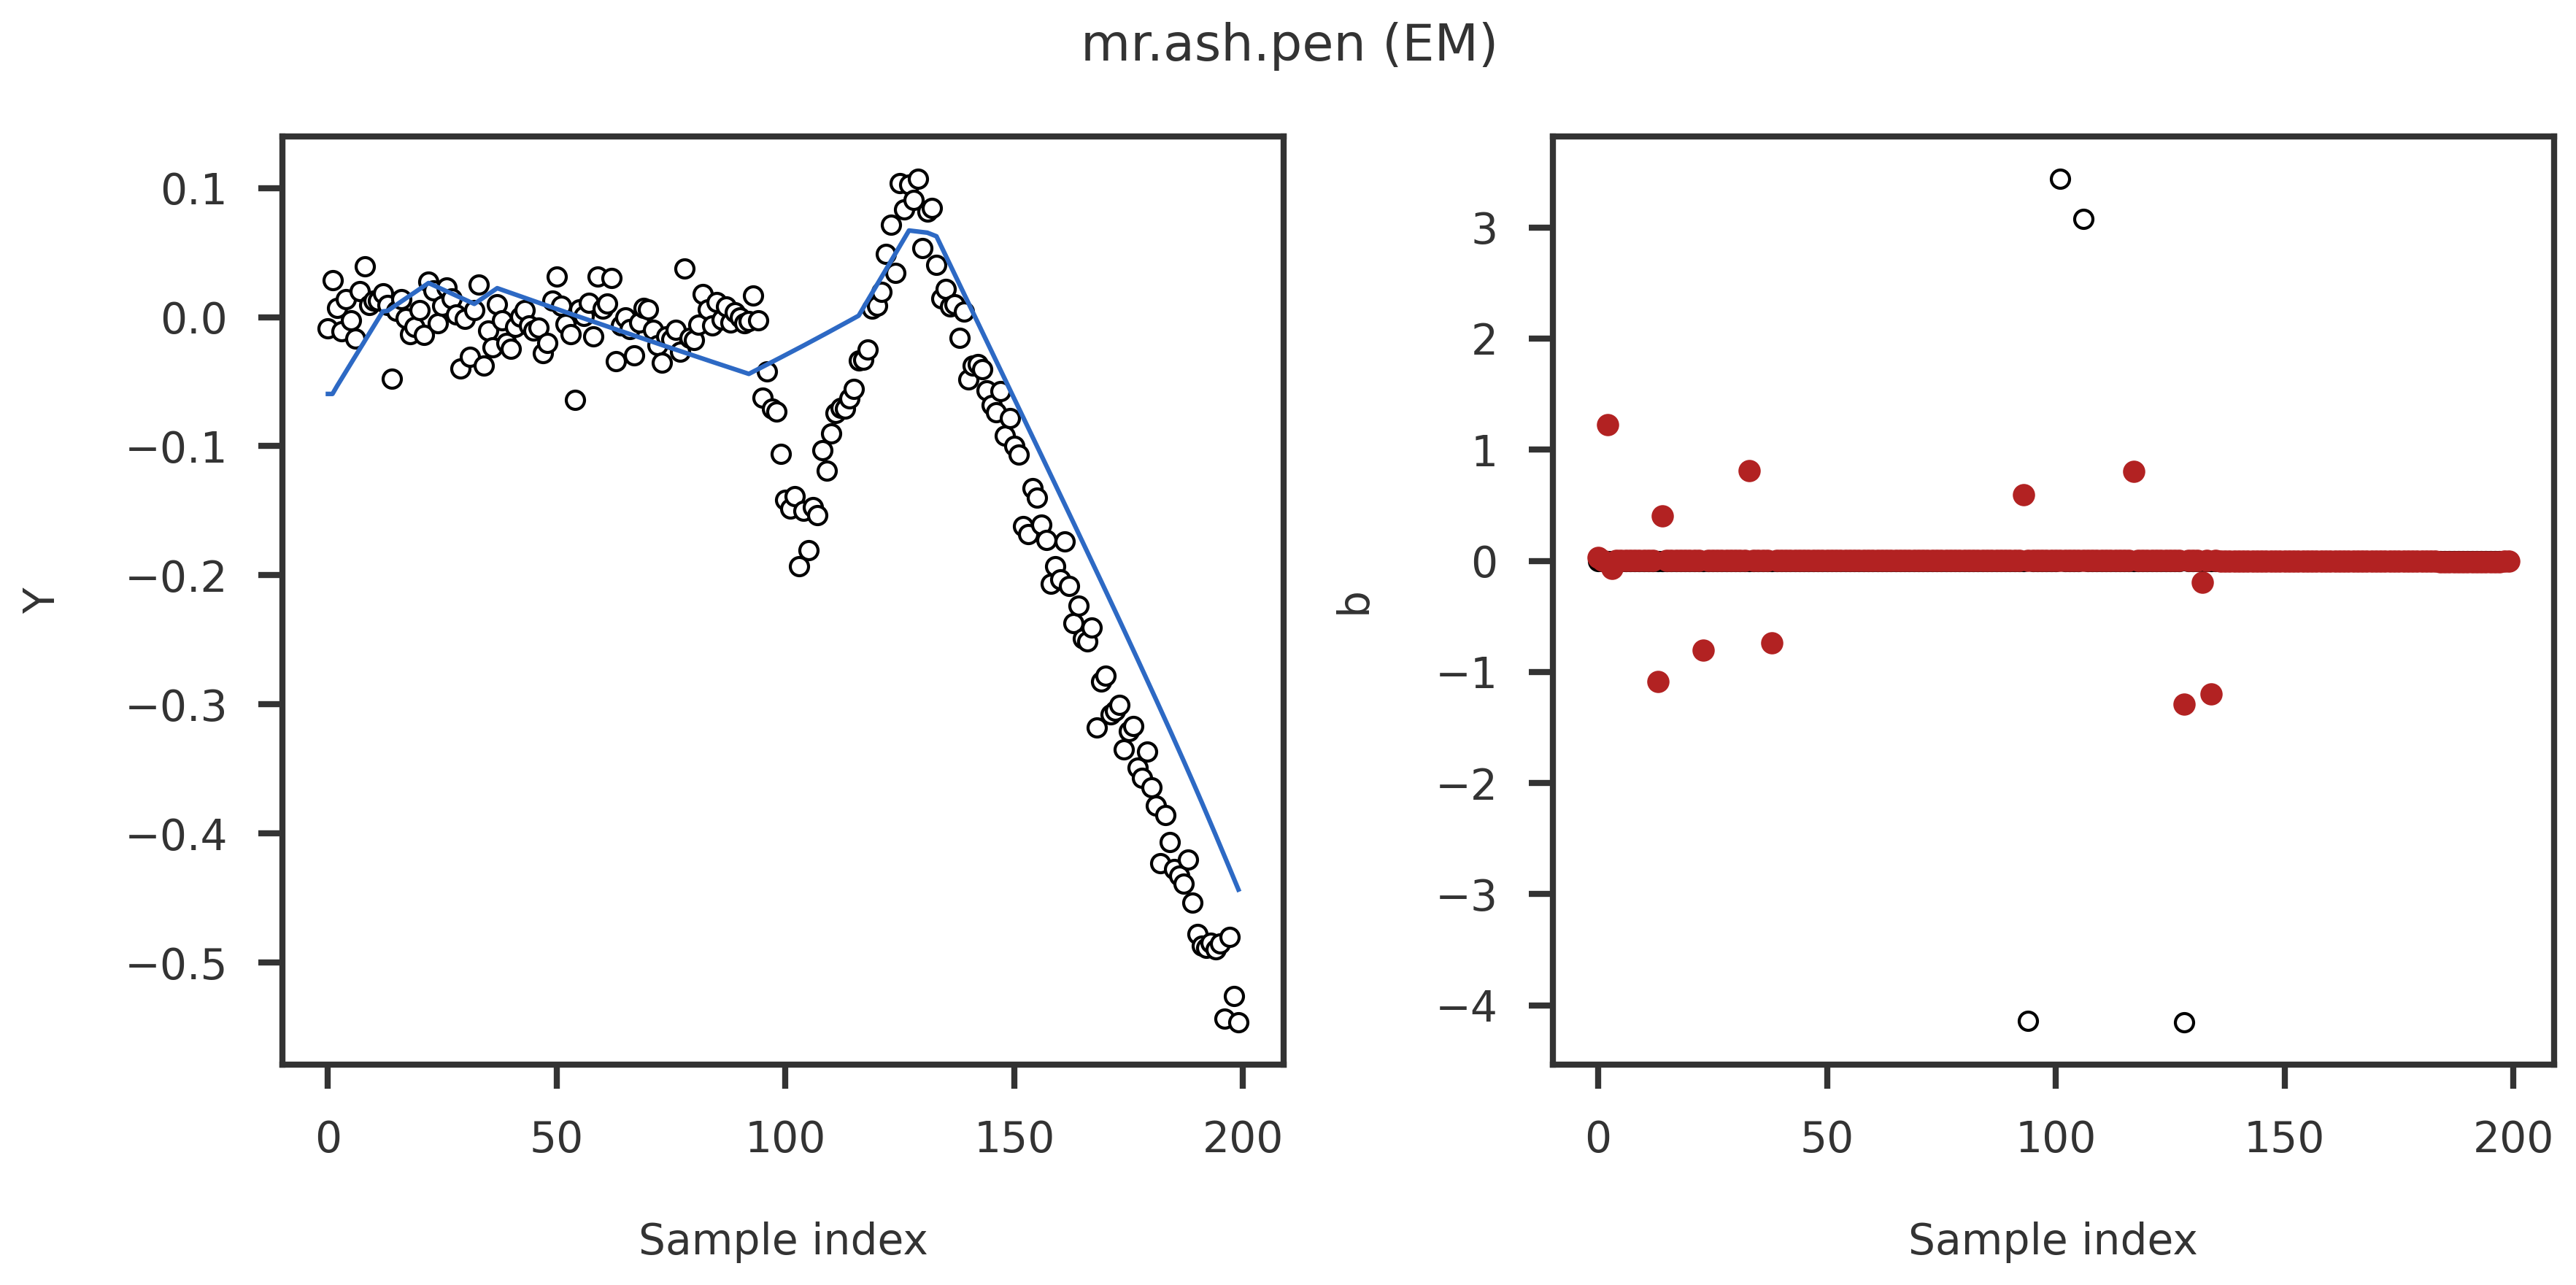

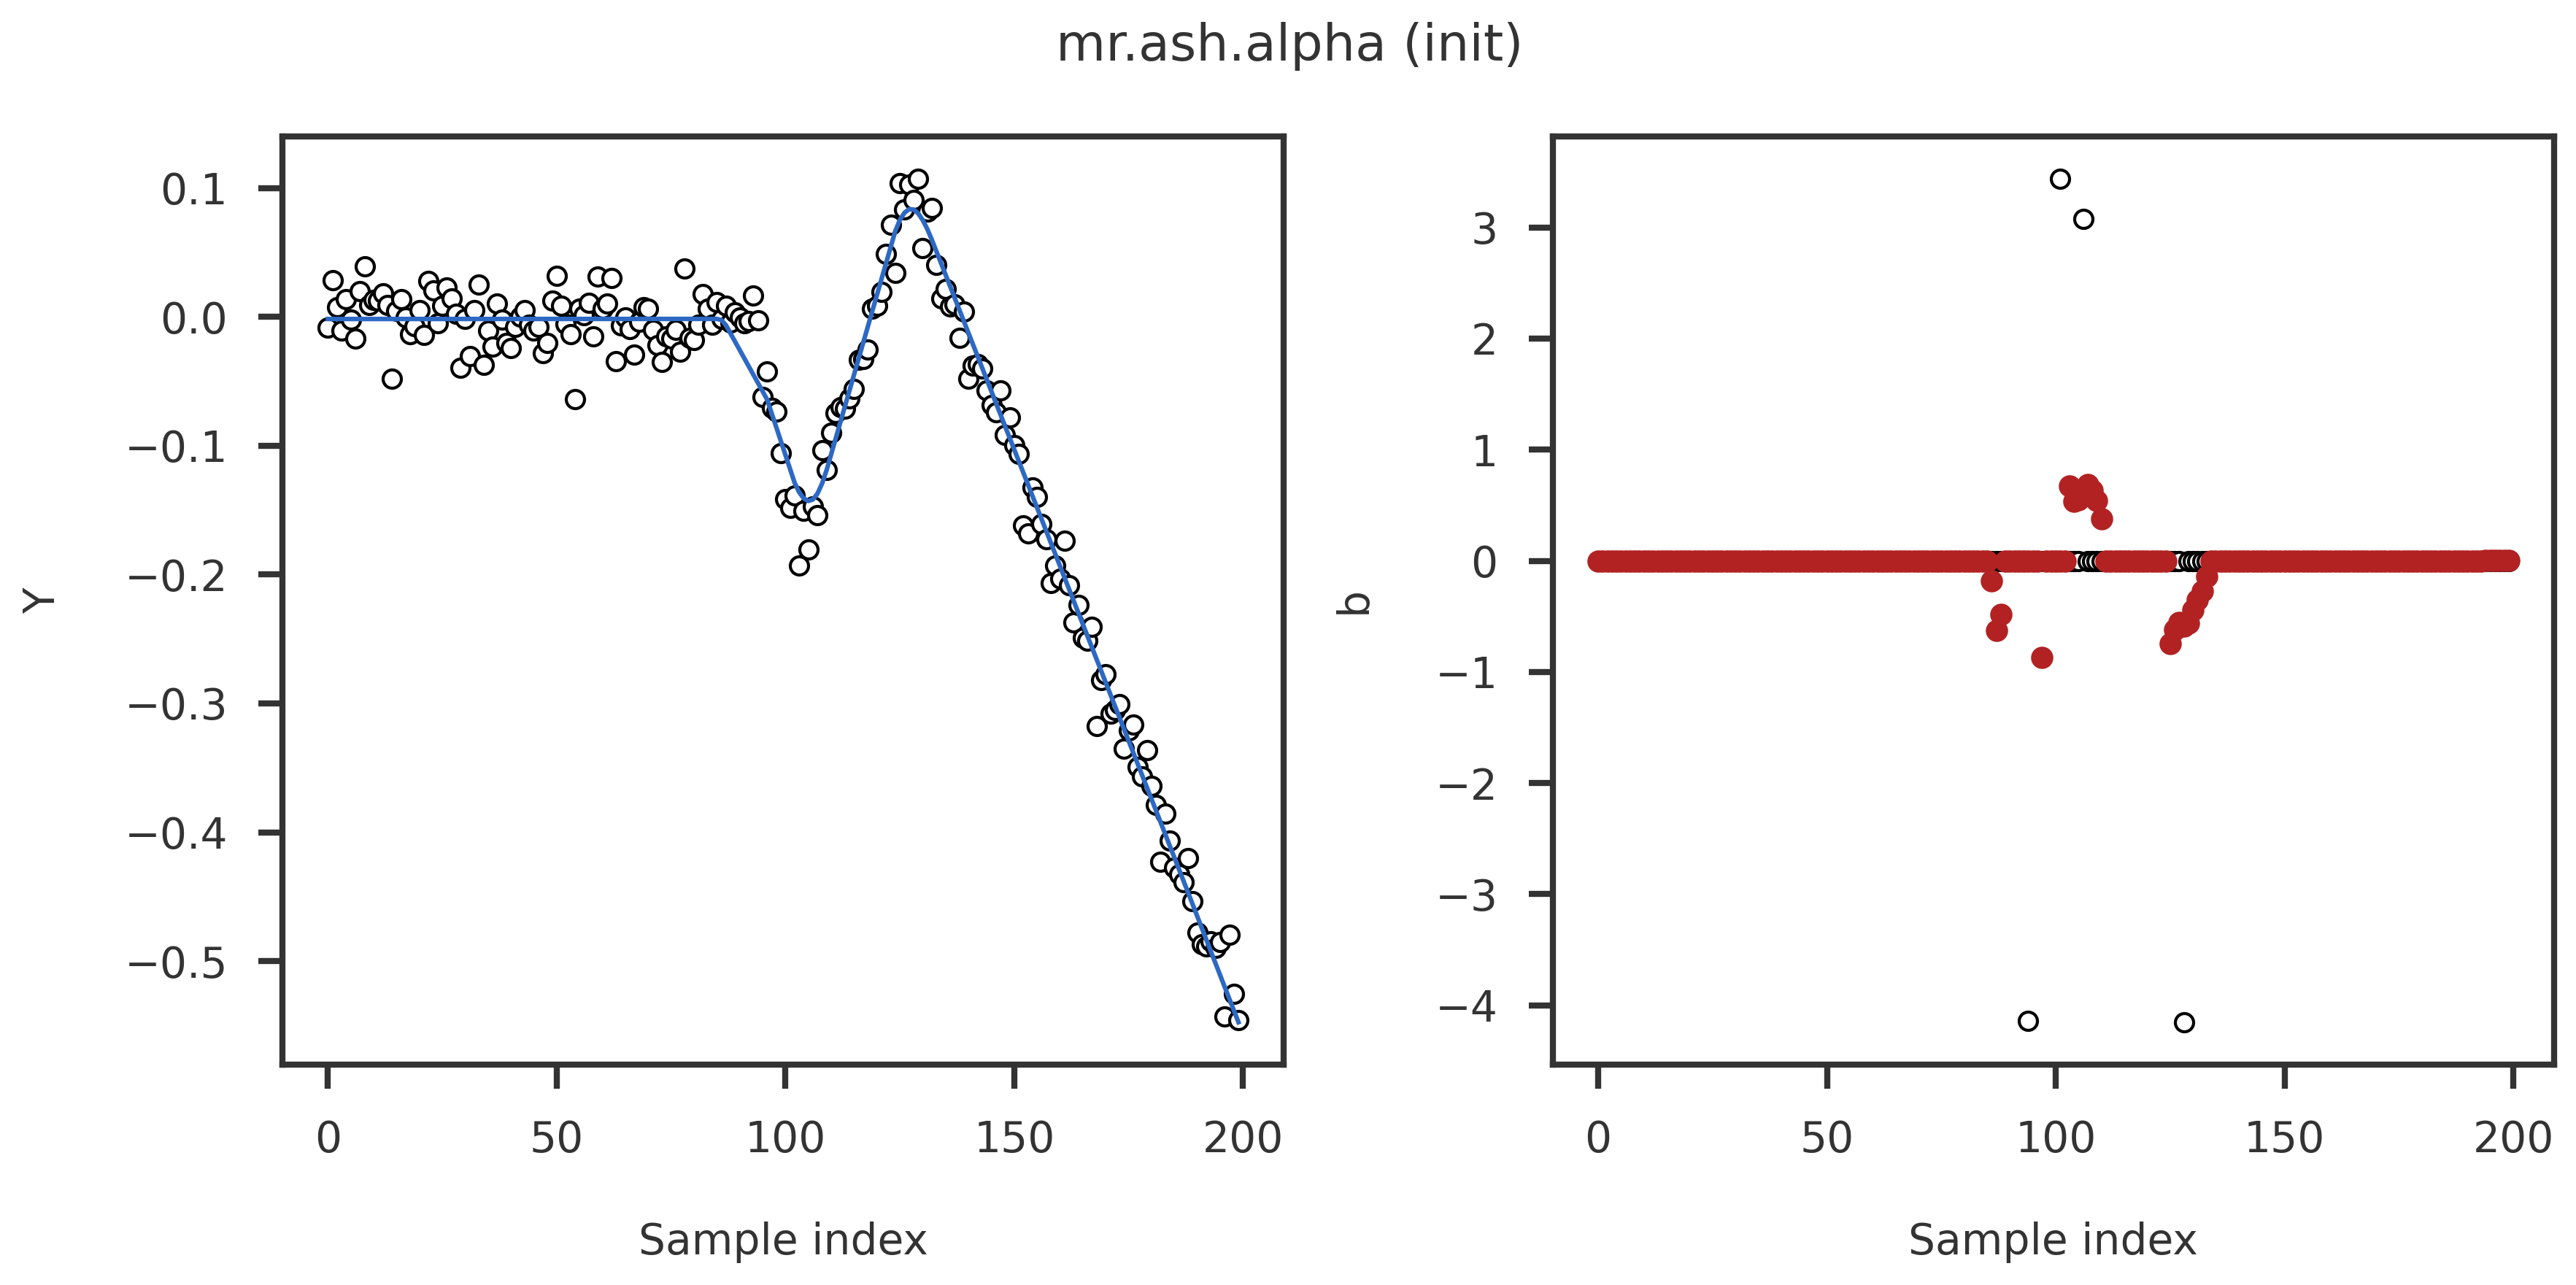

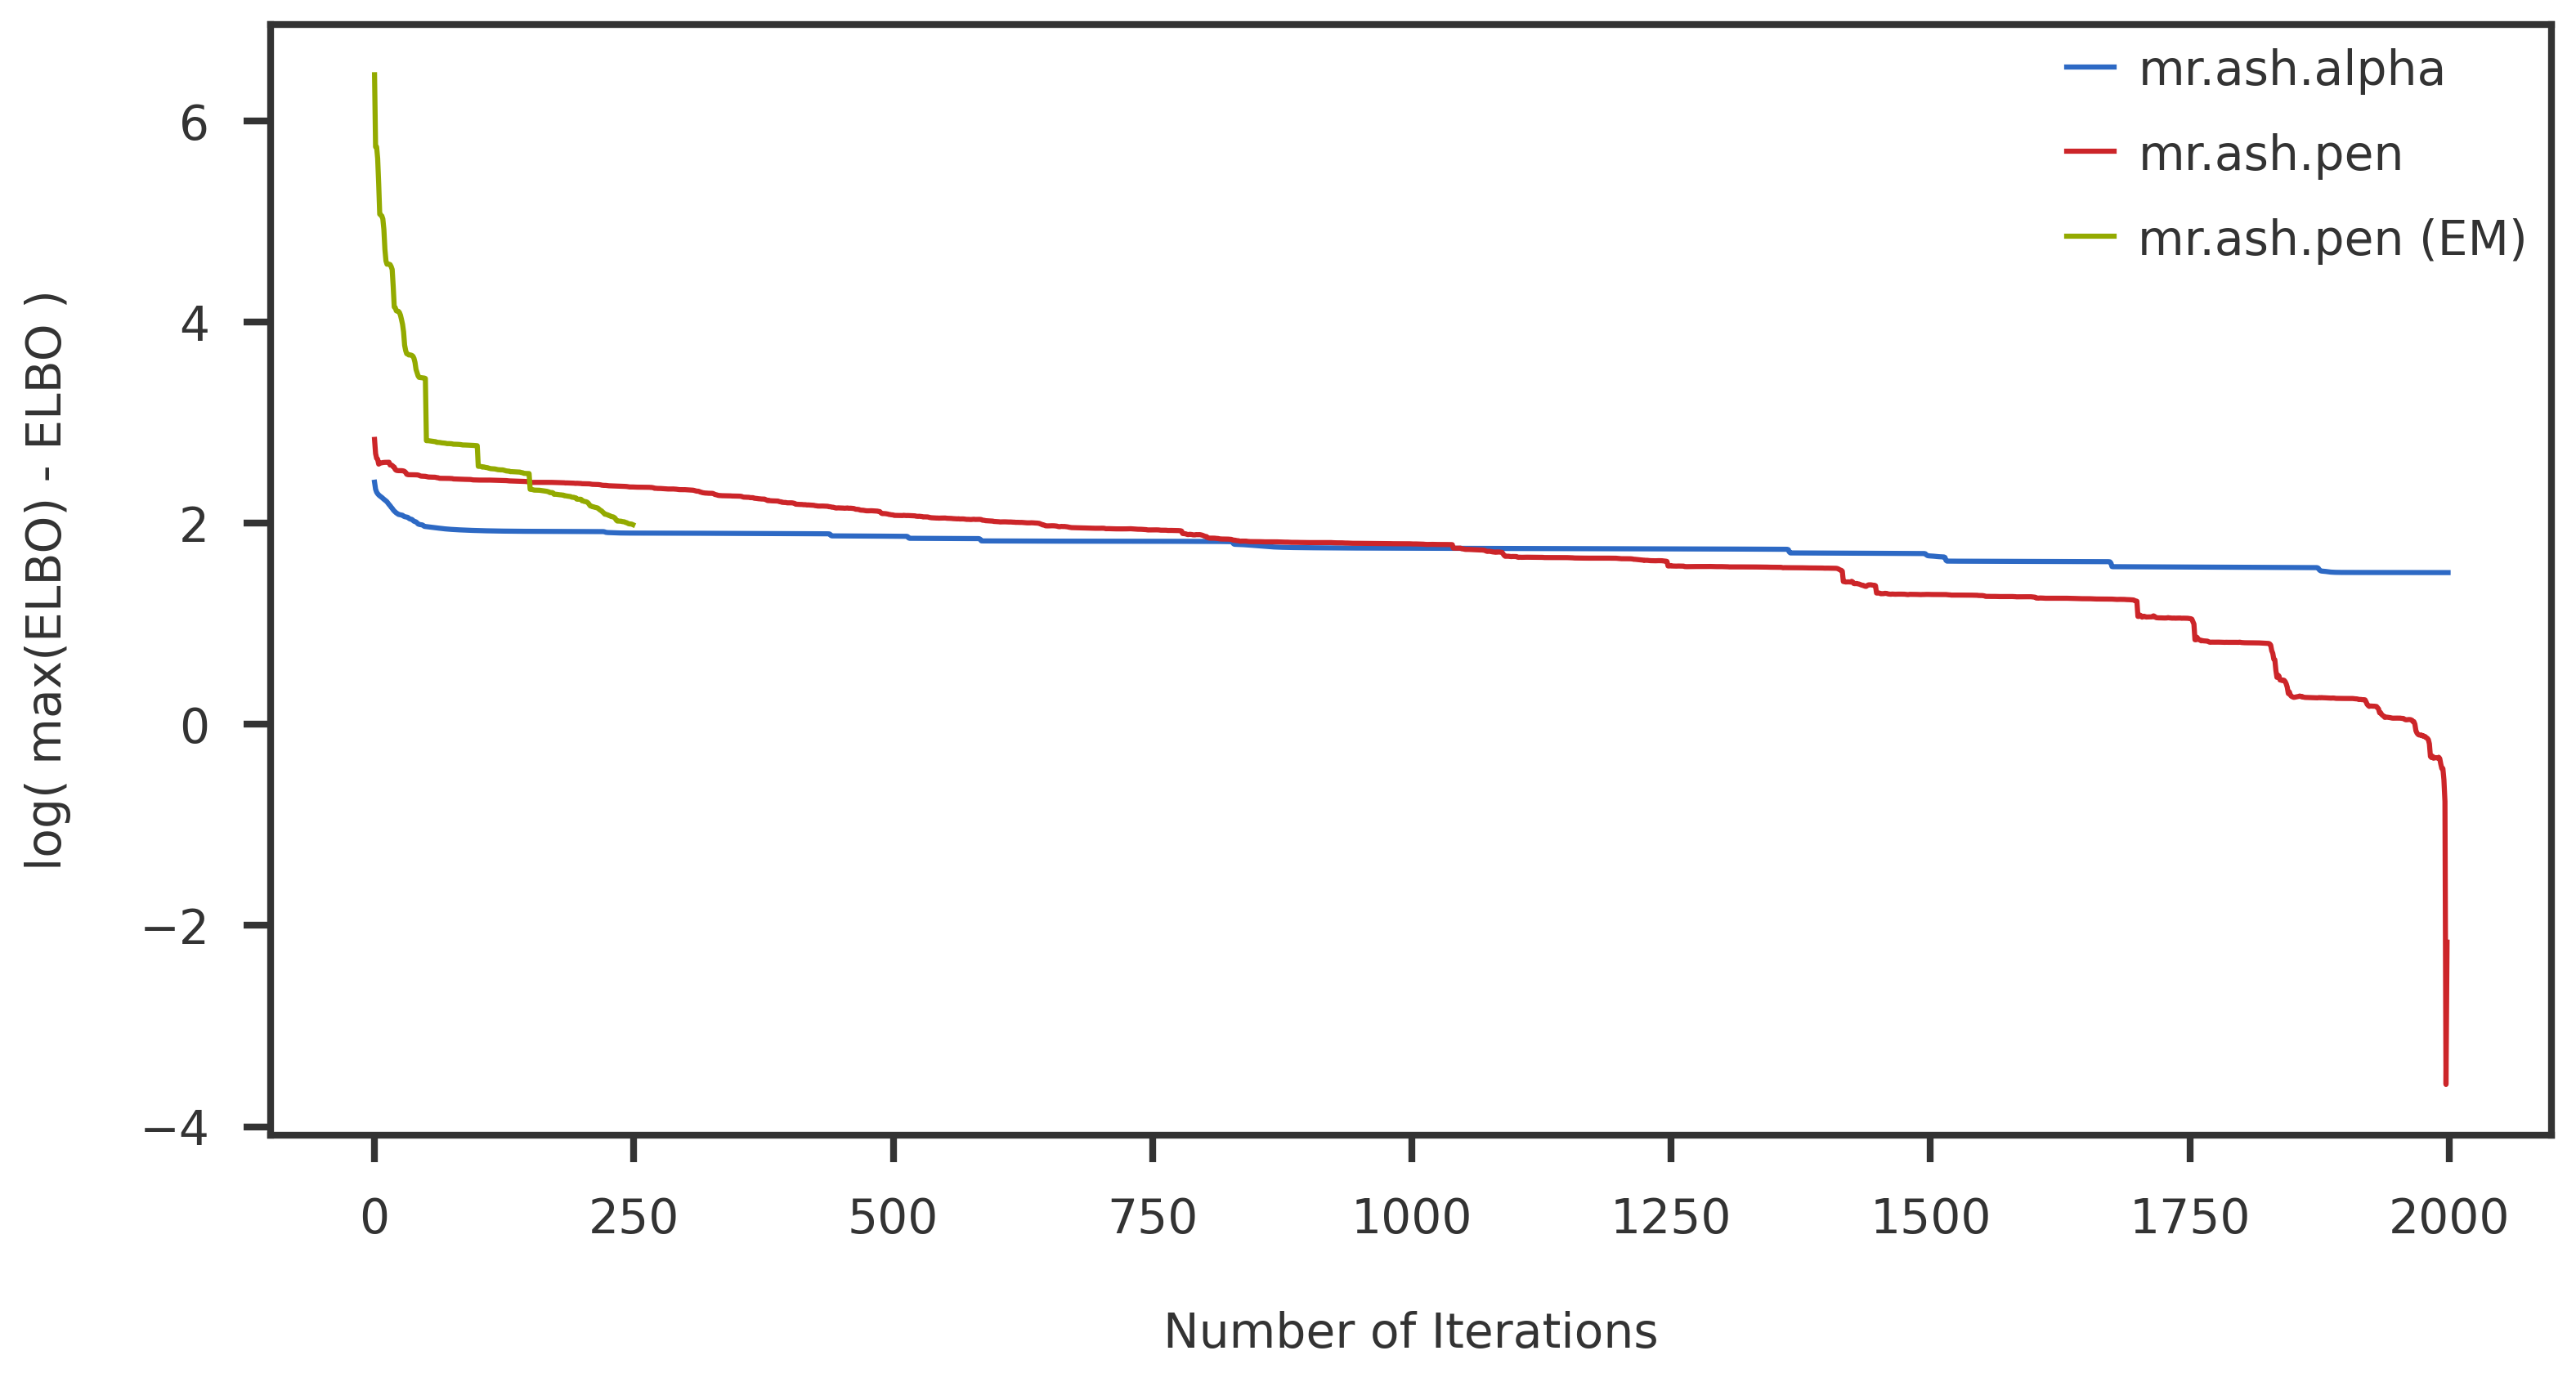

In [16]:
#collapse-hide
'''
mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True, 
                maxiter = 2000, tol = 1e-8)
plr_lbfgs.fit(X, y, sk, binit = genlasso_b, winit = wk, s2init = s2init)

'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, binit = genlasso_b, winit = wk, s2init = s2init, 
               maxiter = 200, qb_maxiter = 50, calculate_elbo = True)


'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = genlasso_b, winit = wk, s2init = s2init)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

'''
Plot
'''
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     genlasso_b, intercept = genlasso_a0, title = 'Lasso')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [17]:
#collapse-hide

objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
df

sigma2        ELBO niter
True                 0.000342           -     -
mr.ash.alpha         0.000612 -278.390647  2000
mr.ash.pen           0.000461 -310.659741  2000
mr.ash.pen (EM)      0.001609 -213.929946   250
mr.ash.alpha (init)  0.000413  -349.72756  2000